# Results

This notebook includes all the results, and some notes about them

In [1]:
import json
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar
import pandas as pd

In [2]:
with open("all_results/arxpr2_scores.json") as f:
#with open("all_results/study_type_scores.json") as f:
    data = json.load(f)


Score data is all the scores (ones or zeros) that the averages are calculated from. These are also used for calculating p-values.

index data is the indices (of the literal, that is shufled for each paper) of the chosen answers, and the corroct answer, used to show that early indices are chosen more often.

choice data is the actual predicted and correct answers

In [3]:
score_data = data["scores"]
index_data = data["index_logs"]
choice_data = data["choice_log"]

In [4]:
len(score_data) # how many runs do we have results from?

29

To evaluate total score (not only each field) we make an array with all scores

In [5]:
for key in score_data:
    total = []
    for field in score_data[key]:
        total.extend(score_data[key][field])
    score_data[key]["total"] = total

In [6]:
def pval(x1, x2, verbose = True): # x2 is ref
    """calculate p-value using mcnemar test. Print, or return pvalue, or nan the score is worse."""
    if not len(x1)==len(x2):
        return

    assert len(x1)==len(x2), (len(x1),len(x2))

    a,b,c,d = 0,0,0,0
    for i in range(len(x1)):
        a += x1[i] and x2[i]
        b += x1[i] and not x2[i]
        c += not x1[i] and x2[i]
        d += not x1[i] and not x2[i]

    mcnemar_matrix = [[a, b], [c, d]]

    # all of them:
    #print(mcnemar(mcnemar_matrix, exact=True))
    #print(mcnemar(mcnemar_matrix, exact=False))
    #print(mcnemar(mcnemar_matrix, exact=False, correction=False))

    # most correct(?)
    result = mcnemar(mcnemar_matrix, exact=(b+c<25), correction=min(a,b,c,d)>25)
    if verbose:

        print(field)
        print("reference better" if c>b else "reference WORSE")
        print(c, b)
        print(result)
        print("")
    return result.pvalue if c>b else np.nan
    

## get cleaner names
Since all the runs are specified by the string of arguments, its difficult to seperate them.
So we give better names

In [7]:
# print all the runs.
#for key in score_data:
#    print(key)
#    print(len(score_data[key]["total"]))

The following are shorter, more understandable names for the runs.

Best_choice is simply taking the choice/allowable answer that matches best with the chunks (without generation).
The rest of the names are described by the combination of retrieval and generation.

First word is the choice of retrieval prompt, either (field) description, all the choices (separately) or a string of the list of all the choices (choice_list). ":x" means only every x-th choice is used, the others discarded. i.e. choices:8 uses less information than choices:3.

last word is which generation model was used (gpt (4o-mini), llama (3.1 instruct 8B), mistral (7B))

In [8]:
shortnames = [
    "description-mistral",
    "best_choice",
    "description-gpt",
    "choices-gpt",
    "choices:3-gpt",
    "choices:5-gpt",
    "choices:8-gpt",
    "choice_list-gpt",
    "choice_list:3-gpt",
    "choice_list:5-gpt",
    "choice_list:8-gpt",
    "fullpaper-gpt",
    "choices-llama",
    "choices:3-llama",
    "choices:5-llama",
    "choices:8-llama",
    "choice_list-llama",
    "choice_list:3-llama",
    "choice_list:5-llama",
    "choice_list:8-llama",
    "description-llama",
    "choices-mistral",
    "choices:3-mistral",
    "choices:5-mistral",
    "choices:8-mistral",
    "choice_list-mistral",
    "choice_list:3-mistral",
    "choice_list:5-mistral",
    "choice_list:8-mistral",

]

In [9]:
# for verifying the names are correct
shortnames_by_argstring = {}
i = 0
for key in score_data:
    shortnames_by_argstring[key] = shortnames[i]
    print(shortnames[i], "\t", key)
    i += 1

description-mistral 	 [('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 300), ('context_shortener', 'retrieval'), ('dataset', 'arxpr2'), ('dataset_literal_length', 25), ('dataset_shuffle', 'r'), ('embedding_model', 'all-MiniLM-L6-v2'), ('ff_model', 'TheBloke/Mistral-7B-v0.1-GPTQ'), ('field_info_to_compare', 'description'), ('include_choice_every', 1), ('keyphrase_min', 1), ('keyphrase_range_diff', 1), ('listed_output', False), ('log', True), ('maxsum_factor', 1.0), ('mmr_param', 1.0), ('n_keywords', 8), ('openai_ff_max_tokens', 1000), ('outlines_ff_max_tokens', 100), ('reduce_max_tokens', 50), ('reduce_temperature', 0.4), ('remove_fields', 'non-single'), ('retriever_type', 'simple'), ('sampler', 'beam'), ('sampler_beams', 3), ('sampler_temp', 0.4), ('sampler_top_k', 100), ('sampler_top_p', 1), ('similarity_k', 4)]
best_choice 	 [('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 

## Print p-values

We now print dataframes with the significance values

This is a lot of numbers. We will report only a small selection of these I think, but all are included here so its easy to find the interesting ones.

For example we could, for each generation model, use the description-mode as baseline and provide tables/figues showing the significance of improvements by using each of the other retrieval-prompts (either [choice, choice:3, choice:5, choice:8], or choice-list, or both)

In [10]:
# make dataframes
dfs = {}
for ref_key in score_data:
    values = []
    for key in score_data:
        values.append([])
        for field in score_data[key]:
            values[-1].append(pval(score_data[key][field], score_data[ref_key][field], False))
    df = pd.DataFrame(data=values, columns= score_data[key].keys(), index=shortnames)
    dfs[ref_key] = df

In [11]:
# define print function
def p(i):
    k = list(dfs.keys())[i]
    print(shortnames[i])
    print(k)
    return dfs[k]

Now we print. 

Explanation of the print: p(0) is the results for the best_choice model. each row is the different moodels we compare with. The first is itself (not interesting). In the second row, the resutls means that best-choice is better at experimental design and assay_by_molecule, with pvalues of 28.8% (which is not significant) and 0.0032% (which is very significant) respectively, while best-choice is worse in all other fields, including the total score.

In [12]:
p(0)

description-mistral
[('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 300), ('context_shortener', 'retrieval'), ('dataset', 'arxpr2'), ('dataset_literal_length', 25), ('dataset_shuffle', 'r'), ('embedding_model', 'all-MiniLM-L6-v2'), ('ff_model', 'TheBloke/Mistral-7B-v0.1-GPTQ'), ('field_info_to_compare', 'description'), ('include_choice_every', 1), ('keyphrase_min', 1), ('keyphrase_range_diff', 1), ('listed_output', False), ('log', True), ('maxsum_factor', 1.0), ('mmr_param', 1.0), ('n_keywords', 8), ('openai_ff_max_tokens', 1000), ('outlines_ff_max_tokens', 100), ('reduce_max_tokens', 50), ('reduce_temperature', 0.4), ('remove_fields', 'non-single'), ('retriever_type', 'simple'), ('sampler', 'beam'), ('sampler_beams', 3), ('sampler_temp', 0.4), ('sampler_top_k', 100), ('sampler_top_p', 1), ('similarity_k', 4)]


hardware_4  organism_part_5  experimental_designs_10  \
description-mistral           NaN              NaN                      NaN   
best_choice              0.332306              NaN                      NaN   
description-gpt               NaN              NaN                      NaN   
choices-gpt                   NaN              NaN                      NaN   
choices:3-gpt                 NaN              NaN                      NaN   
choices:5-gpt                 NaN              NaN                      NaN   
choices:8-gpt                 NaN              NaN                      NaN   
choice_list-gpt               NaN              NaN                      NaN   
choice_list:3-gpt             NaN              NaN                      NaN   
choice_list:5-gpt             NaN              NaN                      NaN   
choice_list:8-gpt             NaN              NaN                      NaN   
fullpaper-gpt                 NaN              NaN                      NaN   
choices-llama                 NaN              NaN                      NaN   
choices:3-llama               NaN         0.076843                      NaN   
choices:5-llama          0.647606         0.030754                      1.0   
choices:8-llama          0.454498         0.018321                      NaN   
choice_list-llama             NaN         0.663624                      NaN   
choice_list:3-llama      0.790527         0.113846                      NaN   
choice_list:5-llama      0.266846         0.262332                      NaN   
choice_list:8-llama           NaN         0.383310                      NaN   
description-llama             NaN              NaN                      NaN   
choices-mistral               NaN              NaN                      NaN   
choices:3-mistral             NaN         0.432768                      NaN   
choices:5-mistral             NaN         0.018603                      NaN   
choices:8-mistral             NaN         0.019631                      NaN   
choice_list-mistral           NaN         0.663624                      NaN   
choice_list:3-mistral         NaN         0.831812                      NaN   
choice_list:5-mistral         NaN         0.133801                      NaN   
choice_list:8-mistral         NaN         0.161513                      NaN   

                       assay_by_molecule_14  study_type_18  total  
description-mistral                     NaN            NaN    NaN  
best_choice                             NaN            NaN    NaN  
description-gpt                         NaN            NaN    NaN  
choices-gpt                             NaN            NaN    NaN  
choices:3-gpt                           NaN            NaN    NaN  
choices:5-gpt                           NaN            NaN    NaN  
choices:8-gpt                           NaN            NaN    NaN  
choice_list-gpt                         NaN            NaN    NaN  
choice_list:3-gpt                       NaN            NaN    NaN  
choice_list:5-gpt                       NaN            NaN    NaN  
choice_list:8-gpt                       NaN            NaN    NaN  
fullpaper-gpt                           NaN            NaN    NaN  
choices-llama                           NaN            NaN    NaN  
choices:3-llama                         NaN            NaN    NaN  
choices:5-llama                         NaN            NaN    NaN  
choices:8-llama                         NaN            NaN    NaN  
choice_list-llama                       NaN            NaN    NaN  
choice_list:3-llama                     NaN            NaN    NaN  
choice_list:5-llama                     NaN            NaN    NaN  
choice_list:8-llama                     NaN            NaN    NaN  
description-llama                       NaN            NaN    NaN  
choices-mistral                         NaN            NaN    NaN  
choices:3-mistral                       NaN            NaN    NaN  
choices:5-mistral   

In [13]:
p(1)

best_choice
[('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 500), ('context_shortener', 'retrieval'), ('dataset', 'arxpr2'), ('dataset_literal_length', 25), ('dataset_shuffle', 'r'), ('embedding_model', 'all-MiniLM-L6-v2'), ('ff_model', 'best_choice'), ('field_info_to_compare', 'choices'), ('include_choice_every', 1), ('keyphrase_min', 1), ('keyphrase_range_diff', 1), ('listed_output', False), ('log', True), ('maxsum_factor', 1.0), ('mmr_param', 1.0), ('n_keywords', 8), ('openai_ff_max_tokens', 1000), ('outlines_ff_max_tokens', 100), ('reduce_max_tokens', 50), ('reduce_temperature', 0.4), ('remove_fields', 'non-single'), ('retriever_type', 'simple'), ('sampler', 'beam'), ('sampler_beams', 3), ('sampler_temp', 0.4), ('sampler_top_k', 100), ('sampler_top_p', 1), ('similarity_k', 1)]


hardware_4  organism_part_5  experimental_designs_10  \
description-mistral           NaN         0.013664             1.499876e-06   
best_choice                   NaN              NaN                      NaN   
description-gpt               NaN              NaN             5.900139e-01   
choices-gpt                   NaN              NaN                      NaN   
choices:3-gpt                 NaN              NaN                      NaN   
choices:5-gpt                 NaN              NaN             7.388827e-01   
choices:8-gpt                 NaN              NaN                      NaN   
choice_list-gpt               NaN              NaN                      NaN   
choice_list:3-gpt             NaN              NaN                      NaN   
choice_list:5-gpt             NaN              NaN                      NaN   
choice_list:8-gpt             NaN              NaN                      NaN   
fullpaper-gpt                 NaN              NaN             1.069213e-03   
choices-llama                 NaN              NaN             2.212524e-04   
choices:3-llama               NaN         0.000115             3.444129e-06   
choices:5-llama               NaN         0.000010             8.944732e-07   
choices:8-llama               NaN         0.000006             2.516513e-06   
choice_list-llama             NaN         0.003500             2.556309e-04   
choice_list:3-llama           NaN         0.000929             1.177134e-05   
choice_list:5-llama           NaN         0.002282             1.946047e-05   
choice_list:8-llama           NaN         0.000604             3.215956e-05   
description-llama             NaN         0.013664             1.499876e-06   
choices-mistral               NaN              NaN             2.212524e-04   
choices:3-mistral             NaN         0.002347             3.588200e-05   
choices:5-mistral             NaN         0.000015             5.312128e-05   
choices:8-mistral             NaN         0.000023             1.570523e-04   
choice_list-mistral           NaN         0.003500             2.556309e-04   
choice_list:3-mistral         NaN         0.007932             9.584006e-06   
choice_list:5-mistral         NaN         0.000156             5.744712e-06   
choice_list:8-mistral         NaN         0.000911             8.769942e-05   

                       assay_by_molecule_14  study_type_18         total  
description-mistral            7.582636e-09       0.118469  7.411104e-12  
best_choice                             NaN            NaN           NaN  
description-gpt                2.457328e-04            NaN           NaN  
choices-gpt                             NaN            NaN           NaN  
choices:3-gpt                  9.322376e-03            NaN           NaN  
choices:5-gpt                  2.265584e-02            NaN           NaN  
choices:8-gpt                  2.265584e-02            NaN           NaN  
choice_list-gpt                         NaN            NaN           NaN  
choice_list:3-gpt              3.487005e-03            NaN           NaN  
choice_list:5-gpt              5.345677e-03            NaN           NaN  
choice_list:8-gpt              5.345677e-03            NaN           NaN  
fullpaper-gpt                  7.316006e-01            NaN           NaN  
choices-llama                  4.677735e-03            NaN           NaN  
choices:3-llama                4.708980e-09            NaN  1.383791e-03  
choices:5-llama                4.708980e-09            NaN  4.219396e-05  
choices:8-llama                4.708980e-09            NaN  1.205406e-04  
choice_list-llama              2.305526e-04            NaN  1.612532e-02  
choice_list:3-llama            2.129056e-09            NaN  7.963489e-03  
choice_list:5-llama            2.129056e-09            NaN  1.244121e-03  
choice_list:8-llama            1.230187e-08       0.814529  6.187457e-07  
description-llama              7.582636e-09       0.118469  7.411104e-12  
ch

In [14]:
p(2)

description-gpt
[('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 500), ('context_shortener', 'retrieval'), ('dataset', 'arxpr2'), ('dataset_literal_length', 25), ('dataset_shuffle', 'r'), ('embedding_model', 'all-MiniLM-L6-v2'), ('ff_model', '4om'), ('field_info_to_compare', 'description'), ('include_choice_every', 1), ('keyphrase_min', 1), ('keyphrase_range_diff', 1), ('listed_output', False), ('log', True), ('maxsum_factor', 1.0), ('mmr_param', 1.0), ('n_keywords', 8), ('openai_ff_max_tokens', 1000), ('outlines_ff_max_tokens', 100), ('reduce_max_tokens', 50), ('reduce_temperature', 0.4), ('remove_fields', 'non-single'), ('retriever_type', 'simple'), ('sampler', 'beam'), ('sampler_beams', 3), ('sampler_temp', 0.4), ('sampler_top_k', 100), ('sampler_top_p', 1), ('similarity_k', 10)]


hardware_4  organism_part_5  experimental_designs_10  \
description-mistral      0.000010     1.621318e-04                 0.000016   
best_choice              0.000006     2.888444e-01                      NaN   
description-gpt               NaN              NaN                      NaN   
choices-gpt                   NaN              NaN                      NaN   
choices:3-gpt                 NaN     6.776395e-01                      NaN   
choices:5-gpt                 NaN     2.568393e-01                      NaN   
choices:8-gpt                 NaN     8.414806e-01                      NaN   
choice_list-gpt               NaN              NaN                      NaN   
choice_list:3-gpt             NaN              NaN                      NaN   
choice_list:5-gpt             NaN     1.000000e+00                      NaN   
choice_list:8-gpt             NaN     4.048729e-01                      NaN   
fullpaper-gpt                 NaN              NaN                 0.006611   
choices-llama            0.715001     4.327676e-01                 0.006040   
choices:3-llama          0.000858     8.683228e-07                 0.000016   
choices:5-llama          0.000025     5.733031e-07                 0.000004   
choices:8-llama          0.000005     1.252152e-07                 0.000053   
choice_list-llama             NaN     1.478023e-04                 0.003487   
choice_list:3-llama      0.000013     3.815136e-06                 0.000027   
choice_list:5-llama      0.000002     1.556804e-05                 0.000088   
choice_list:8-llama      0.223017     8.235705e-06                 0.000145   
description-llama        0.000010     1.621318e-04                 0.000016   
choices-mistral          0.715001     4.327676e-01                 0.006040   
choices:3-mistral        0.177932     3.957025e-05                 0.001069   
choices:5-mistral        0.208668     1.482764e-06                 0.000415   
choices:8-mistral        0.067889     5.733031e-07                 0.001595   
choice_list-mistral           NaN     1.478023e-04                 0.003487   
choice_list:3-mistral    0.449692     2.305526e-04                 0.000088   
choice_list:5-mistral    0.157299     1.864606e-06                 0.000027   
choice_list:8-mistral    0.288844     2.430496e-05                 0.001595   

                       assay_by_molecule_14  study_type_18         total  
description-mistral                0.004509   1.454609e-10  3.196170e-21  
best_choice                             NaN   5.724362e-08  1.073597e-03  
description-gpt                         NaN            NaN           NaN  
choices-gpt                             NaN            NaN           NaN  
choices:3-gpt                           NaN            NaN           NaN  
choices:5-gpt                           NaN            NaN           NaN  
choices:8-gpt                           NaN            NaN           NaN  
choice_list-gpt                         NaN            NaN           NaN  
choice_list:3-gpt                       NaN            NaN           NaN  
choice_list:5-gpt                       NaN            NaN           NaN  
choice_list:8-gpt                       NaN            NaN           NaN  
fullpaper-gpt                           NaN   6.249041e-05           NaN  
choices-llama                           NaN   2.430496e-05  2.118617e-03  
choices:3-llama                    0.006642            NaN  7.407210e-11  
choices:5-llama                    0.006642            NaN  1.191648e-12  
choices:8-llama                    0.006642            NaN  3.730410e-12  
choice_list-llama                  0.888638   1.108891e-07  6.136555e-08  
choice_list:3-llama                0.001863            NaN  6.582810e-10  
choice_list:5-llama                0.001863            NaN  5.121536e-11  
choice_list:8-llama                0.005411   2.109234e-08  3.346284e-15  
description-llama                  0.004509   1.454609e-10  3.196170e-21  
ch

In [15]:
p(3)

choices-gpt
[('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 500), ('context_shortener', 'retrieval'), ('dataset', 'arxpr2'), ('dataset_literal_length', 25), ('dataset_shuffle', 'r'), ('embedding_model', 'all-MiniLM-L6-v2'), ('ff_model', '4om'), ('field_info_to_compare', 'choices'), ('include_choice_every', 1), ('keyphrase_min', 1), ('keyphrase_range_diff', 1), ('listed_output', False), ('log', True), ('maxsum_factor', 1.0), ('mmr_param', 1.0), ('n_keywords', 8), ('openai_ff_max_tokens', 1000), ('outlines_ff_max_tokens', 100), ('reduce_max_tokens', 50), ('reduce_temperature', 0.4), ('remove_fields', 'non-single'), ('retriever_type', 'simple'), ('sampler', 'beam'), ('sampler_beams', 3), ('sampler_temp', 0.4), ('sampler_top_k', 100), ('sampler_top_p', 1), ('similarity_k', 10)]


hardware_4  organism_part_5  experimental_designs_10  \
description-mistral    5.919399e-10     2.553499e-07             1.456022e-08   
best_choice            4.806291e-10     4.154176e-04             1.059975e-01   
description-gpt        6.604195e-05     2.265584e-02             3.389485e-02   
choices-gpt                     NaN              NaN                      NaN   
choices:3-gpt          6.250000e-02     1.489639e-03             7.186064e-02   
choices:5-gpt          3.437500e-01     2.771616e-04             4.819349e-02   
choices:8-gpt          3.125000e-02     1.062202e-02             3.531604e-01   
choice_list-gpt        2.187500e-01     1.338005e-01                      NaN   
choice_list:3-gpt      1.796875e-01     2.862787e-01                      NaN   
choice_list:5-gpt      1.093750e-01     9.322376e-03             1.171851e-01   
choice_list:8-gpt      3.876953e-01     1.069213e-03             5.234671e-01   
fullpaper-gpt          3.437500e-01     8.238029e-01             8.235705e-06   
choices-llama          9.635090e-05     8.554459e-04             8.235705e-06   
choices:3-llama        6.107886e-09     2.952349e-10             3.477337e-08   
choices:5-llama        1.970344e-11     2.335555e-10             8.717444e-09   
choices:8-llama        1.182530e-11     8.571764e-11             5.790052e-08   
choice_list-llama      2.556309e-04     1.108891e-07             3.061253e-06   
choice_list:3-llama    2.141243e-10     6.706293e-09             1.262352e-07   
choice_list:5-llama    1.889897e-11     9.030489e-08             9.642607e-08   
choice_list:8-llama    4.302779e-06     4.531363e-09             3.462307e-07   
description-llama      5.919399e-10     2.553499e-07             1.456022e-08   
choices-mistral        9.635090e-05     8.554459e-04             8.235705e-06   
choices:3-mistral      2.065286e-06     1.676501e-08             1.864606e-06   
choices:5-mistral      4.302779e-06     2.952349e-10             5.733031e-07   
choices:8-mistral      1.903182e-07     1.075446e-10             4.458707e-07   
choice_list-mistral    2.556309e-04     1.108891e-07             3.061253e-06   
choice_list:3-mistral  3.613113e-05     5.733031e-07             4.066142e-08   
choice_list:5-mistral  9.047332e-06     4.708980e-09             2.432744e-08   
choice_list:8-mistral  1.349373e-05     2.906095e-08             4.458707e-07   

                       assay_by_molecule_14  study_type_18         total  
description-mistral            1.781872e-10   1.537460e-12  1.605844e-42  
best_choice                    7.905273e-01   5.473986e-11  1.818655e-19  
description-gpt                1.478023e-04   2.230175e-01  3.198306e-09  
choices-gpt                             NaN            NaN           NaN  
choices:3-gpt                  5.345677e-03            NaN  2.967323e-04  
choices:5-gpt                  1.058714e-02            NaN  6.589174e-04  
choices:8-gpt                  1.058714e-02            NaN  1.144592e-02  
choice_list-gpt                         NaN            NaN           NaN  
choice_list:3-gpt              1.462717e-03            NaN  1.744522e-01  
choice_list:5-gpt              3.083186e-03            NaN  2.757676e-03  
choice_list:8-gpt              3.083186e-03            NaN  1.158053e-02  
fullpaper-gpt                  5.412562e-01   1.405794e-06  5.489791e-09  
choices-llama                  6.697294e-04   3.303143e-07  4.703707e-20  
choices:3-llama                1.731240e-09   4.795001e-01  8.662444e-29  
choices:5-llama                1.731240e-09   3.427817e-01  4.649848e-31  
choices:8-llama                1.731240e-09   7.388827e-01  3.477158e-30  
choice_list-llama              1.349373e-05   8.105017e-10  8.660377e-28  
choice_list:3-llama            3.854539e-10            NaN  1.612168e-25  
choice_list:5-llama            3.854539e-10   8.814975e-01  1.730510e-26  
choice_list:8-llama            2.952349e-10   5.240970e-11  1.710288e-37  
description-llama  

In [16]:
p(4)

choices:3-gpt
[('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 500), ('context_shortener', 'retrieval'), ('dataset', 'arxpr2'), ('dataset_literal_length', 25), ('dataset_shuffle', 'r'), ('embedding_model', 'all-MiniLM-L6-v2'), ('ff_model', '4om'), ('field_info_to_compare', 'choices'), ('include_choice_every', 3), ('keyphrase_min', 1), ('keyphrase_range_diff', 1), ('listed_output', False), ('log', True), ('maxsum_factor', 1.0), ('mmr_param', 1.0), ('n_keywords', 8), ('openai_ff_max_tokens', 1000), ('outlines_ff_max_tokens', 100), ('reduce_max_tokens', 50), ('reduce_temperature', 0.4), ('remove_fields', 'non-single'), ('retriever_type', 'simple'), ('sampler', 'beam'), ('sampler_beams', 3), ('sampler_temp', 0.4), ('sampler_top_k', 100), ('sampler_top_p', 1), ('similarity_k', 10)]


hardware_4  organism_part_5  experimental_designs_10  \
description-mistral    1.676501e-08     2.022049e-03             3.444129e-06   
best_choice            5.733460e-09     6.218734e-01                      NaN   
description-gpt        2.576828e-03              NaN             5.485062e-01   
choices-gpt                     NaN              NaN                      NaN   
choices:3-gpt                   NaN              NaN                      NaN   
choices:5-gpt                   NaN     5.485062e-01             8.318119e-01   
choices:8-gpt          1.000000e+00              NaN                      NaN   
choice_list-gpt                 NaN              NaN                      NaN   
choice_list:3-gpt               NaN              NaN                      NaN   
choice_list:5-gpt      1.000000e+00              NaN                      NaN   
choice_list:8-gpt               NaN     8.388197e-01                      NaN   
fullpaper-gpt                   NaN              NaN             1.069213e-03   
choices-llama          2.496909e-03     8.526837e-01             1.594994e-03   
choices:3-llama        1.551724e-07     5.733031e-07             3.444129e-06   
choices:5-llama        6.737436e-10     3.859616e-06             8.944732e-07   
choices:8-llama        1.522292e-10     9.225533e-07             1.177134e-05   
choice_list-llama      8.150972e-03     3.857468e-04             4.183778e-04   
choice_list:3-llama    2.723615e-09     3.653363e-05             1.177134e-05   
choice_list:5-llama    2.424145e-10     1.939416e-04             1.946047e-05   
choice_list:8-llama    2.565504e-04     1.560888e-04             5.903578e-05   
description-llama      1.676501e-08     2.022049e-03             3.444129e-06   
choices-mistral        2.496909e-03     8.526837e-01             1.594994e-03   
choices:3-mistral      5.312128e-05     5.903578e-05             1.570523e-04   
choices:5-mistral      1.621318e-04     6.106436e-06             1.621318e-04   
choices:8-mistral      5.744712e-06     7.904640e-07             1.570523e-04   
choice_list-mistral    8.150972e-03     3.857468e-04             4.183778e-04   
choice_list:3-mistral  6.697294e-04     8.581207e-04             9.584006e-06   
choice_list:5-mistral  3.585225e-04     2.467446e-05             5.744712e-06   
choice_list:8-mistral  4.069520e-04     1.375881e-04             1.570523e-04   

                       assay_by_molecule_14  study_type_18         total  
description-mistral            1.523221e-04   4.358119e-14  3.357823e-28  
best_choice                             NaN   4.098215e-12  8.591680e-09  
description-gpt                1.059975e-01   1.635122e-02  1.798737e-03  
choices-gpt                             NaN   1.670685e-01           NaN  
choices:3-gpt                           NaN            NaN           NaN  
choices:5-gpt                           NaN            NaN  1.000000e+00  
choices:8-gpt                           NaN            NaN           NaN  
choice_list-gpt                         NaN            NaN           NaN  
choice_list:3-gpt              6.072388e-01            NaN           NaN  
choice_list:5-gpt              7.905273e-01            NaN           NaN  
choice_list:8-gpt              7.905273e-01            NaN           NaN  
fullpaper-gpt                           NaN   1.279841e-08  1.596748e-02  
choices-llama                  6.547208e-01   1.342906e-09  5.542946e-09  
choices:3-llama                1.571198e-06   1.921082e-02  4.537016e-24  
choices:5-llama                1.571198e-06   4.233023e-02  2.977488e-23  
choices:8-llama                1.571198e-06   1.495414e-01  1.980492e-22  
choice_list-llama              1.489147e-01   2.364587e-11  6.948037e-16  
choice_list:3-llama            6.906563e-07            NaN  1.660192e-18  
choice_list:5-llama            6.906563e-07   2.170439e-01  1.150643e-19  
choice_list:8-llama            2.218467e-04   1.480502e-12  3.738743e-23  
description-llama  

In [17]:
p(5)

choices:5-gpt
[('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 500), ('context_shortener', 'retrieval'), ('dataset', 'arxpr2'), ('dataset_literal_length', 25), ('dataset_shuffle', 'r'), ('embedding_model', 'all-MiniLM-L6-v2'), ('ff_model', '4om'), ('field_info_to_compare', 'choices'), ('include_choice_every', 5), ('keyphrase_min', 1), ('keyphrase_range_diff', 1), ('listed_output', False), ('log', True), ('maxsum_factor', 1.0), ('mmr_param', 1.0), ('n_keywords', 8), ('openai_ff_max_tokens', 1000), ('outlines_ff_max_tokens', 100), ('reduce_max_tokens', 50), ('reduce_temperature', 0.4), ('remove_fields', 'non-single'), ('retriever_type', 'simple'), ('sampler', 'beam'), ('sampler_beams', 3), ('sampler_temp', 0.4), ('sampler_top_k', 100), ('sampler_top_p', 1), ('similarity_k', 10)]


hardware_4  organism_part_5  experimental_designs_10  \
description-mistral    2.109234e-08         0.005346                 0.000010   
best_choice            3.494433e-09              NaN                      NaN   
description-gpt        2.699796e-03              NaN                 0.847390   
choices-gpt                     NaN              NaN                      NaN   
choices:3-gpt          1.000000e+00              NaN                      NaN   
choices:5-gpt                   NaN              NaN                      NaN   
choices:8-gpt          7.744141e-01              NaN                      NaN   
choice_list-gpt                 NaN              NaN                      NaN   
choice_list:3-gpt      1.000000e+00              NaN                      NaN   
choice_list:5-gpt      7.539062e-01              NaN                      NaN   
choice_list:8-gpt               NaN              NaN                      NaN   
fullpaper-gpt                   NaN              NaN                 0.002700   
choices-llama          2.263470e-03              NaN                 0.003892   
choices:3-llama        4.600924e-08         0.000082                 0.000010   
choices:5-llama        4.040854e-10         0.000015                 0.000003   
choices:8-llama        5.919399e-10         0.000006                 0.000032   
choice_list-llama      5.345677e-03         0.001015                 0.001595   
choice_list:3-llama    1.637296e-09         0.000266                 0.000032   
choice_list:5-llama    3.559942e-10         0.001496                 0.000053   
choice_list:8-llama    1.006219e-04         0.000088                 0.000088   
description-llama      2.109234e-08         0.005346                 0.000010   
choices-mistral        2.263470e-03              NaN                 0.003892   
choices:3-mistral      1.613164e-04         0.000418                 0.000415   
choices:5-mistral      1.006219e-04         0.000003                 0.000145   
choices:8-mistral      1.349373e-05         0.000010                 0.001015   
choice_list-mistral    5.345677e-03         0.001015                 0.001595   
choice_list:3-mistral  9.414096e-04         0.005193                 0.000053   
choice_list:5-mistral  1.560888e-04         0.000036                 0.000016   
choice_list:8-mistral  1.621318e-04         0.000504                 0.001015   

                       assay_by_molecule_14  study_type_18         total  
description-mistral            1.042119e-04   1.576720e-14  5.351523e-28  
best_choice                             NaN   1.480502e-12  7.097682e-09  
description-gpt                7.709987e-02   6.069972e-03  3.772056e-03  
choices-gpt                             NaN   9.313965e-02           NaN  
choices:3-gpt                  1.000000e+00   7.054570e-01           NaN  
choices:5-gpt                           NaN            NaN           NaN  
choices:8-gpt                           NaN            NaN           NaN  
choice_list-gpt                         NaN            NaN           NaN  
choice_list:3-gpt              4.239502e-01            NaN           NaN  
choice_list:5-gpt              5.810547e-01            NaN           NaN  
choice_list:8-gpt              5.810547e-01            NaN           NaN  
fullpaper-gpt                           NaN   4.708980e-09  1.866221e-02  
choices-llama                  5.553463e-01   2.129056e-09  9.510172e-09  
choices:3-llama                9.491672e-07   3.737299e-02  4.947748e-20  
choices:5-llama                9.491672e-07   7.058332e-03  8.156560e-25  
choices:8-llama                9.491672e-07   7.816909e-02  8.315617e-22  
choice_list-llama              1.160831e-01   5.550063e-13  3.736771e-16  
choice_list:3-llama            4.200394e-07   6.948866e-01  1.118568e-18  
choice_list:5-llama            4.200394e-07   4.986020e-02  1.998373e-20  
choice_list:8-llama            1.523221e-04   5.351800e-13  3.392595e-24  
description-llama  

In [18]:
p(6)

choices:8-gpt
[('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 500), ('context_shortener', 'retrieval'), ('dataset', 'arxpr2'), ('dataset_literal_length', 25), ('dataset_shuffle', 'r'), ('embedding_model', 'all-MiniLM-L6-v2'), ('ff_model', '4om'), ('field_info_to_compare', 'choices'), ('include_choice_every', 8), ('keyphrase_min', 1), ('keyphrase_range_diff', 1), ('listed_output', False), ('log', True), ('maxsum_factor', 1.0), ('mmr_param', 1.0), ('n_keywords', 8), ('openai_ff_max_tokens', 1000), ('outlines_ff_max_tokens', 100), ('reduce_max_tokens', 50), ('reduce_temperature', 0.4), ('remove_fields', 'non-single'), ('retriever_type', 'simple'), ('sampler', 'beam'), ('sampler_beams', 3), ('sampler_temp', 0.4), ('sampler_top_k', 100), ('sampler_top_p', 1), ('similarity_k', 10)]


hardware_4  organism_part_5  experimental_designs_10  \
description-mistral    2.777380e-08     2.028231e-03             7.237830e-08   
best_choice            9.403667e-09     3.980247e-01             5.164123e-01   
description-gpt        7.197380e-03              NaN             2.230175e-01   
choices-gpt                     NaN              NaN                      NaN   
choices:3-gpt                   NaN     8.318119e-01             4.327676e-01   
choices:5-gpt                   NaN     3.531604e-01             2.888444e-01   
choices:8-gpt                   NaN              NaN                      NaN   
choice_list-gpt                 NaN              NaN                      NaN   
choice_list:3-gpt               NaN              NaN                      NaN   
choice_list:5-gpt               NaN              NaN             4.652088e-01   
choice_list:8-gpt               NaN     5.034447e-01                      NaN   
fullpaper-gpt                   NaN              NaN             1.621318e-04   
choices-llama          3.892417e-03     5.637029e-01             9.635090e-05   
choices:3-llama        2.553499e-07     1.405794e-06             4.458707e-07   
choices:5-llama        1.123642e-09     9.225533e-07             1.137273e-07   
choices:8-llama        2.539629e-10     1.254865e-08             7.430984e-07   
choice_list-llama      1.235459e-02     3.281542e-04             9.584006e-06   
choice_list:3-llama    4.531363e-09     1.490234e-05             7.430984e-07   
choice_list:5-llama    4.040854e-10     1.563527e-04             1.238710e-06   
choice_list:8-llama    4.069520e-04     3.957025e-05             2.065286e-06   
description-llama      2.777380e-08     2.028231e-03             7.237830e-08   
choices-mistral        3.892417e-03     5.637029e-01             9.635090e-05   
choices:3-mistral      1.570523e-04     9.888398e-05             2.209050e-05   
choices:5-mistral      2.607296e-04     6.025761e-06             3.444129e-06   
choices:8-mistral      4.224909e-06     1.551724e-07             1.192093e-07   
choice_list-mistral    1.235459e-02     3.281542e-04             9.584006e-06   
choice_list:3-mistral  1.594994e-03     6.871044e-04             5.337264e-07   
choice_list:5-mistral  5.556672e-04     5.312128e-05             1.213155e-07   
choice_list:8-mistral  6.436975e-04     5.699412e-05             2.516513e-06   

                       assay_by_molecule_14  study_type_18         total  
description-mistral            1.042119e-04   2.536607e-14  1.463603e-29  
best_choice                             NaN   8.900637e-13  2.671010e-10  
description-gpt                7.709987e-02   4.059196e-03  1.959150e-04  
choices-gpt                             NaN   4.986020e-02           NaN  
choices:3-gpt                  1.000000e+00   5.774687e-01  3.740628e-01  
choices:5-gpt                           NaN   8.414806e-01  3.632777e-01  
choices:8-gpt                           NaN            NaN           NaN  
choice_list-gpt                         NaN   1.000000e+00           NaN  
choice_list:3-gpt              4.239502e-01            NaN           NaN  
choice_list:5-gpt              5.810547e-01            NaN  5.504925e-01  
choice_list:8-gpt              5.810547e-01            NaN  1.000000e+00  
fullpaper-gpt                           NaN   1.093973e-08  2.183045e-03  
choices-llama                  5.553463e-01   1.296752e-09  1.420062e-10  
choices:3-llama                9.491672e-07   1.635122e-02  1.264935e-23  
choices:5-llama                9.491672e-07   1.586133e-02  2.627444e-25  
choices:8-llama                9.491672e-07   3.389485e-02  2.278632e-27  
choice_list-llama              1.160831e-01   8.900637e-13  5.224905e-18  
choice_list:3-llama            4.200394e-07   5.900139e-01  8.156472e-21  
choice_list:5-llama            4.200394e-07   7.816909e-02  8.646204e-22  
choice_list:8-llama            1.523221e-04   1.205298e-13  9.234433e-26  
description-llama  

In [19]:
p(7)

choice_list-gpt
[('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 500), ('context_shortener', 'retrieval'), ('dataset', 'arxpr2'), ('dataset_literal_length', 25), ('dataset_shuffle', 'r'), ('embedding_model', 'all-MiniLM-L6-v2'), ('ff_model', '4om'), ('field_info_to_compare', 'choice-list'), ('include_choice_every', 1), ('keyphrase_min', 1), ('keyphrase_range_diff', 1), ('listed_output', False), ('log', True), ('maxsum_factor', 1.0), ('mmr_param', 1.0), ('n_keywords', 8), ('openai_ff_max_tokens', 1000), ('outlines_ff_max_tokens', 100), ('reduce_max_tokens', 50), ('reduce_temperature', 0.4), ('remove_fields', 'non-single'), ('retriever_type', 'simple'), ('sampler', 'beam'), ('sampler_beams', 3), ('sampler_temp', 0.4), ('sampler_top_k', 100), ('sampler_top_p', 1), ('similarity_k', 10)]


hardware_4  organism_part_5  experimental_designs_10  \
description-mistral    4.531363e-09     2.381238e-05             1.181292e-09   
best_choice            3.494433e-09     6.788915e-02             3.389485e-02   
description-gpt        1.489639e-03     5.412562e-01             7.058332e-03   
choices-gpt                     NaN              NaN             6.636238e-01   
choices:3-gpt          1.000000e+00     1.615133e-01             2.265584e-02   
choices:5-gpt                   NaN     5.878172e-02             1.058714e-02   
choices:8-gpt          6.875000e-01     4.048729e-01             1.700670e-01   
choice_list-gpt                 NaN              NaN                      NaN   
choice_list:3-gpt      1.000000e+00              NaN                      NaN   
choice_list:5-gpt      7.265625e-01     2.668457e-01             2.334220e-02   
choice_list:8-gpt               NaN     9.313965e-02             1.670685e-01   
fullpaper-gpt                   NaN              NaN             4.458707e-07   
choices-llama          1.069213e-03     1.515896e-01             4.458707e-07   
choices:3-llama        4.600924e-08     1.676501e-08             7.540127e-09   
choices:5-llama        9.844006e-10     4.732139e-08             1.874468e-09   
choices:8-llama        9.127342e-11     9.403667e-09             1.254865e-08   
choice_list-llama      2.699796e-03     1.556804e-05             1.606146e-07   
choice_list:3-llama    1.637296e-09     9.426291e-08             2.777380e-08   
choice_list:5-llama    1.454609e-10     1.405794e-06             2.088746e-08   
choice_list:8-llama    5.903578e-05     5.733031e-07             3.477337e-08   
description-llama      4.531363e-09     2.381238e-05             1.181292e-09   
choices-mistral        1.069213e-03     1.515896e-01             4.458707e-07   
choices:3-mistral      3.215956e-05     1.864606e-06             4.066142e-08   
choices:5-mistral      5.903578e-05     3.728116e-07             5.790052e-08   
choices:8-mistral      1.499876e-06     4.732139e-08             2.090716e-07   
choice_list-mistral    2.699796e-03     1.556804e-05             1.606146e-07   
choice_list:3-mistral  4.183778e-04     9.047332e-06             8.717444e-09   
choice_list:5-mistral  1.011946e-04     4.842438e-07             5.220986e-09   
choice_list:8-mistral  9.635090e-05     1.405794e-06             2.090716e-07   

                       assay_by_molecule_14  study_type_18         total  
description-mistral            1.480502e-12   1.576720e-14  1.461784e-44  
best_choice                    1.153183e-01   3.684265e-12  2.903200e-19  
description-gpt                2.101436e-06   3.487005e-03  6.231088e-11  
choices-gpt                    1.795654e-01   7.186064e-02  5.940323e-01  
choices:3-gpt                  5.556672e-04   8.145294e-01  6.706542e-05  
choices:5-gpt                  8.581207e-04            NaN  1.277561e-04  
choices:8-gpt                  8.581207e-04            NaN  2.811041e-03  
choice_list-gpt                         NaN            NaN           NaN  
choice_list:3-gpt              6.334248e-05            NaN  2.685670e-02  
choice_list:5-gpt              1.011946e-04            NaN  6.887216e-05  
choice_list:8-gpt              1.011946e-04            NaN  1.250355e-03  
fullpaper-gpt                  4.986020e-02   4.708980e-09  1.526663e-09  
choices-llama                  2.516513e-06   4.891710e-10  5.163793e-22  
choices:3-llama                8.571764e-11   2.363510e-02  1.990636e-31  
choices:5-llama                8.571764e-11   2.534732e-02  8.686780e-32  
choices:8-llama                8.571764e-11   7.054600e-02  1.492075e-32  
choice_list-llama              1.606146e-07   3.684265e-12  1.295738e-29  
choice_list:3-llama            1.904395e-11   7.150007e-01  1.532476e-28  
choice_list:5-llama            1.904395e-11   1.138463e-01  9.895894e-30  
choice_list:8-llama            2.463010e-12   2.004896e-13  1.724803e-39  
description-llama  

In [20]:
p(8)

choice_list:3-gpt
[('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 500), ('context_shortener', 'retrieval'), ('dataset', 'arxpr2'), ('dataset_literal_length', 25), ('dataset_shuffle', 'r'), ('embedding_model', 'all-MiniLM-L6-v2'), ('ff_model', '4om'), ('field_info_to_compare', 'choice-list'), ('include_choice_every', 3), ('keyphrase_min', 1), ('keyphrase_range_diff', 1), ('listed_output', False), ('log', True), ('maxsum_factor', 1.0), ('mmr_param', 1.0), ('n_keywords', 8), ('openai_ff_max_tokens', 1000), ('outlines_ff_max_tokens', 100), ('reduce_max_tokens', 50), ('reduce_temperature', 0.4), ('remove_fields', 'non-single'), ('retriever_type', 'simple'), ('sampler', 'beam'), ('sampler_beams', 3), ('sampler_temp', 0.4), ('sampler_top_k', 100), ('sampler_top_p', 1), ('similarity_k', 10)]


hardware_4  organism_part_5  experimental_designs_10  \
description-mistral    1.676501e-08     1.536009e-05             1.181292e-09   
best_choice            5.733460e-09     3.389485e-02             3.389485e-02   
description-gpt        2.576828e-03     3.074563e-01             9.023439e-03   
choices-gpt                     NaN              NaN             5.900139e-01   
choices:3-gpt                   NaN     8.326452e-02             2.334220e-02   
choices:5-gpt                   NaN     3.959176e-02             1.963066e-02   
choices:8-gpt          1.000000e+00     1.936464e-01             1.824224e-01   
choice_list-gpt                 NaN     7.905273e-01                      NaN   
choice_list:3-gpt               NaN              NaN                      NaN   
choice_list:5-gpt      1.000000e+00     1.184692e-01             2.265584e-02   
choice_list:8-gpt               NaN     2.780690e-02             1.615133e-01   
fullpaper-gpt                   NaN              NaN             4.458707e-07   
choices-llama          2.496909e-03     4.986020e-02             4.458707e-07   
choices:3-llama        1.551724e-07     6.107886e-09             3.127887e-09   
choices:5-llama        1.637296e-09     3.230930e-08             1.874468e-09   
choices:8-llama        1.522292e-10     6.706293e-09             1.254865e-08   
choice_list-llama      6.039559e-03     6.106436e-06             1.606146e-07   
choice_list:3-llama    2.723615e-09     2.206565e-07             2.777380e-08   
choice_list:5-llama    2.424145e-10     1.521993e-06             8.717444e-09   
choice_list:8-llama    2.565504e-04     7.904640e-07             3.477337e-08   
description-llama      1.676501e-08     1.536009e-05             1.181292e-09   
choices-mistral        2.496909e-03     4.986020e-02             4.458707e-07   
choices:3-mistral      9.635090e-05     1.289362e-06             1.541726e-08   
choices:5-mistral      1.621318e-04     8.458610e-08             5.790052e-08   
choices:8-mistral      2.516513e-06     3.230930e-08             4.200394e-07   
choice_list-mistral    6.039559e-03     6.106436e-06             1.606146e-07   
choice_list:3-mistral  1.015001e-03     1.864606e-06             8.717444e-09   
choice_list:5-mistral  2.457328e-04     1.813621e-07             5.220986e-09   
choice_list:8-mistral  2.607296e-04     1.521993e-06             2.090716e-07   

                       assay_by_molecule_14  study_type_18         total  
description-mistral                0.000377   2.536607e-14  1.713546e-33  
best_choice                             NaN   2.218341e-12  8.126973e-13  
description-gpt                    0.330390   3.083186e-03  2.794531e-06  
choices-gpt                             NaN   5.878172e-02           NaN  
choices:3-gpt                           NaN   6.636238e-01  4.658274e-02  
choices:5-gpt                           NaN   8.414806e-01  5.931441e-02  
choices:8-gpt                           NaN            NaN  2.942661e-01  
choice_list-gpt                         NaN   1.000000e+00           NaN  
choice_list:3-gpt                       NaN            NaN           NaN  
choice_list:5-gpt                       NaN            NaN  3.266255e-02  
choice_list:8-gpt                       NaN            NaN  1.658567e-01  
fullpaper-gpt                           NaN   5.733460e-09  1.007770e-04  
choices-llama                           NaN   6.360593e-10  3.898697e-13  
choices:3-llama                    0.000007   6.610751e-03  1.657269e-28  
choices:5-llama                    0.000007   9.444166e-03  1.341460e-28  
choices:8-llama                    0.000007   3.959176e-02  1.678806e-28  
choice_list-llama                  0.307228   5.199804e-12  2.837185e-20  
choice_list:3-llama                0.000002   6.476059e-01  2.434991e-25  
choice_list:5-llama                0.000002   6.297905e-02  2.776649e-26  
choice_list:8-llama                0.000546   1.205298e-13  1.230080e-28  
description-llama  

In [21]:
p(9)

choice_list:5-gpt
[('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 500), ('context_shortener', 'retrieval'), ('dataset', 'arxpr2'), ('dataset_literal_length', 25), ('dataset_shuffle', 'r'), ('embedding_model', 'all-MiniLM-L6-v2'), ('ff_model', '4om'), ('field_info_to_compare', 'choice-list'), ('include_choice_every', 5), ('keyphrase_min', 1), ('keyphrase_range_diff', 1), ('listed_output', False), ('log', True), ('maxsum_factor', 1.0), ('mmr_param', 1.0), ('n_keywords', 8), ('openai_ff_max_tokens', 1000), ('outlines_ff_max_tokens', 100), ('reduce_max_tokens', 50), ('reduce_temperature', 0.4), ('remove_fields', 'non-single'), ('retriever_type', 'simple'), ('sampler', 'beam'), ('sampler_beams', 3), ('sampler_temp', 0.4), ('sampler_top_k', 100), ('sampler_top_p', 1), ('similarity_k', 10)]


hardware_4  organism_part_5  experimental_designs_10  \
description-mistral    2.777380e-08     4.069520e-04             5.733031e-07   
best_choice            9.403667e-09     3.173105e-01                      NaN   
description-gpt        4.425049e-03              NaN             5.774687e-01   
choices-gpt                     NaN              NaN                      NaN   
choices:3-gpt                   NaN     7.054570e-01                      NaN   
choices:5-gpt                   NaN     4.048729e-01             6.948866e-01   
choices:8-gpt                   NaN              NaN                      NaN   
choice_list-gpt                 NaN              NaN                      NaN   
choice_list:3-gpt               NaN              NaN                      NaN   
choice_list:5-gpt               NaN              NaN                      NaN   
choice_list:8-gpt               NaN     5.234671e-01                      NaN   
fullpaper-gpt                   NaN              NaN             6.738585e-04   
choices-llama          9.023439e-03     6.636238e-01             4.882812e-04   
choices:3-llama        8.683228e-07     2.380077e-06             3.444129e-06   
choices:5-llama        2.723615e-09     1.521993e-06             8.944732e-07   
choices:8-llama        7.764037e-09     3.558630e-07             5.744712e-06   
choice_list-llama      1.955027e-02     1.560888e-04             1.446961e-04   
choice_list:3-llama    2.109234e-08     2.209050e-05             1.177134e-05   
choice_list:5-llama    9.844006e-10     5.699412e-05             9.584006e-06   
choice_list:8-llama    4.069520e-04     1.349373e-05             1.599247e-05   
description-llama      2.777380e-08     4.069520e-04             5.733031e-07   
choices-mistral        9.023439e-03     6.636238e-01             4.882812e-04   
choices:3-mistral      6.036442e-04     6.334248e-05             3.588200e-05   
choices:5-mistral      6.036442e-04     1.405794e-06             5.722046e-06   
choices:8-mistral      6.233674e-05     1.521993e-06             1.570523e-04   
choice_list-mistral    1.955027e-02     1.560888e-04             1.446961e-04   
choice_list:3-mistral  4.059196e-03     1.613164e-04             9.584006e-06   
choice_list:5-mistral  3.857468e-04     1.571198e-06             2.516513e-06   
choice_list:8-mistral  6.436975e-04     3.830687e-05             1.570523e-04   

                       assay_by_molecule_14  study_type_18         total  
description-mistral            2.585320e-04   2.536607e-14  1.440764e-29  
best_choice                             NaN   8.900637e-13  2.098294e-09  
description-gpt                2.498174e-01   1.594994e-03  1.168092e-03  
choices-gpt                             NaN   5.878172e-02           NaN  
choices:3-gpt                           NaN   5.485062e-01  9.253804e-01  
choices:5-gpt                           NaN   1.000000e+00  8.339354e-01  
choices:8-gpt                           NaN            NaN           NaN  
choice_list-gpt                         NaN   1.000000e+00           NaN  
choice_list:3-gpt              1.000000e+00            NaN           NaN  
choice_list:5-gpt                       NaN            NaN           NaN  
choice_list:8-gpt                       NaN            NaN           NaN  
fullpaper-gpt                           NaN   2.855494e-09  1.065306e-02  
choices-llama                  8.814975e-01   2.516280e-09  2.238500e-09  
choices:3-llama                2.065286e-06   1.058714e-02  3.337423e-22  
choices:5-llama                2.065286e-06   6.069972e-03  3.520924e-25  
choices:8-llama                2.065286e-06   3.389485e-02  7.914074e-24  
choice_list-llama              2.482131e-01   8.900637e-13  2.134309e-16  
choice_list:3-llama            9.491672e-07   6.636238e-01  7.697186e-20  
choice_list:5-llama            9.491672e-07   3.426401e-02  1.225870e-22  
choice_list:8-llama            3.765390e-04   3.218422e-13  8.496671e-25  
description-llama  

## print score tables

Markdown and latex versions of the tables.

we should still
- fix field names by removing numbers
- figure out if there are better naming conventions for the different models
- reduce number of models, and possibly split into more tables.
  - For example, choice-list is much better than choices for gpt, so we could report only these.
  - report gpt and open-source models in their own tables?
  - maybe remove one of the ":x" versions. Should keep :8 since its the least information, maybe remove :3 or :5 to simplify?


In [22]:
scores = []
for i, key in enumerate(list(score_data.keys())):
    scores.append([])
    for field in score_data[key]:
        scores[i].append(sum(score_data[key][field])/len(score_data[key][field]))
scores

df = pd.DataFrame(data=scores, columns= score_data[key].keys(), index=shortnames).sort_values("total", ascending=False)
print(df.to_markdown())
print("")


|                       |   hardware_4 |   organism_part_5 |   experimental_designs_10 |   assay_by_molecule_14 |   study_type_18 |   total |
|:----------------------|-------------:|------------------:|--------------------------:|-----------------------:|----------------:|--------:|
| choice_list-gpt       |         0.49 |              0.66 |                      0.39 |                   0.87 |            0.64 |   0.61  |
| choices-gpt           |         0.53 |              0.74 |                      0.36 |                   0.81 |            0.55 |   0.598 |
| choice_list:3-gpt     |         0.48 |              0.68 |                      0.39 |                   0.63 |            0.65 |   0.566 |
| choices:8-gpt         |         0.47 |              0.61 |                      0.31 |                   0.67 |            0.65 |   0.542 |
| choice_list:8-gpt     |         0.49 |              0.57 |                      0.32 |                   0.64 |            0.68 |   0.54  |
| choi

In [23]:
lt = df.to_latex()
lt = lt.replace("000 ", " ")
lt = lt.replace("_", " ")
print(lt)

\begin{tabular}{lrrrrrr}
\toprule
 & hardware 4 & organism part 5 & experimental designs 10 & assay by molecule 14 & study type 18 & total \\
\midrule
choice list-gpt & 0.490 & 0.660 & 0.390 & 0.870 & 0.640 & 0.610 \\
choices-gpt & 0.530 & 0.740 & 0.360 & 0.810 & 0.550 & 0.598 \\
choice list:3-gpt & 0.480 & 0.680 & 0.390 & 0.630 & 0.650 & 0.566 \\
choices:8-gpt & 0.470 & 0.610 & 0.310 & 0.670 & 0.650 & 0.542 \\
choice list:8-gpt & 0.490 & 0.570 & 0.320 & 0.640 & 0.680 & 0.540 \\
choice list:5-gpt & 0.470 & 0.610 & 0.270 & 0.640 & 0.650 & 0.528 \\
choices:3-gpt & 0.480 & 0.590 & 0.270 & 0.660 & 0.620 & 0.524 \\
choices:5-gpt & 0.490 & 0.560 & 0.250 & 0.670 & 0.640 & 0.522 \\
fullpaper-gpt & 0.490 & 0.720 & 0.100 & 0.770 & 0.230 & 0.462 \\
description-gpt & 0.340 & 0.620 & 0.240 & 0.570 & 0.480 & 0.450 \\
choices-llama & 0.320 & 0.580 & 0.100 & 0.630 & 0.200 & 0.366 \\
choices-mistral & 0.320 & 0.580 & 0.100 & 0.630 & 0.200 & 0.366 \\
best choice & 0.060 & 0.560 & 0.270 & 0.790 & 0.120 &

## index plots

In [24]:
label_idx = {}
pred_idx = {}
label_idx_am = {}
pred_idx_am = {}

for argstring in index_data:
    label_idx[argstring] = []
    pred_idx[argstring] = []
    label_idx_am[argstring] = []
    pred_idx_am[argstring] = []
    print(argstring)
    for field in index_data[argstring]:
        if field!="assay_by_molecule_14":
            for x,y in index_data[argstring][field]:
                label_idx[argstring].append(x)
                pred_idx[argstring].append(y)
        else:
            for x,y in index_data[argstring][field]:
                label_idx_am[argstring].append(x)
                pred_idx_am[argstring].append(y)


[('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 300), ('context_shortener', 'retrieval'), ('dataset', 'arxpr2'), ('dataset_literal_length', 25), ('dataset_shuffle', 'r'), ('embedding_model', 'all-MiniLM-L6-v2'), ('ff_model', 'TheBloke/Mistral-7B-v0.1-GPTQ'), ('field_info_to_compare', 'description'), ('include_choice_every', 1), ('keyphrase_min', 1), ('keyphrase_range_diff', 1), ('listed_output', False), ('log', True), ('maxsum_factor', 1.0), ('mmr_param', 1.0), ('n_keywords', 8), ('openai_ff_max_tokens', 1000), ('outlines_ff_max_tokens', 100), ('reduce_max_tokens', 50), ('reduce_temperature', 0.4), ('remove_fields', 'non-single'), ('retriever_type', 'simple'), ('sampler', 'beam'), ('sampler_beams', 3), ('sampler_temp', 0.4), ('sampler_top_k', 100), ('sampler_top_p', 1), ('similarity_k', 4)]
[('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 500), ('context_shortener', 'retriev

In [25]:
from matplotlib import pyplot as plt

### plot number of predictions of each index, for each setup

takeaways: all generation models prefer early choices, mistral really prefers the first one

description-mistral


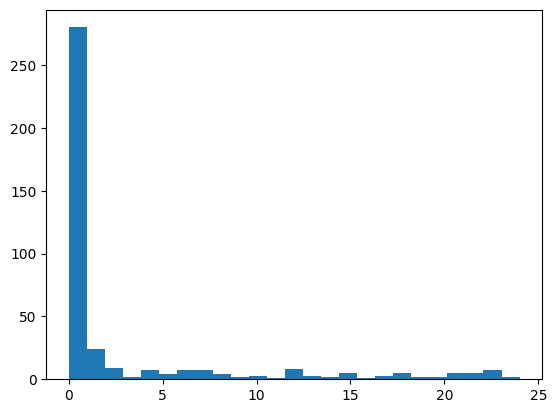

best_choice


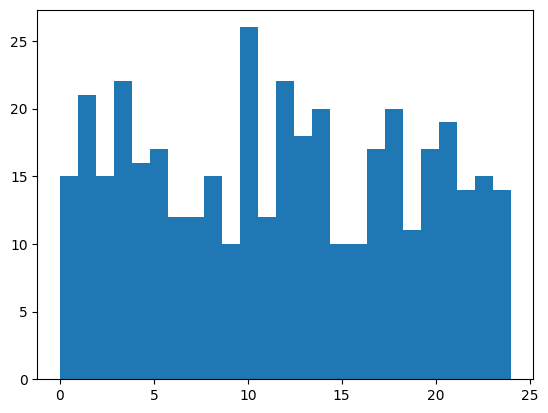

description-gpt


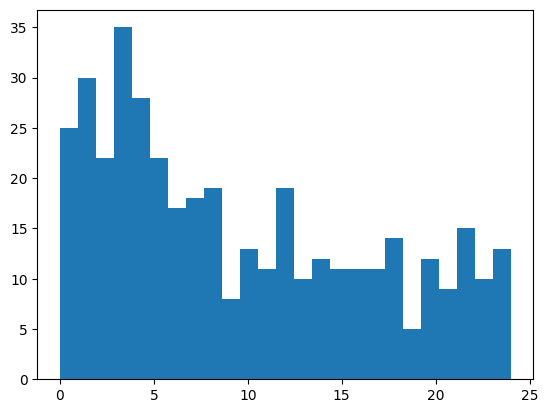

choices-gpt


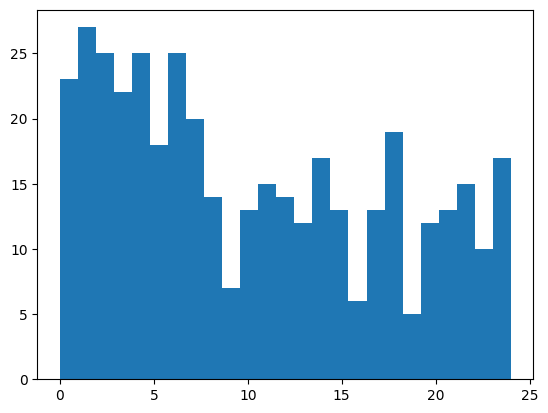

choices:3-gpt


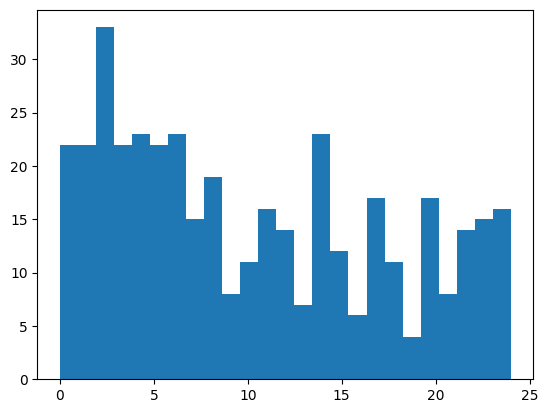

choices:5-gpt


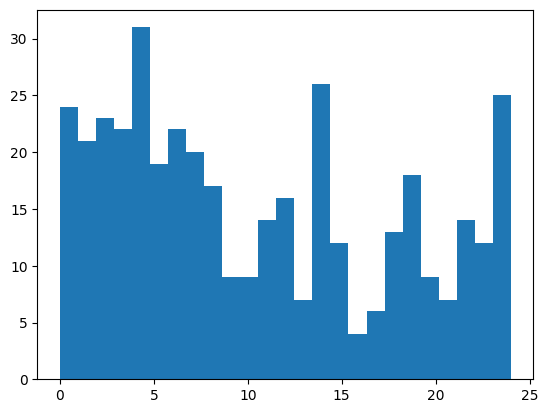

choices:8-gpt


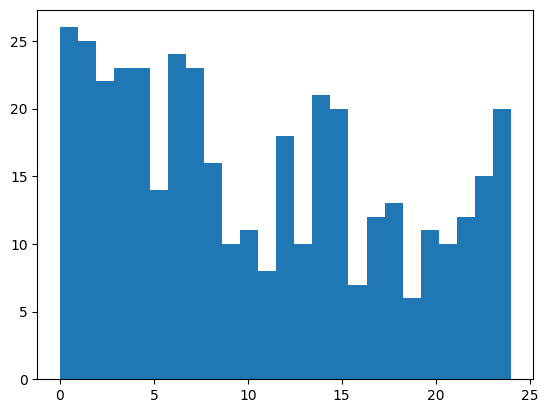

choice_list-gpt


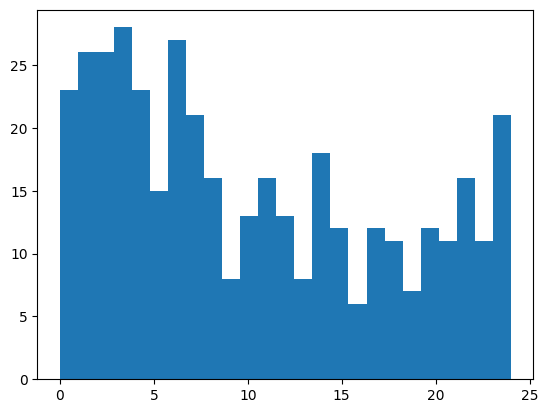

choice_list:3-gpt


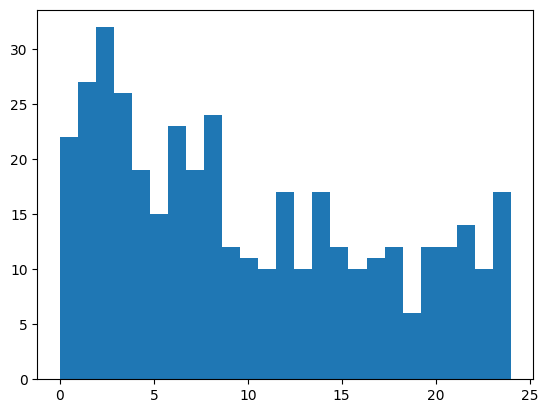

choice_list:5-gpt


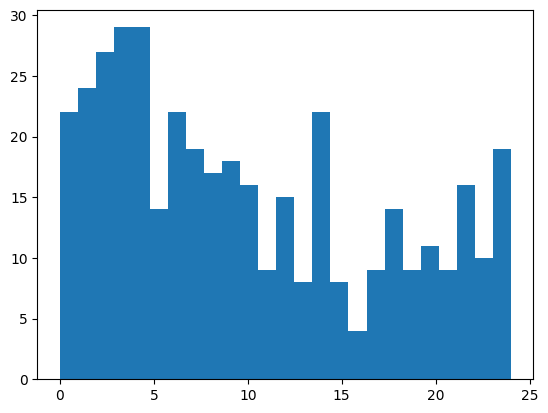

choice_list:8-gpt


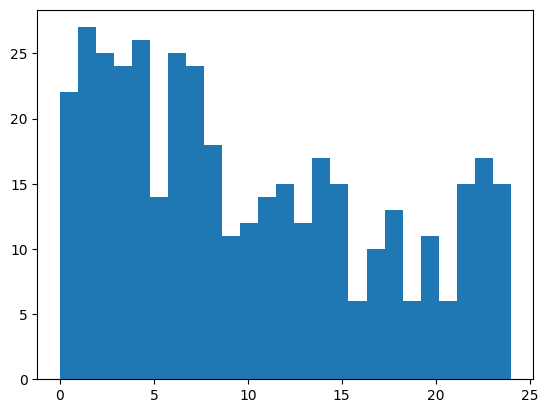

fullpaper-gpt


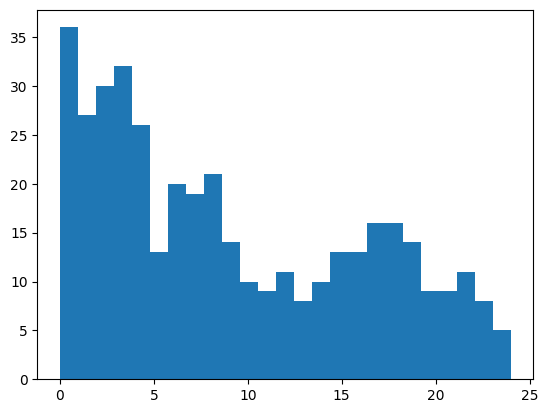

choices-llama


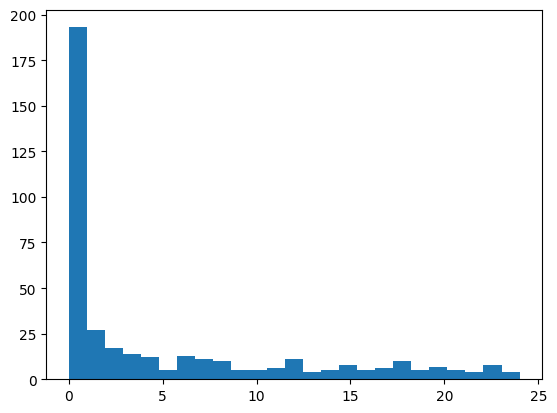

choices:3-llama


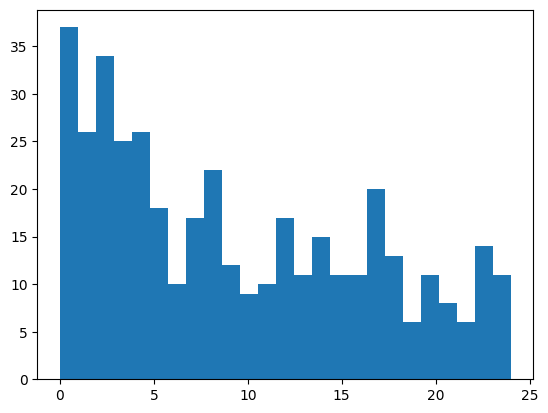

choices:5-llama


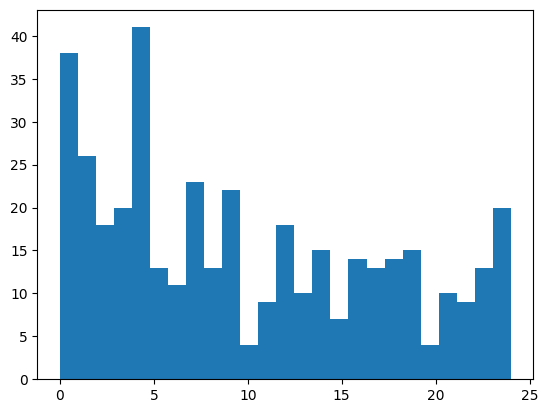

choices:8-llama


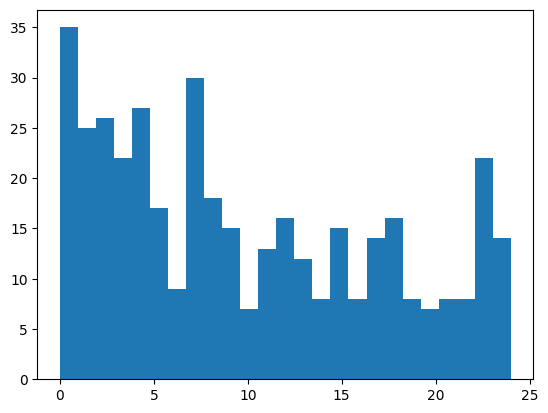

choice_list-llama


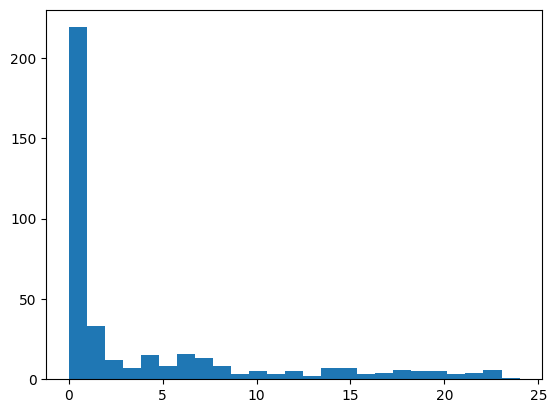

choice_list:3-llama


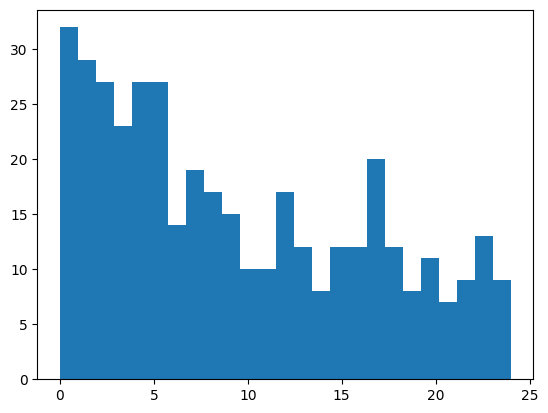

choice_list:5-llama


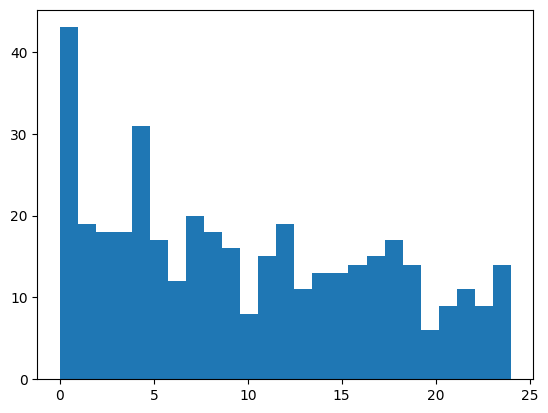

choice_list:8-llama


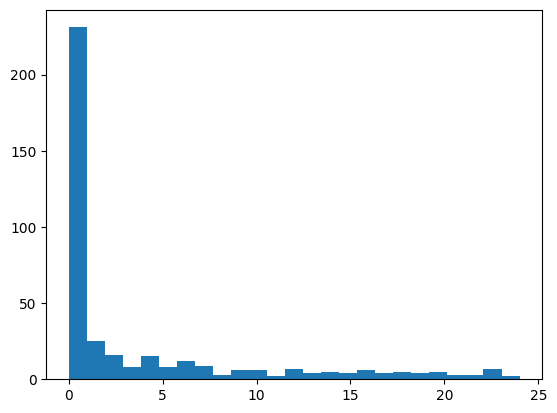

description-llama


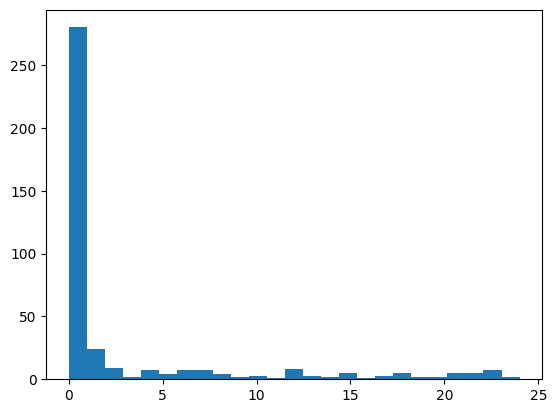

choices-mistral


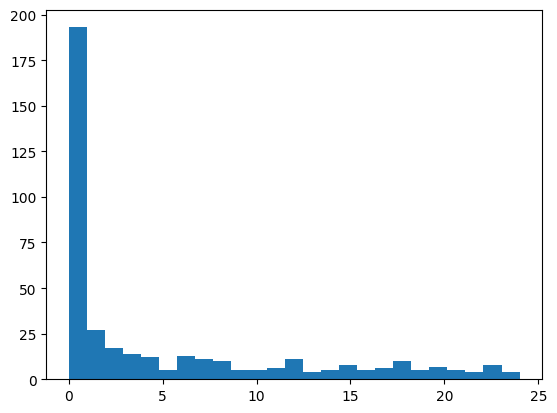

choices:3-mistral


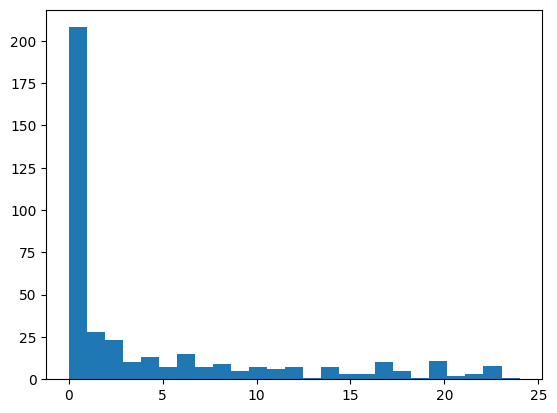

choices:5-mistral


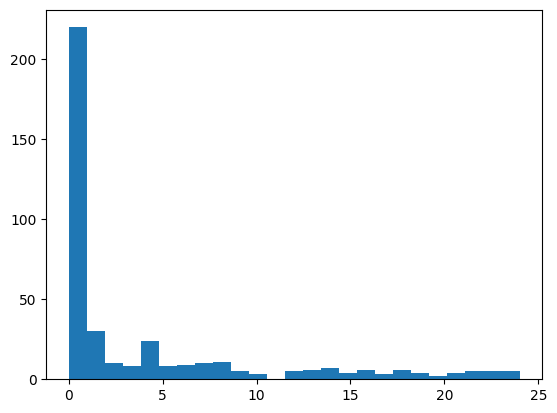

choices:8-mistral


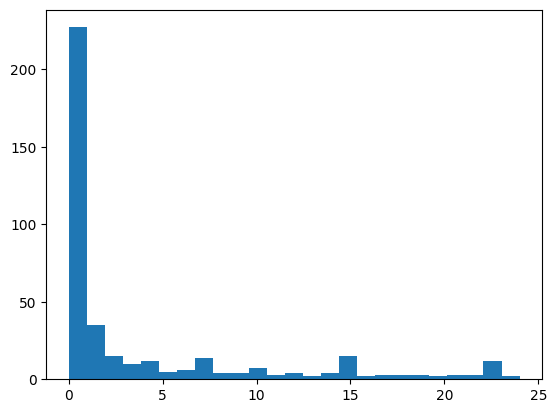

choice_list-mistral


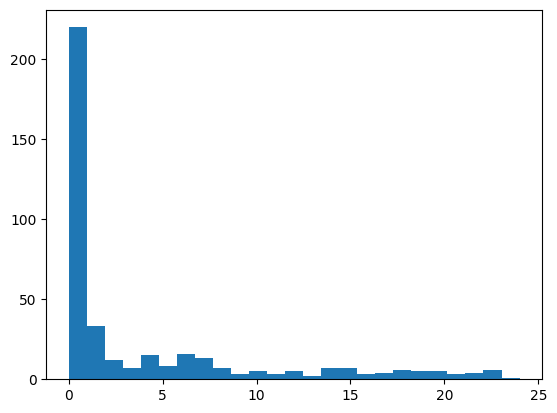

choice_list:3-mistral


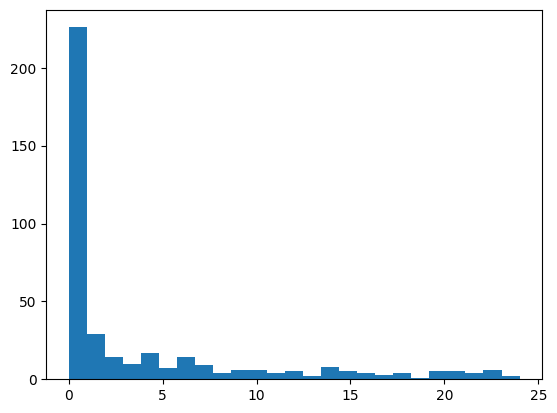

choice_list:5-mistral


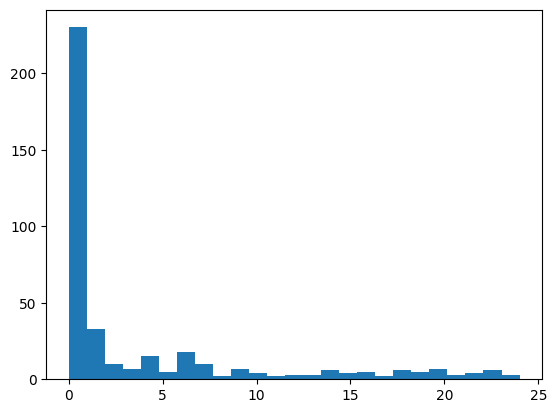

choice_list:8-mistral


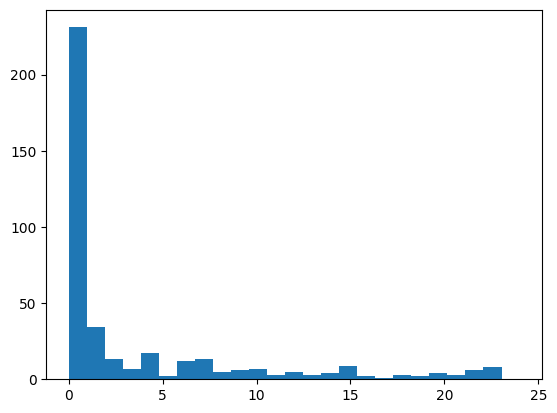

In [26]:
for argstring in index_data:
    label_counts = np.zeros(25)
    pred_counts = np.zeros(25)
    for val in label_idx[argstring]:
        label_counts[val] += 1
    for val in pred_idx[argstring]:
        pred_counts[val] += 1
        
    print(shortnames_by_argstring[argstring])
    #plt.plot(pred_counts/label_counts, "x")
    #plt.show()

    #plt.hist(x=list(range(25)), weights=pred_counts/label_counts, bins=25)
    plt.hist(x=list(range(25)), weights=pred_counts, bins=25)
    plt.show()
    


# Choices

now we plot number of times each answer was predicted, as well as the distribution of correct answers.

This is done for each field, for each model/setup, so there is a lot of plots.

the blue is the distribution of correct answers, the orange the predicted ones. Good prediction should overlap the blue plot.

This gives a way of checking if the generation model prefers certain answers. If, for example, one of the answers is a much more common word, the model might have an artificially high probability of choosing that answer. But it seems they are quite evenly destrivbuted in most cases.


some mentionable takeaways are
- best_choice has a high preference for certain answers. I guess this means the embeddings of these answers are closer to a typical chunk of text, whatever that means?
- in organism_part, "peripheral blood" is choosen way to often, and "blood" way to rarely (for all models). A possible explanation is semantic overlap among the labels - many of the cases labeled blood could have been labeled peripheral blood, and vice versa, and the models prefer the more specific variant when appropriate.
  - for gpt, the majority of the errors in this field comes from these two answers, indicating that gpt is likely better than the numbers indicate (i.e. labels are not (much) more accurate than predictions)
- gpt does not seem to have a big preference for certain words.
- llama and mistral really prefers certain words, e.g. spleen for organism part, certain designs types and one hardware choice. This really hinders performance. Perhaps chaging decoding (e.g. temperature, or n_beams for beam search) could help.
  - for some reason, "choices-mistral" does not prefer spleen like the other versions


description-mistral


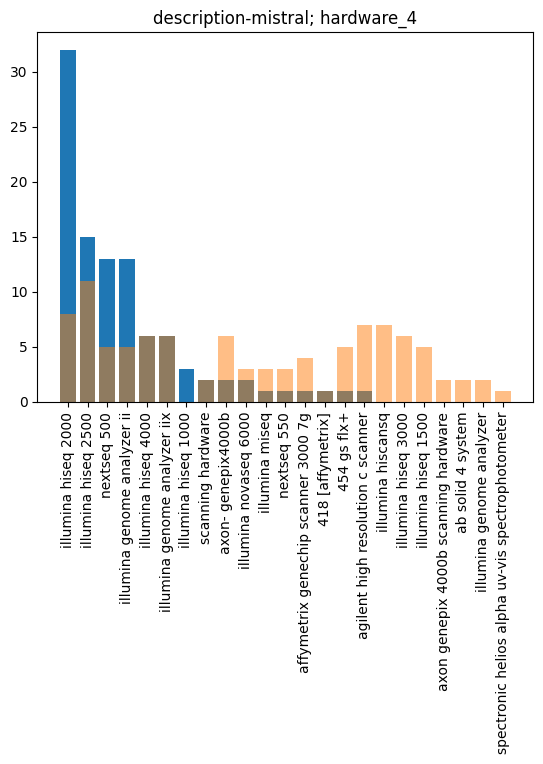

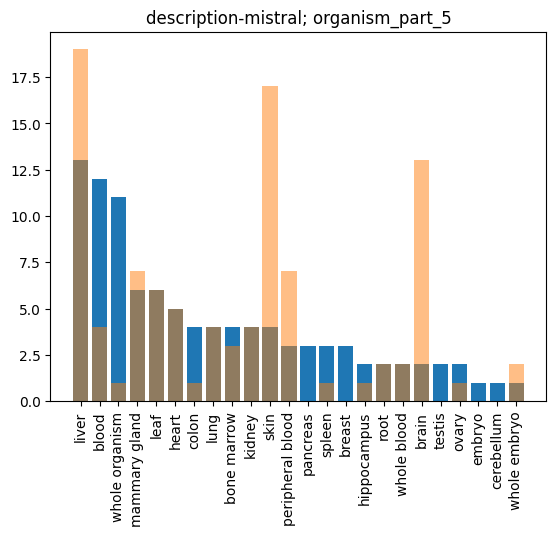

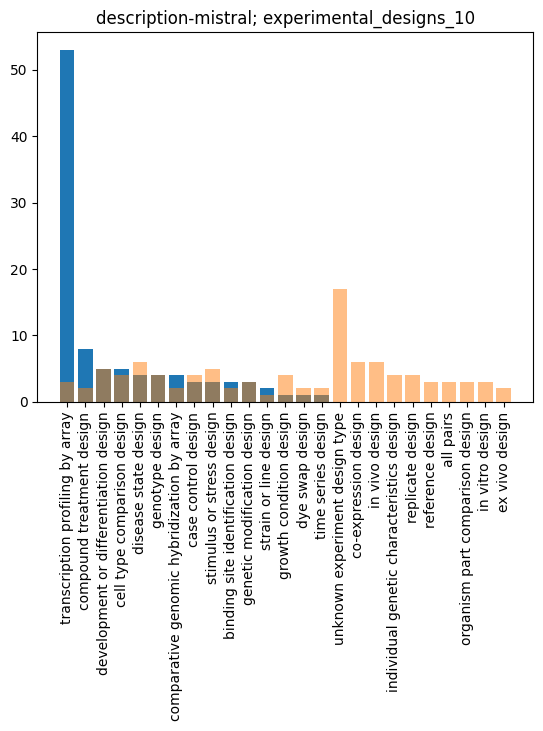

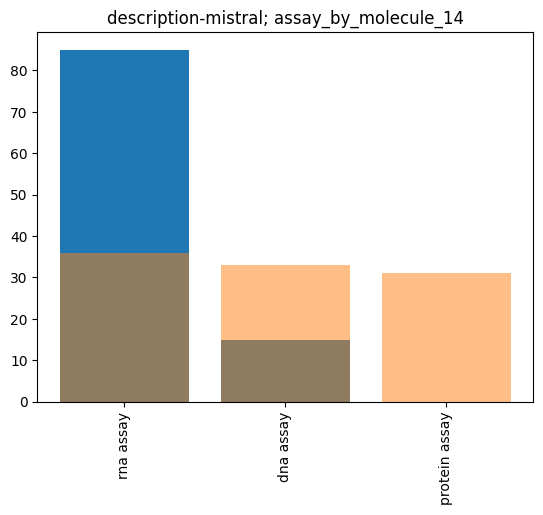

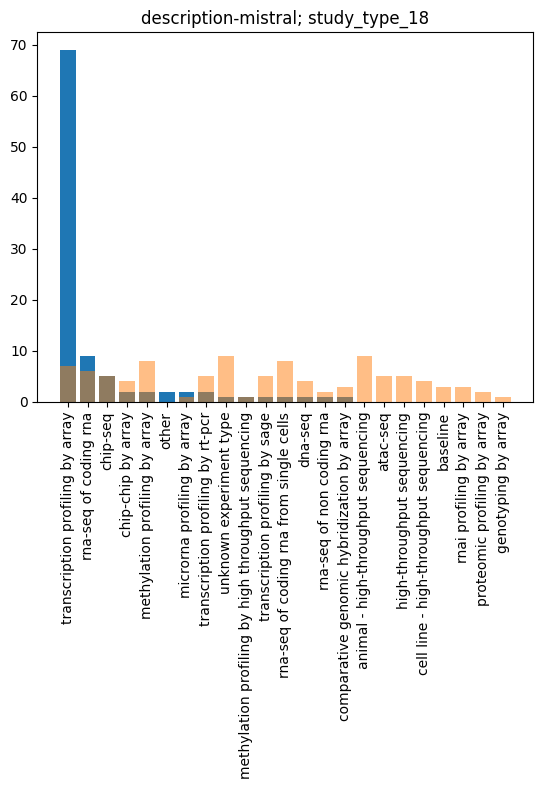

best_choice


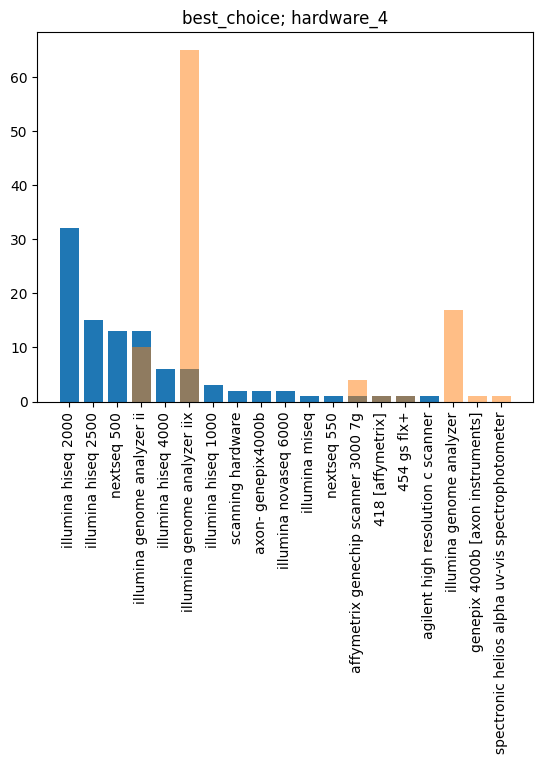

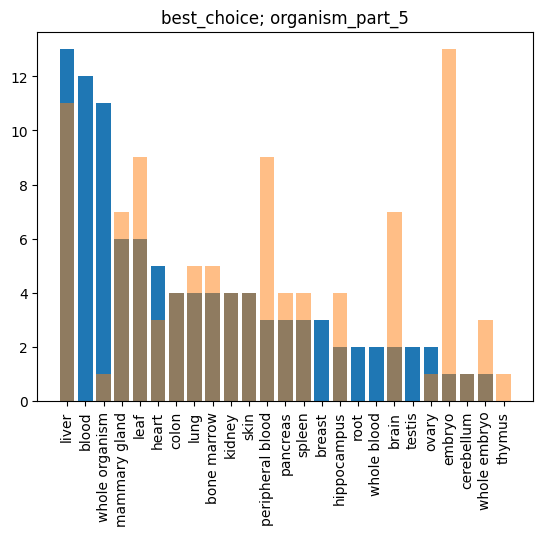

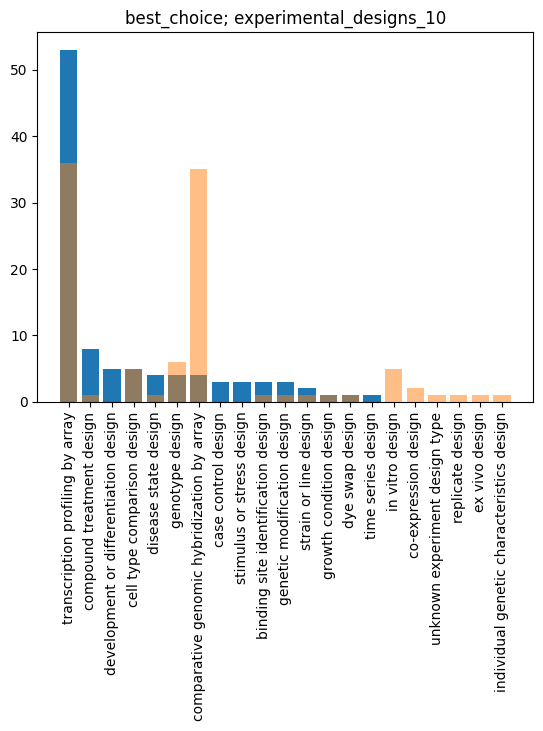

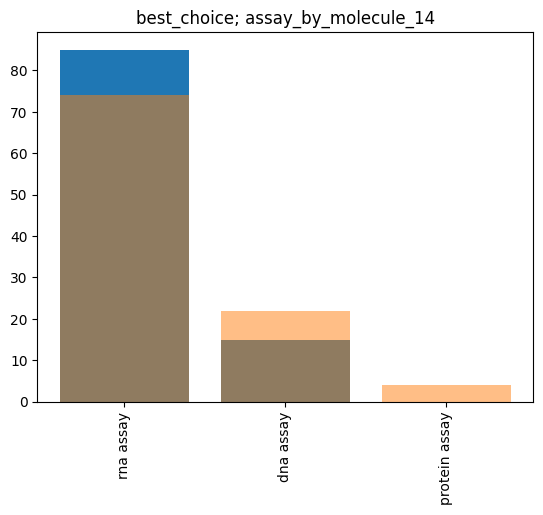

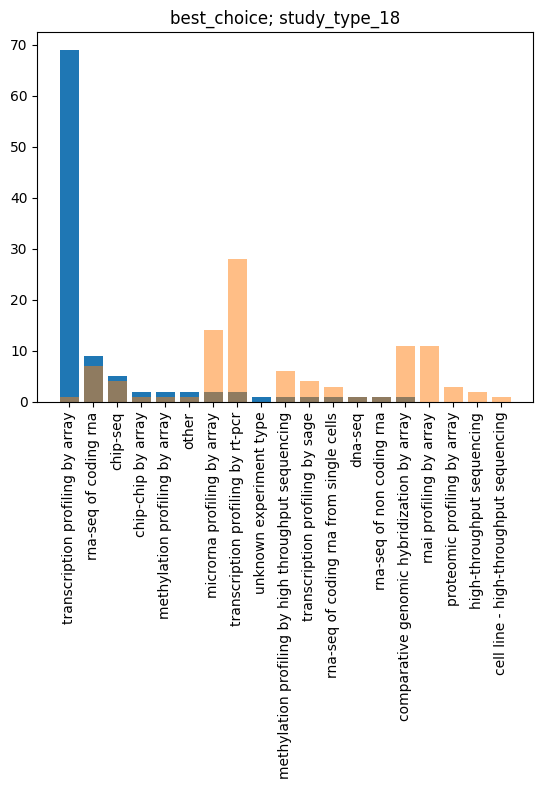

description-gpt


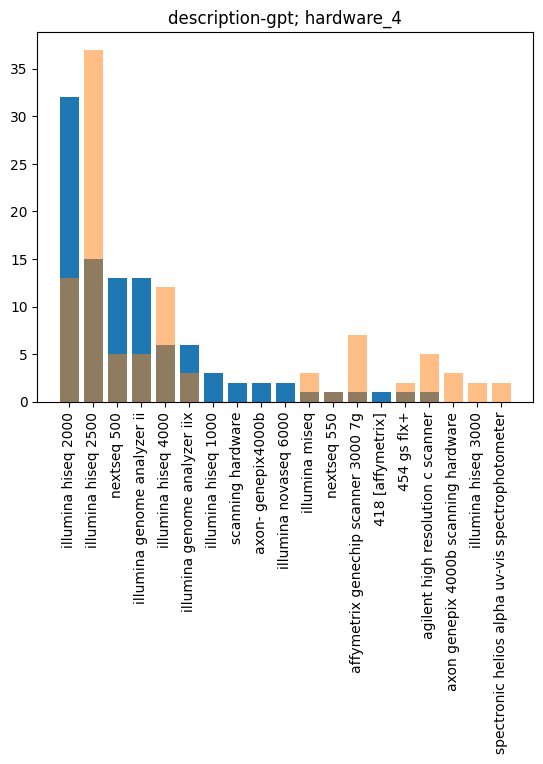

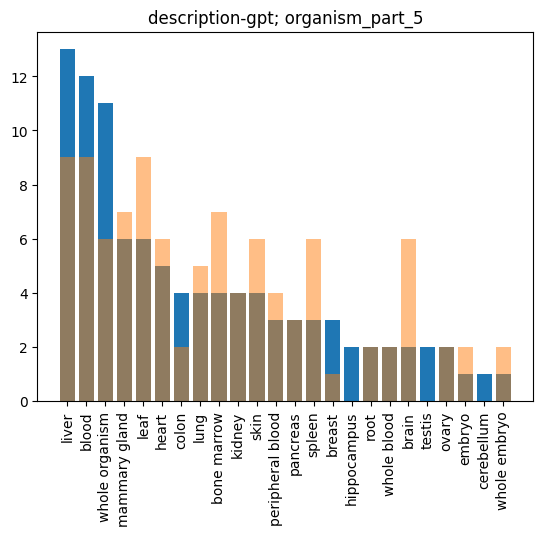

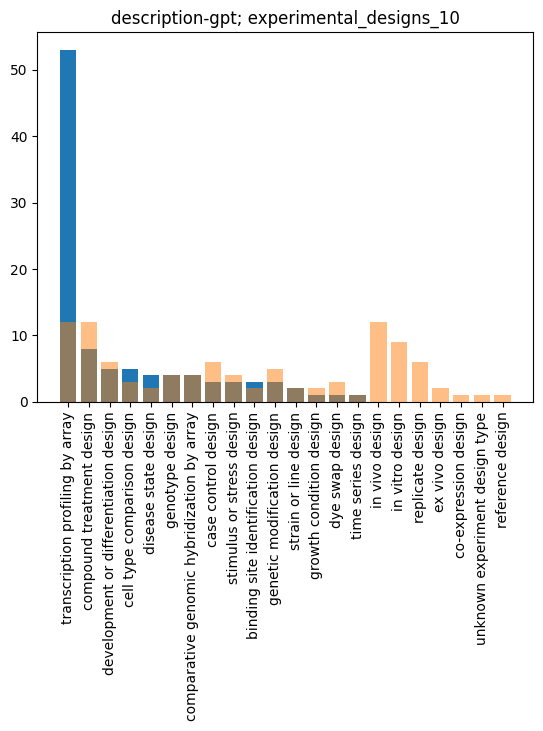

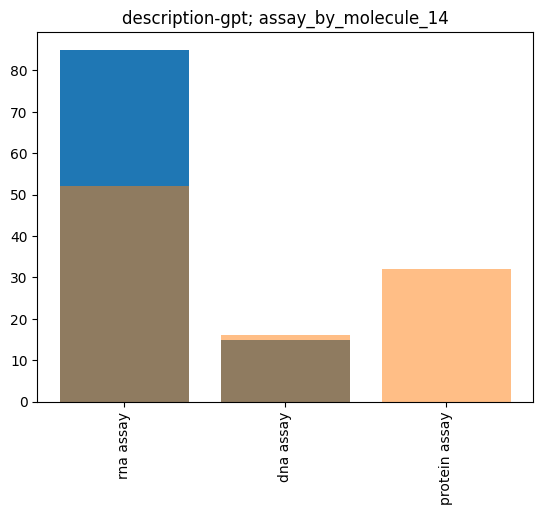

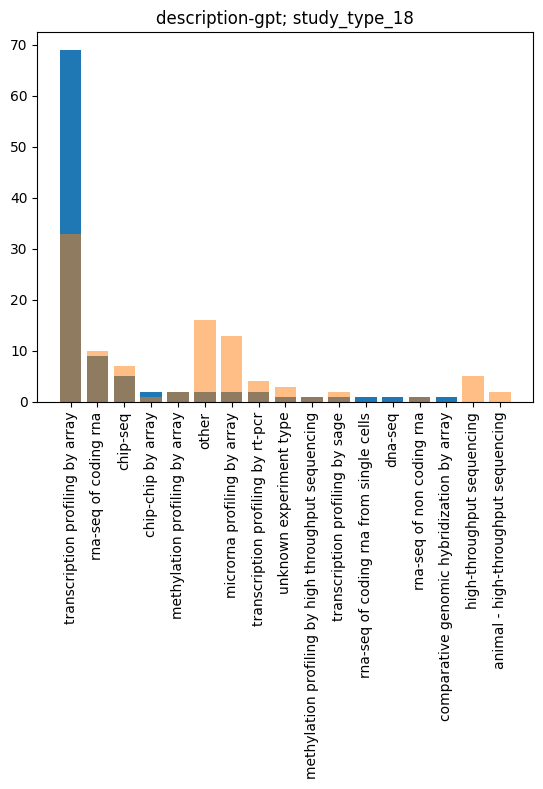

choices-gpt


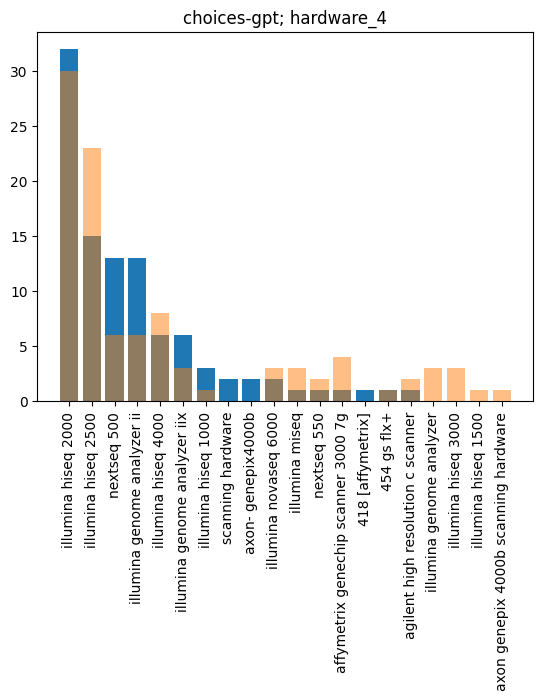

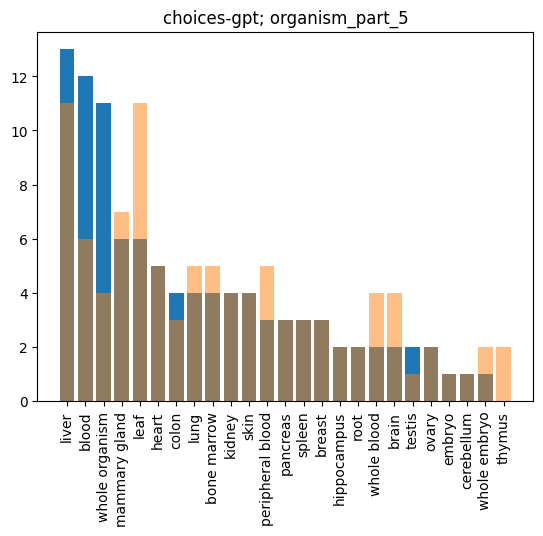

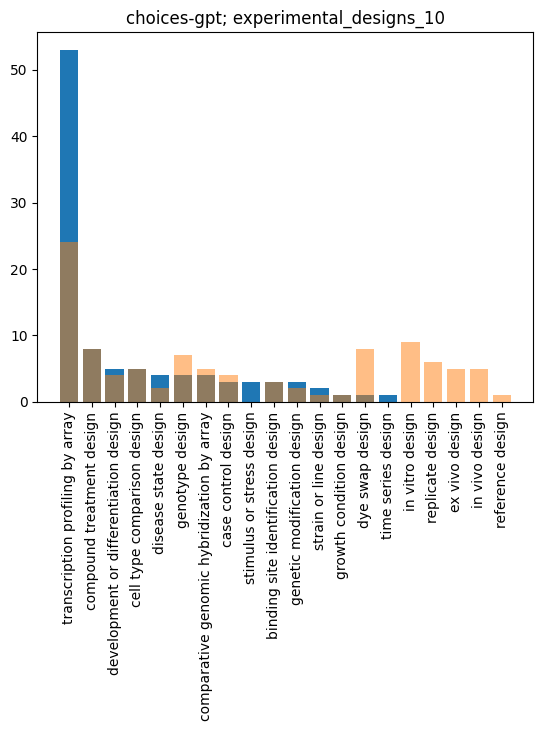

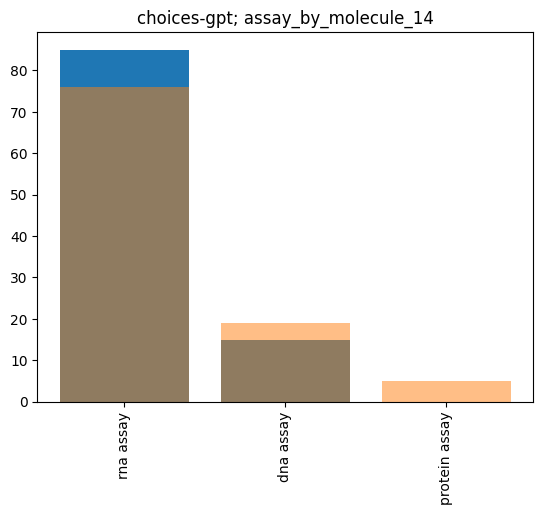

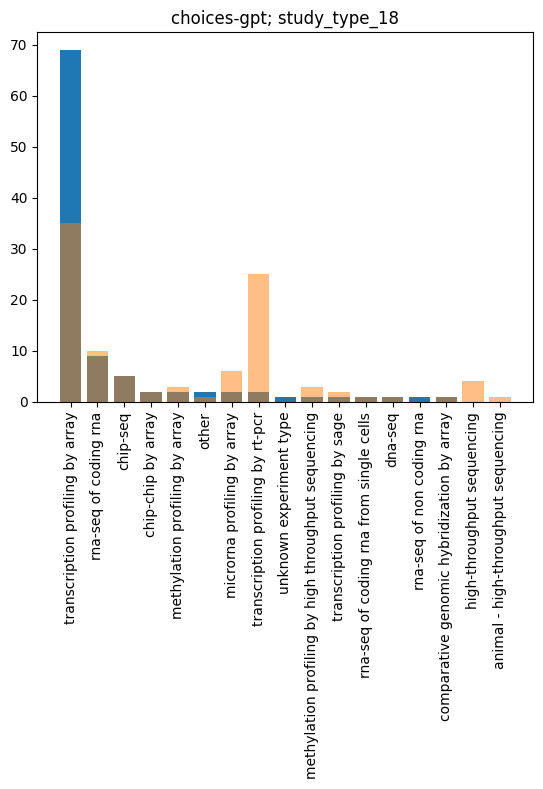

choices:3-gpt


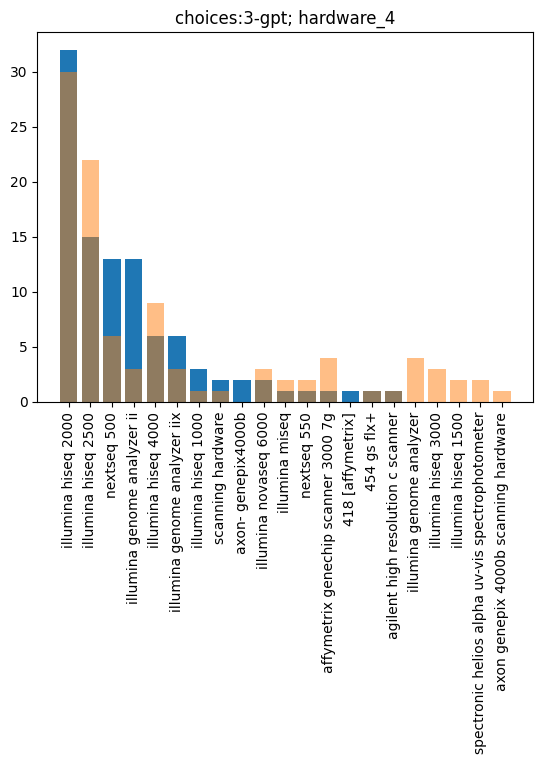

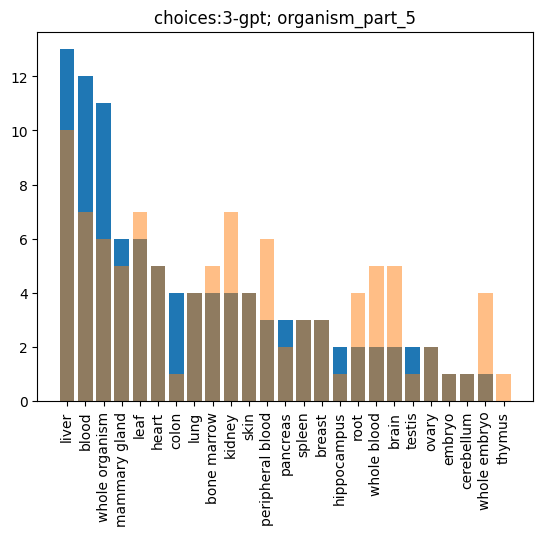

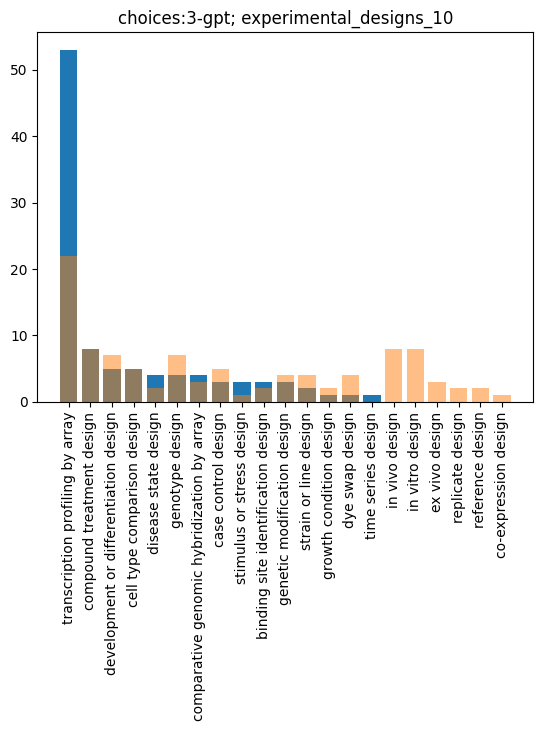

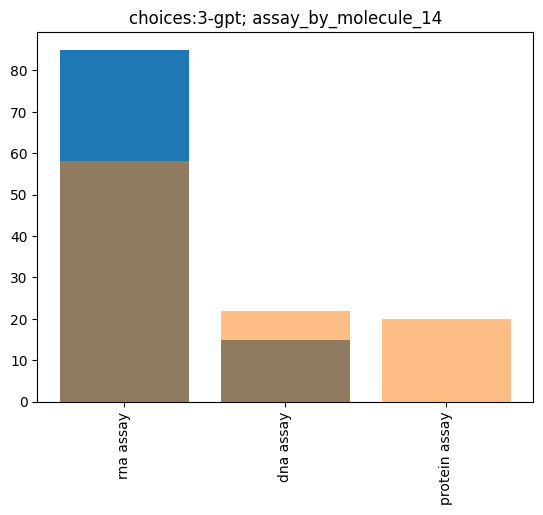

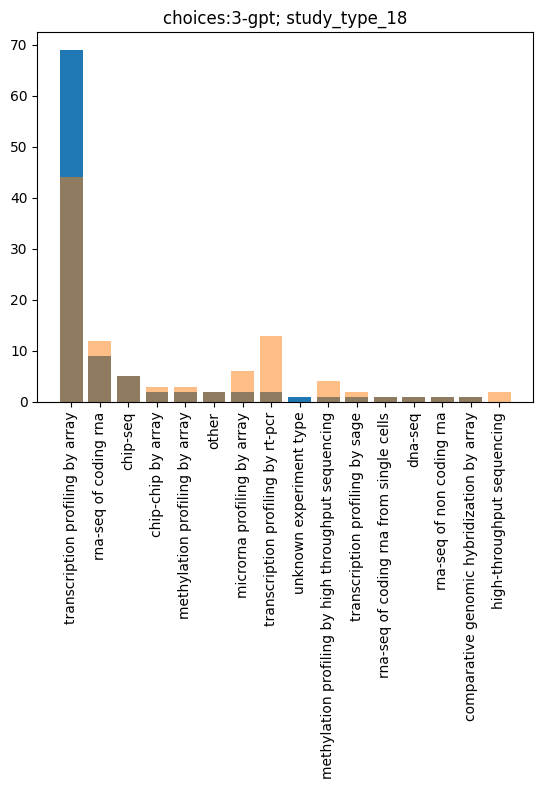

choices:5-gpt


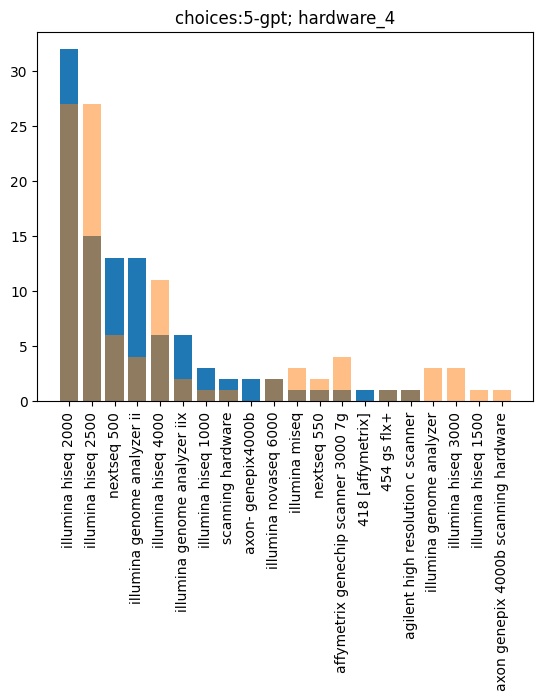

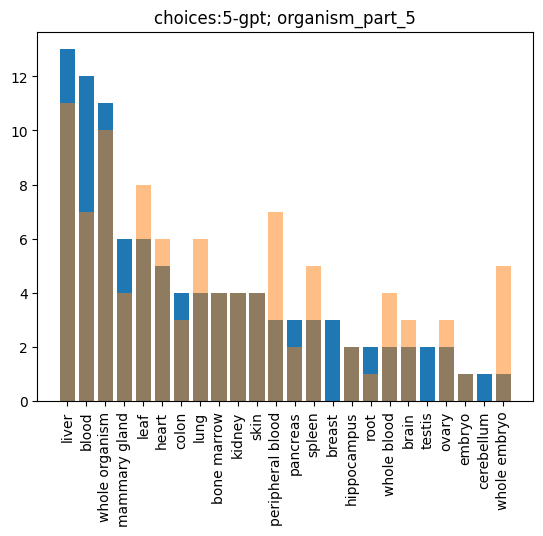

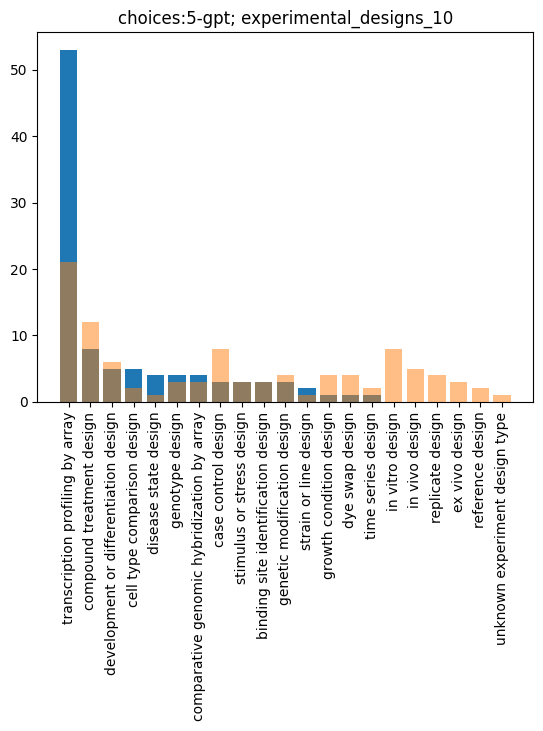

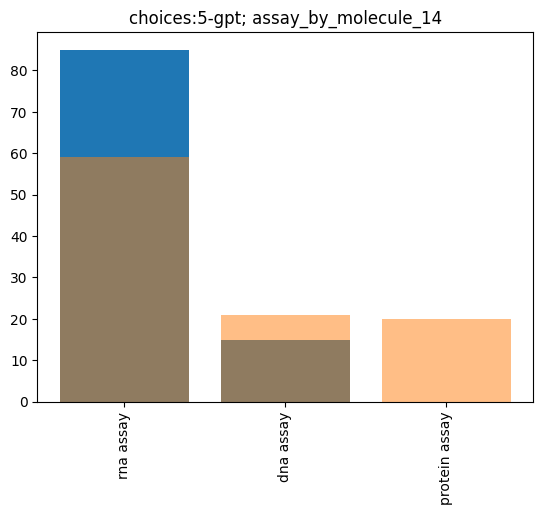

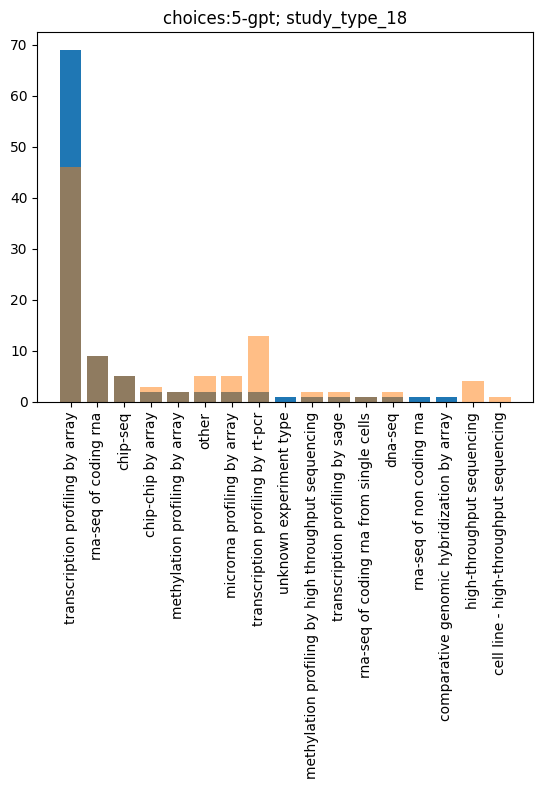

choices:8-gpt


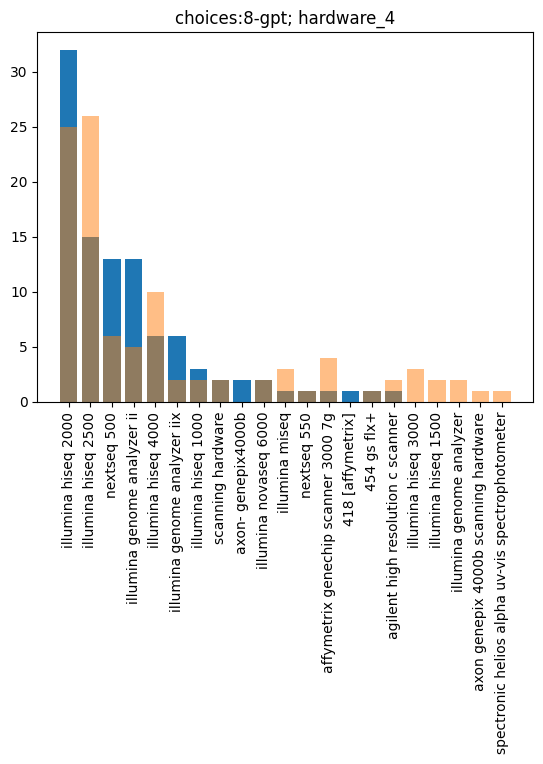

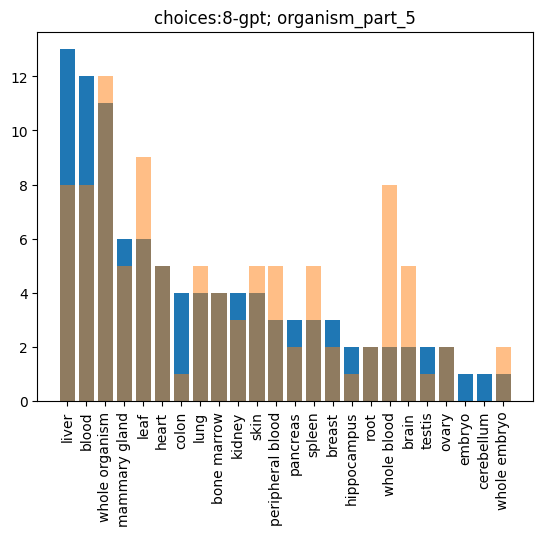

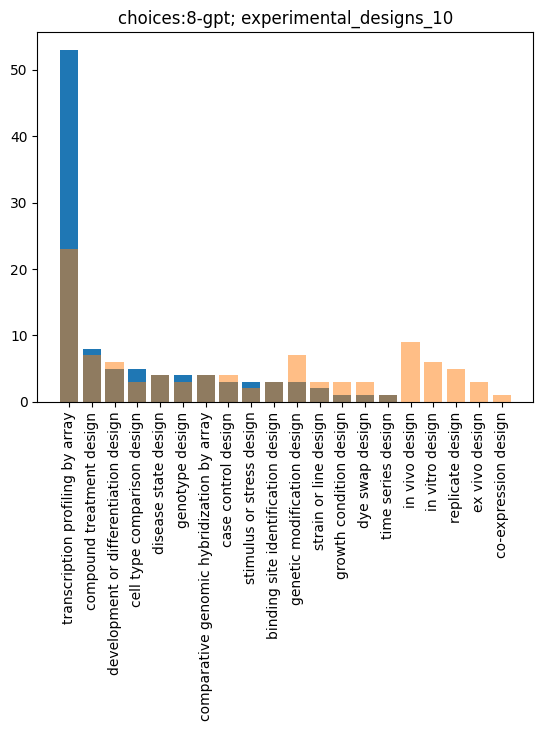

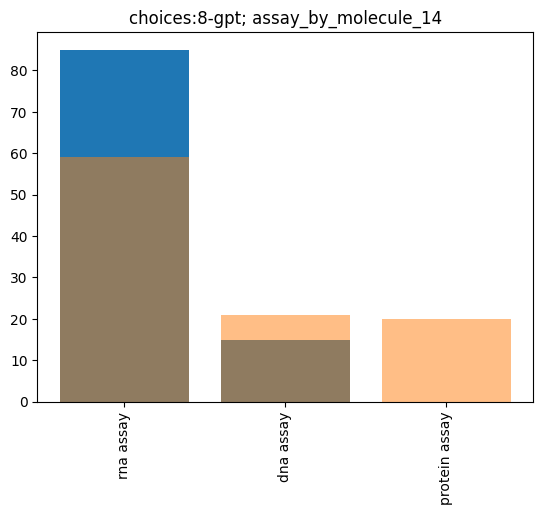

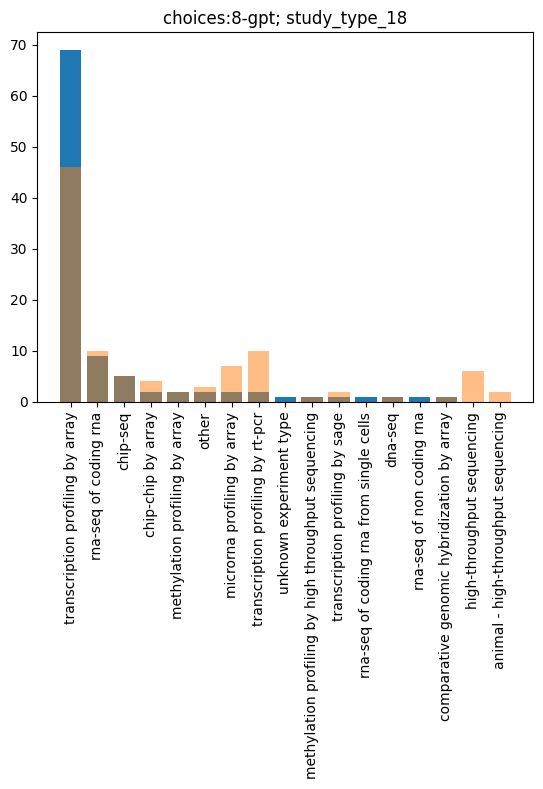

choice_list-gpt


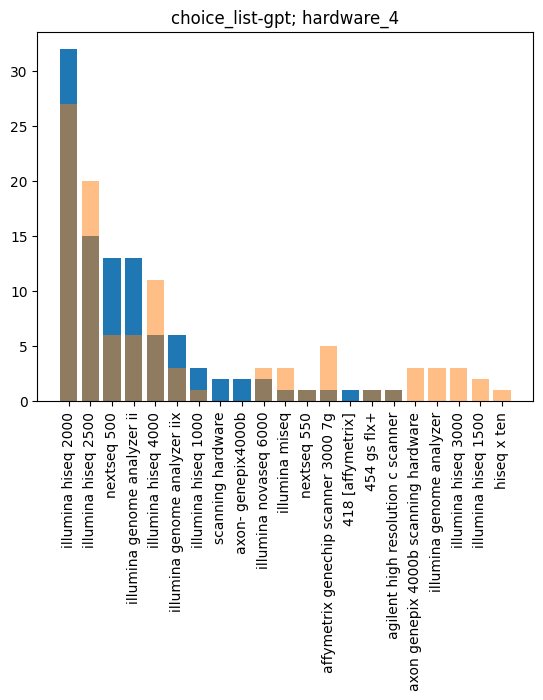

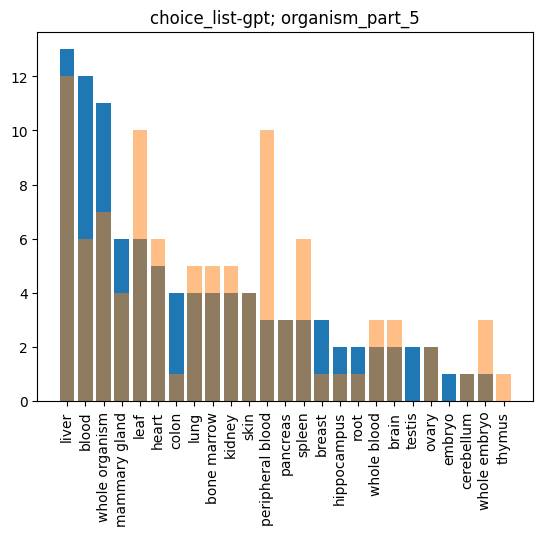

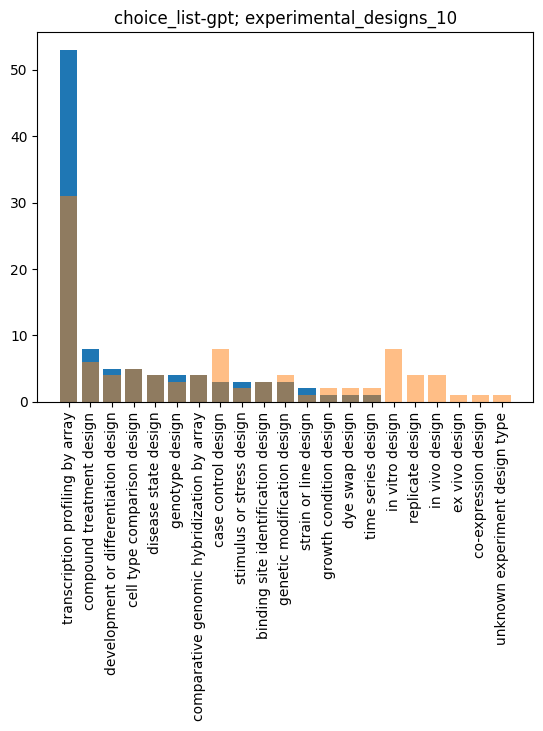

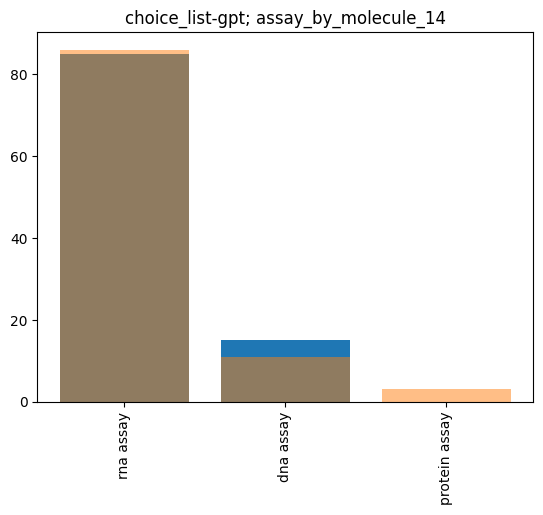

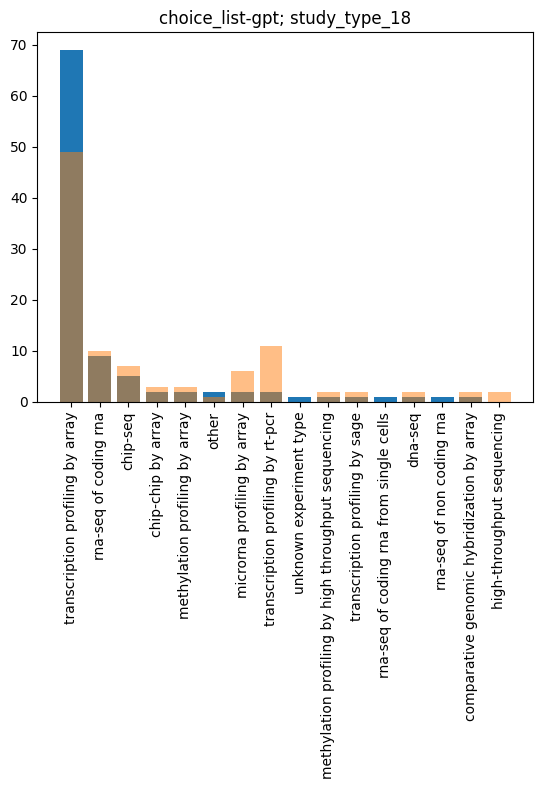

choice_list:3-gpt


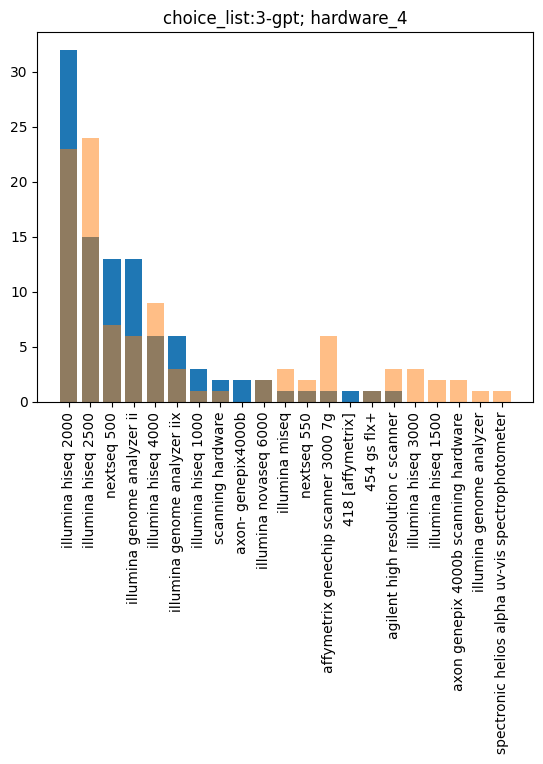

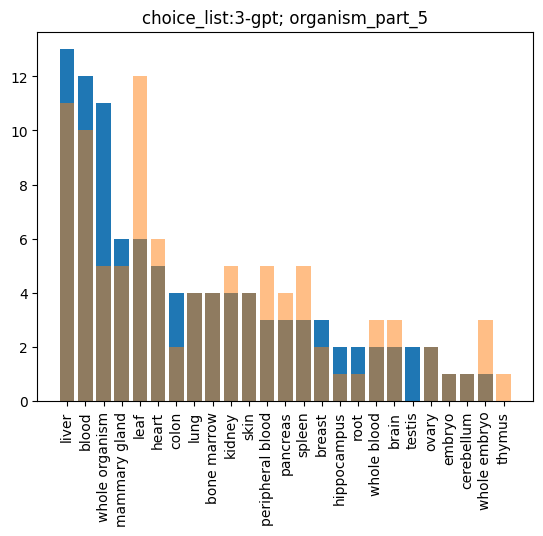

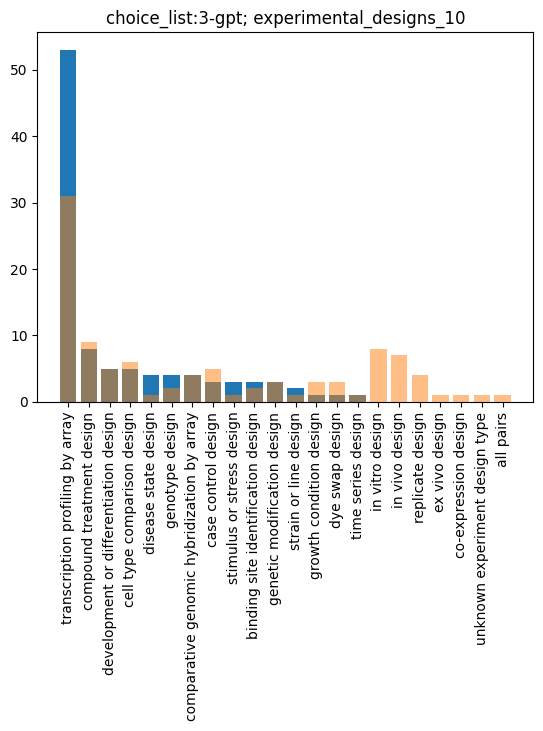

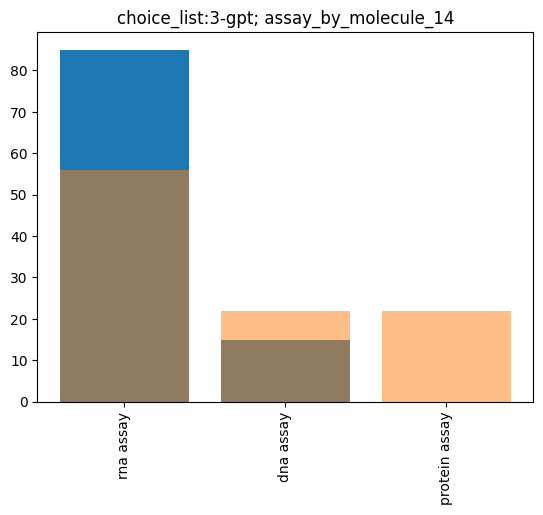

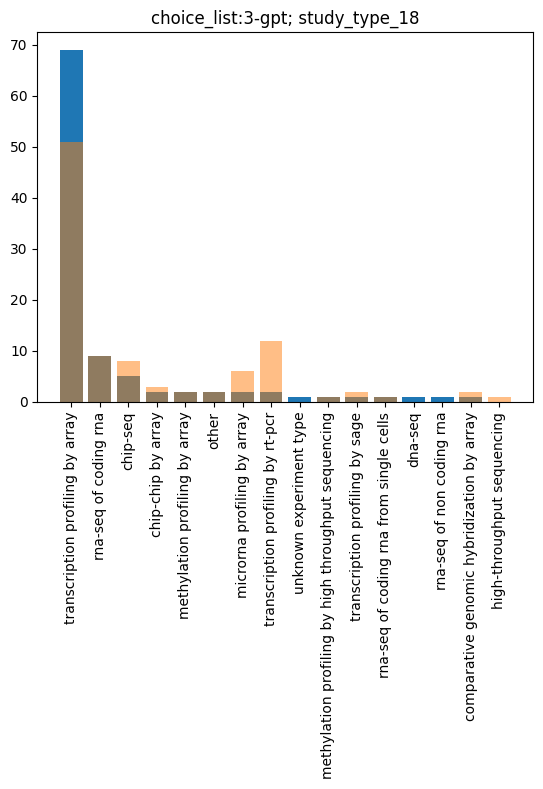

choice_list:5-gpt


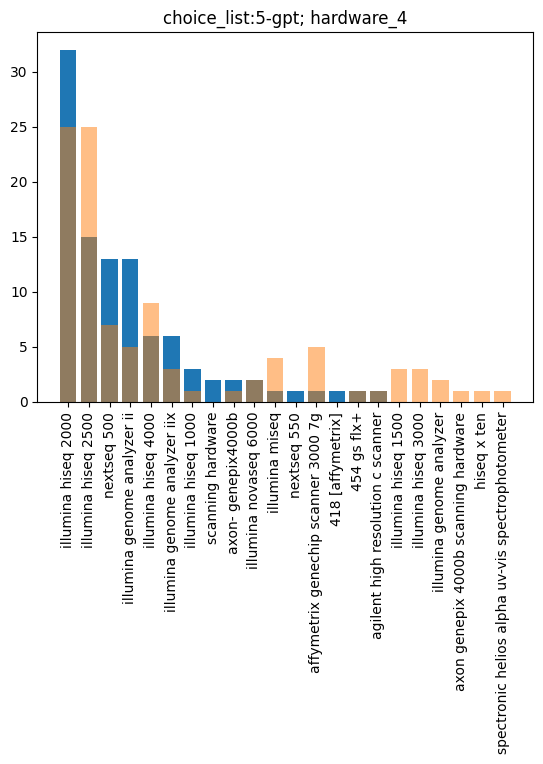

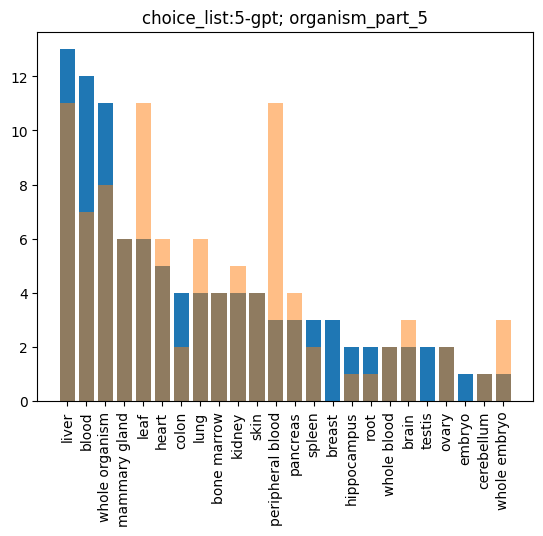

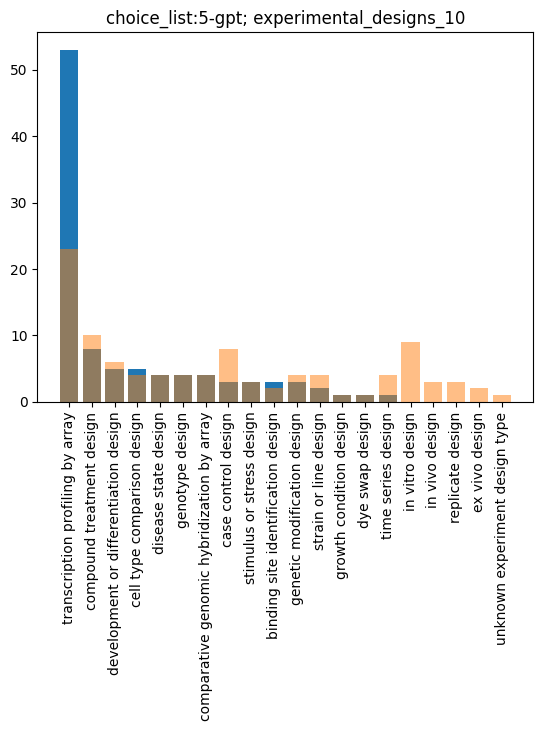

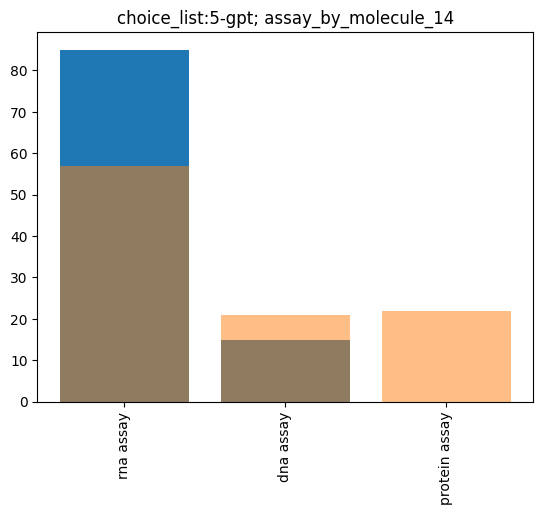

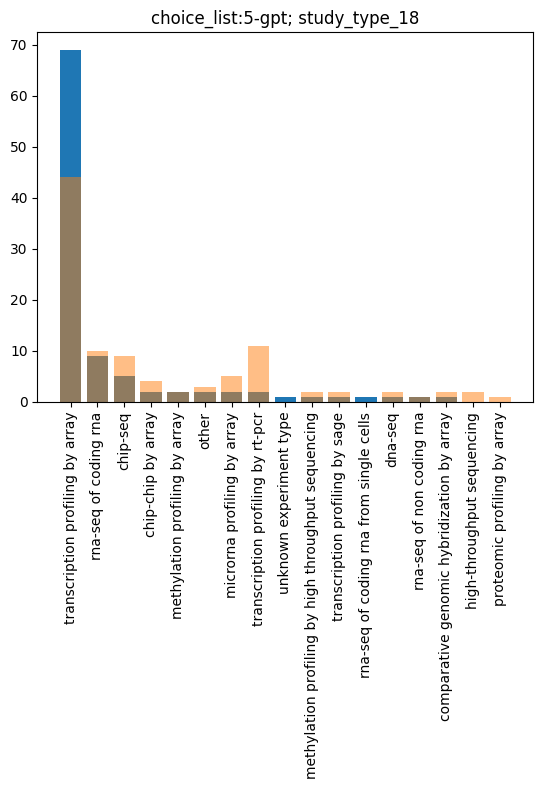

choice_list:8-gpt


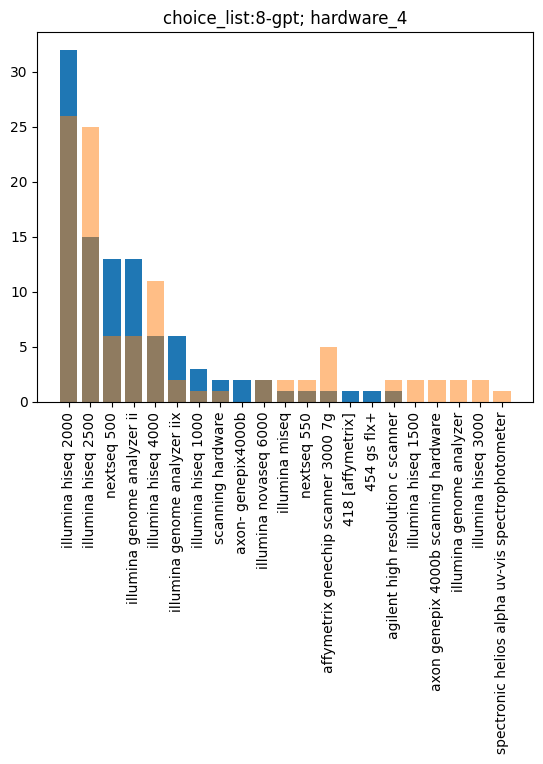

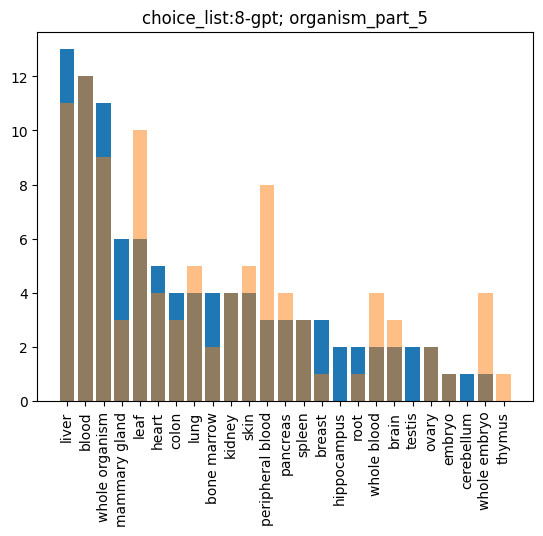

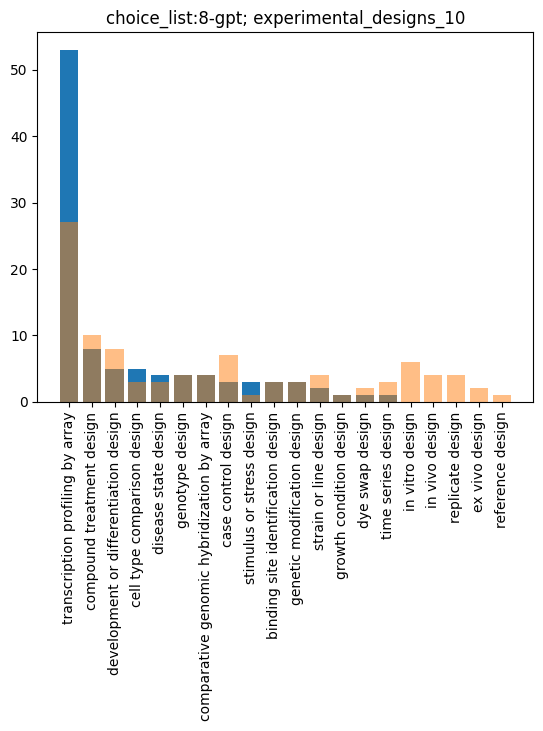

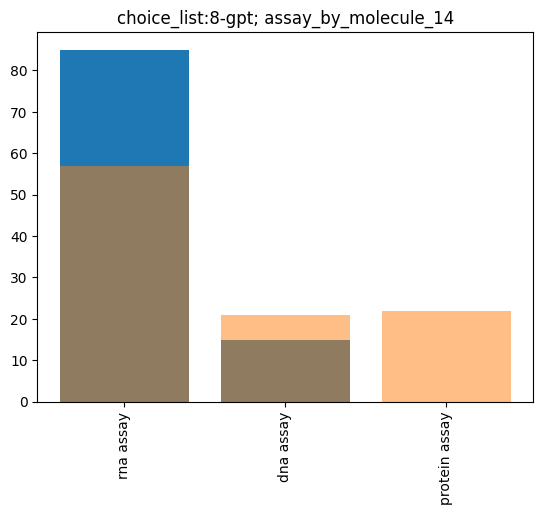

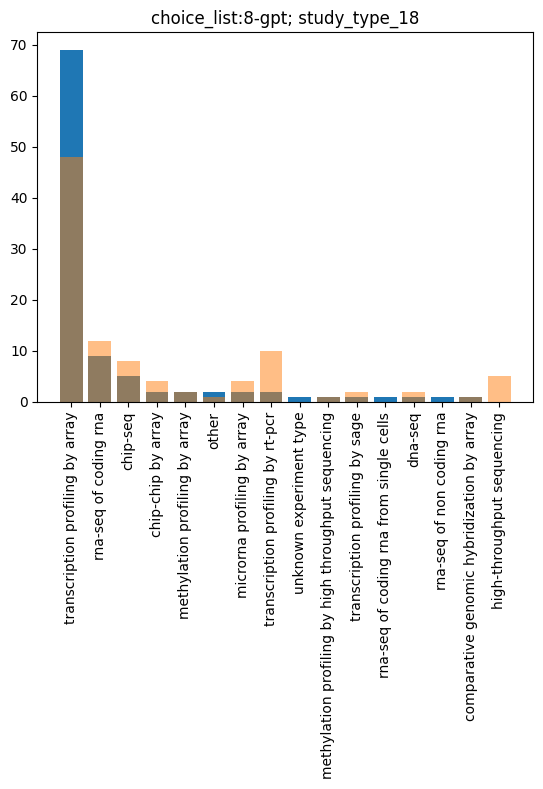

fullpaper-gpt


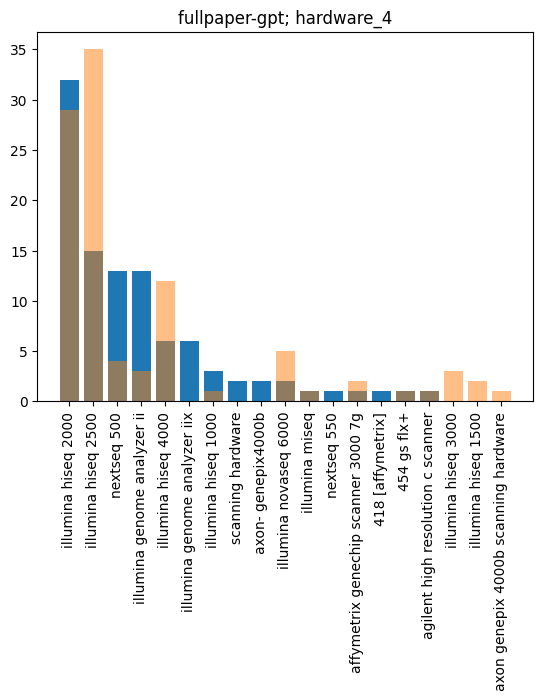

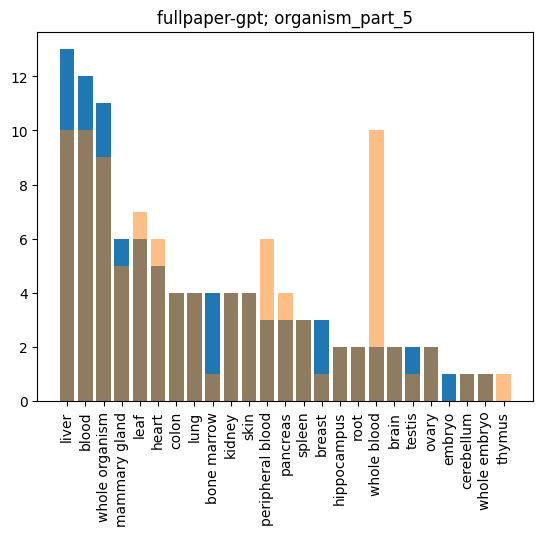

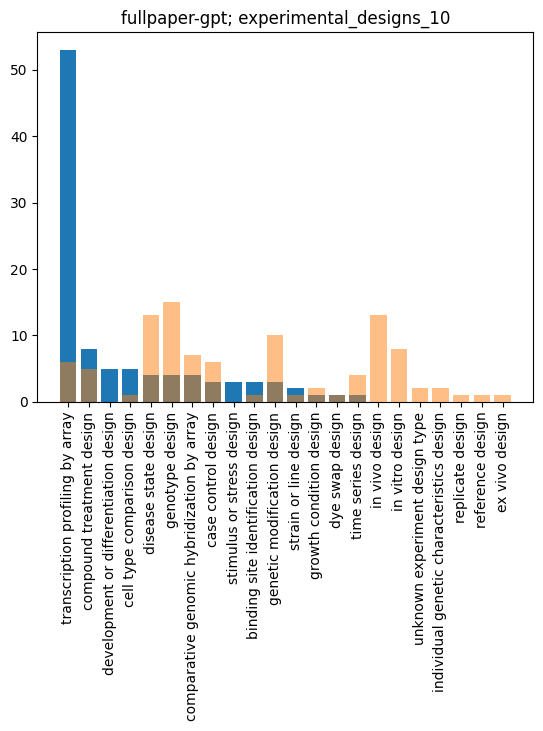

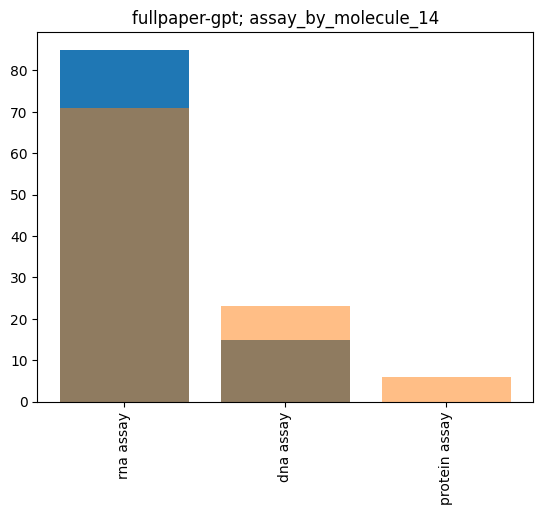

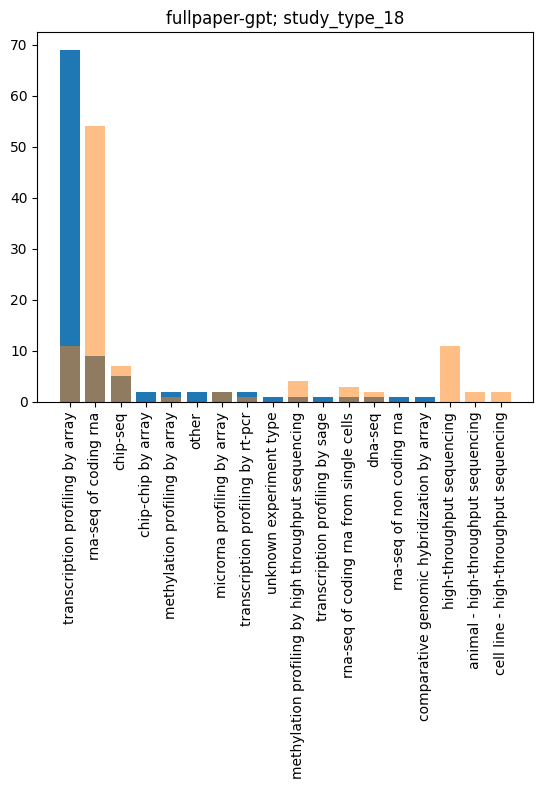

choices-llama


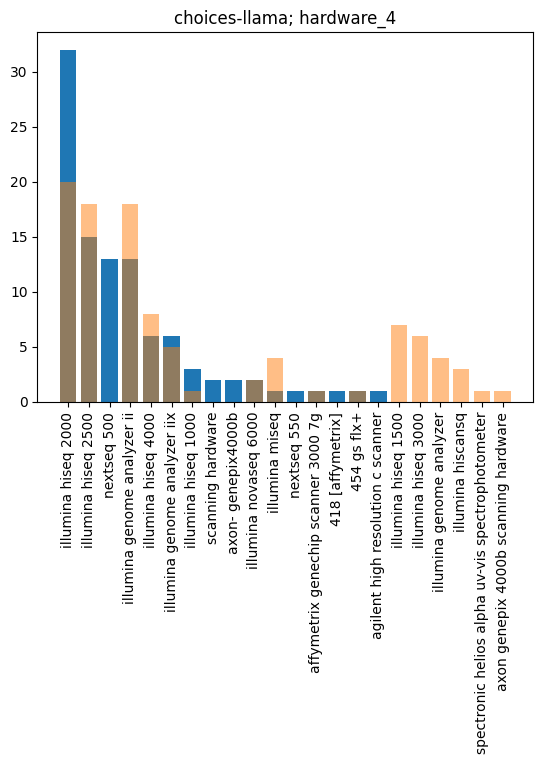

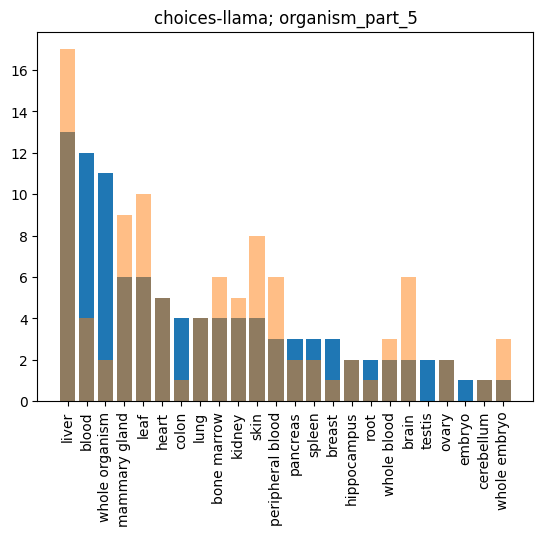

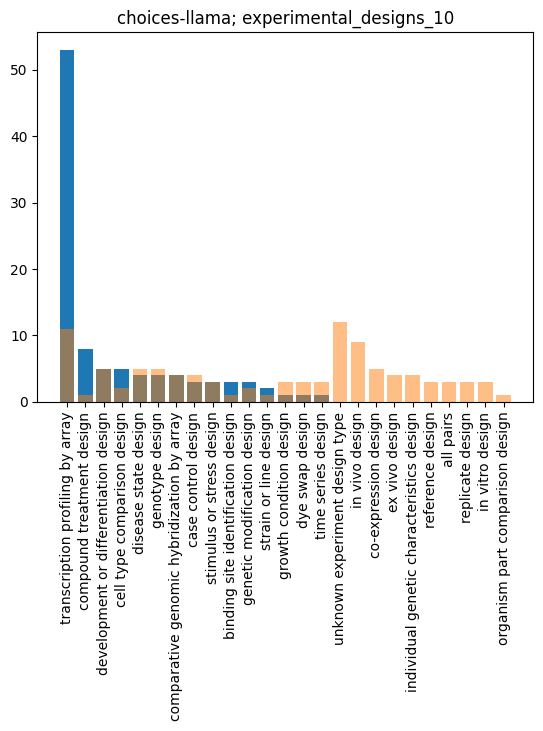

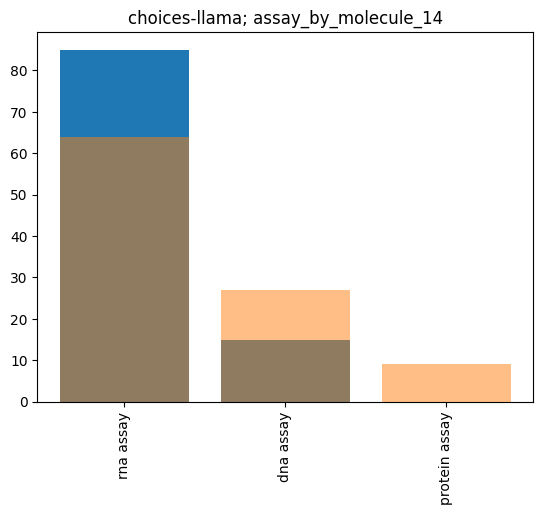

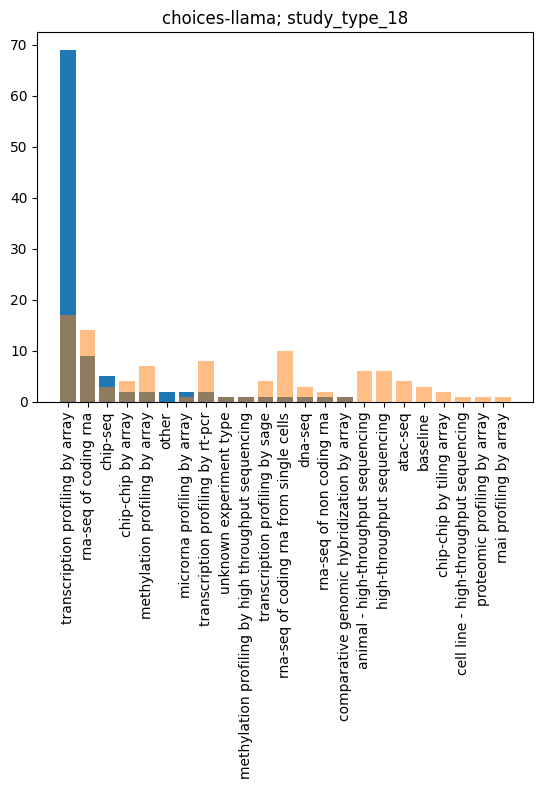

choices:3-llama


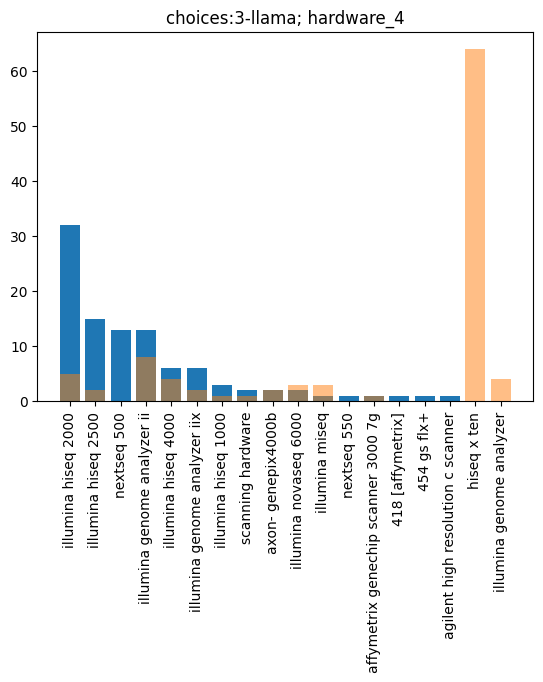

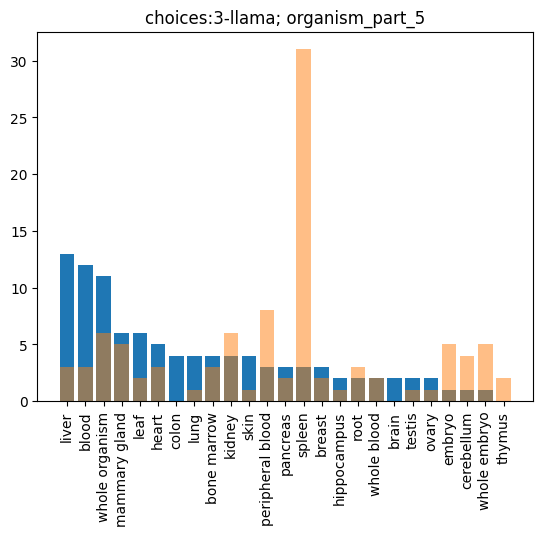

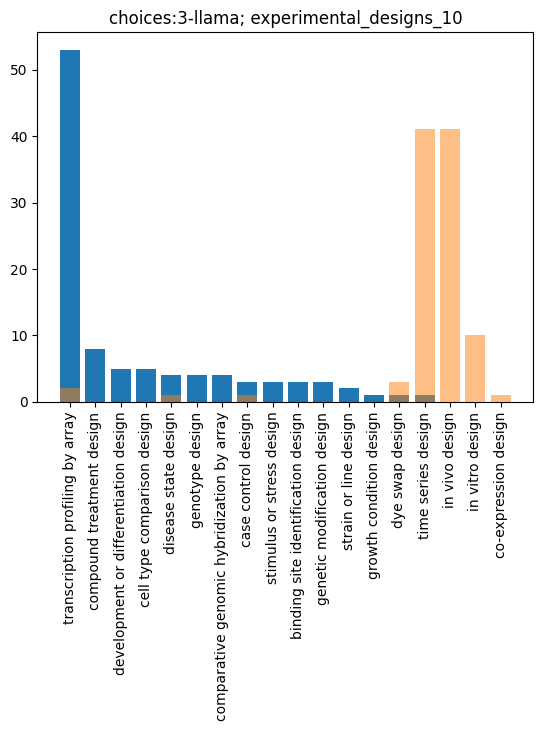

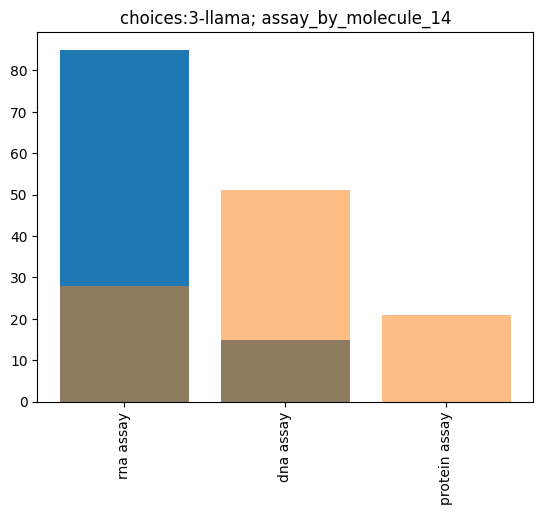

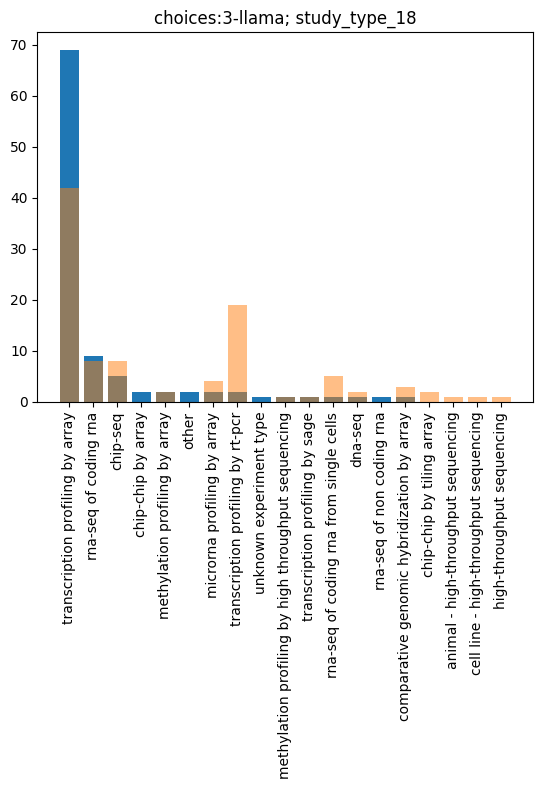

choices:5-llama


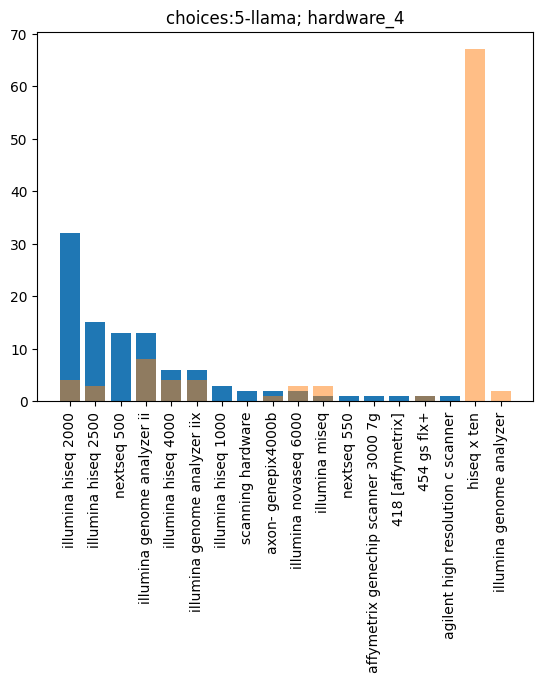

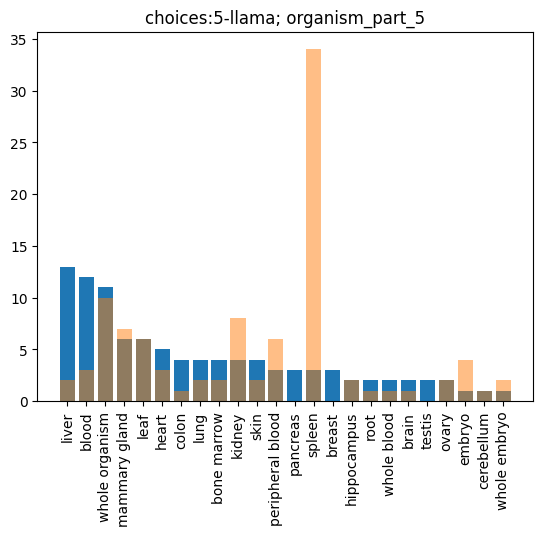

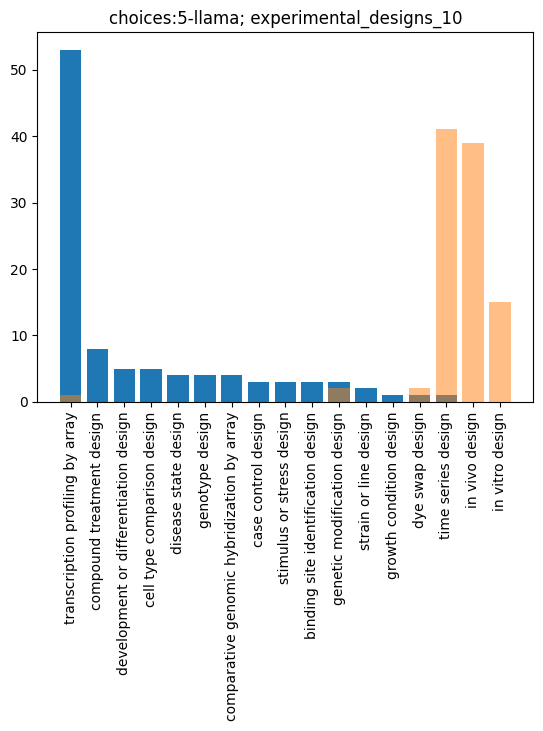

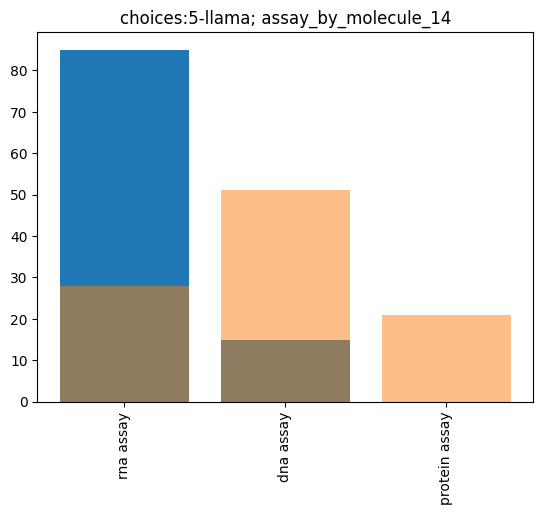

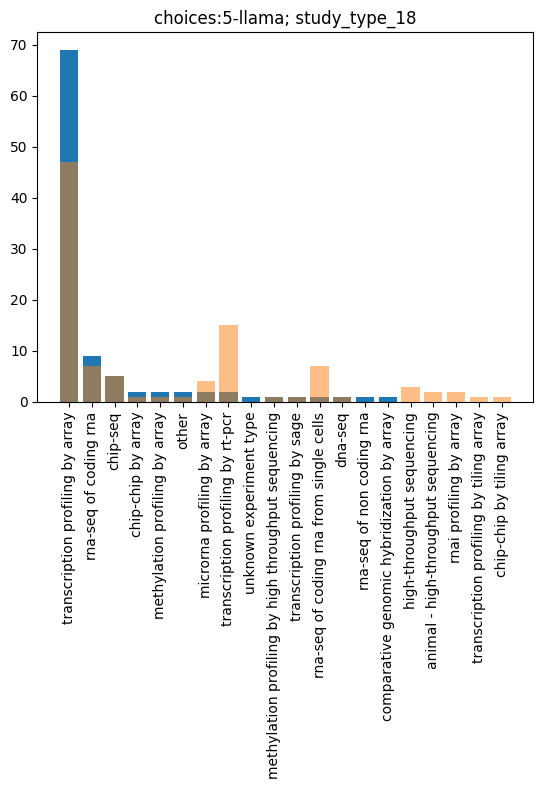

choices:8-llama


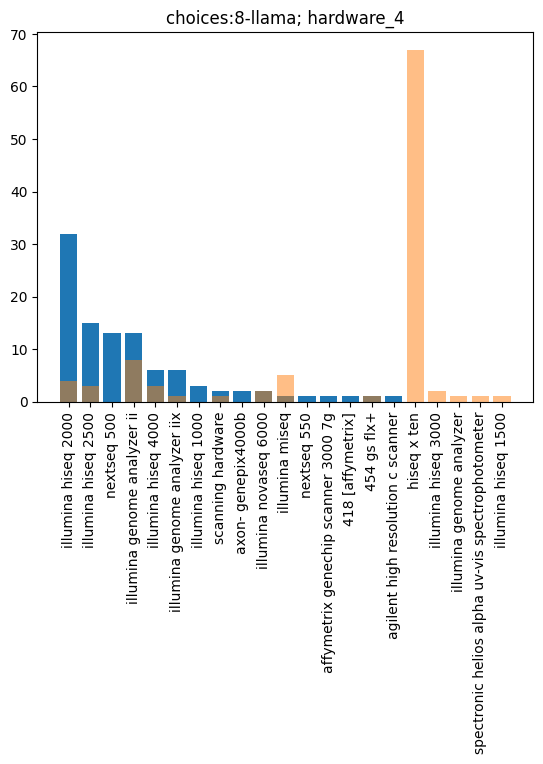

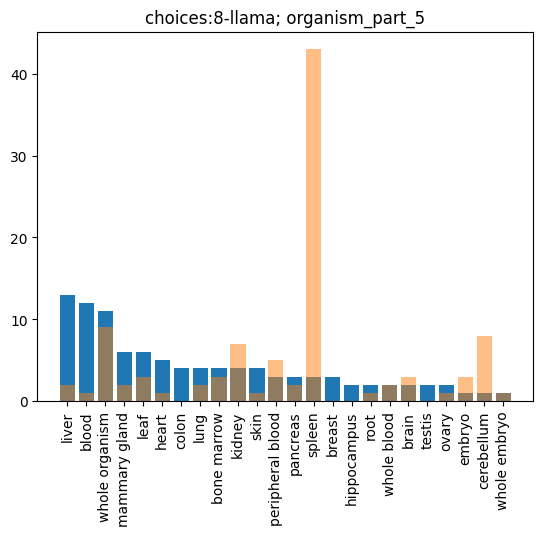

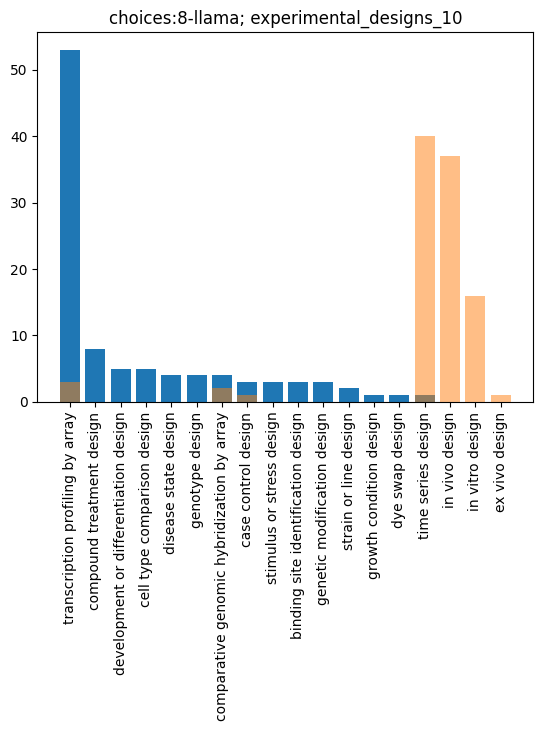

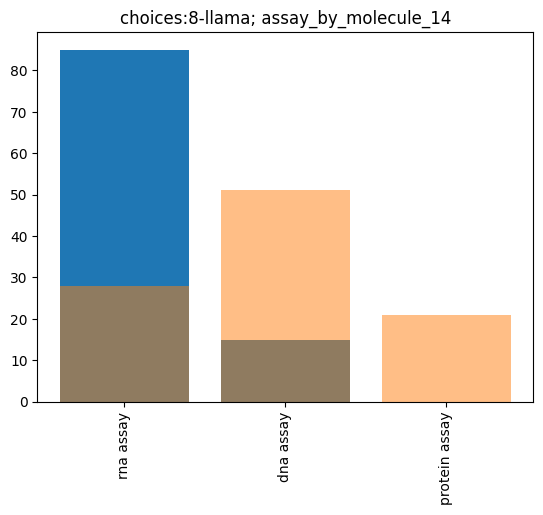

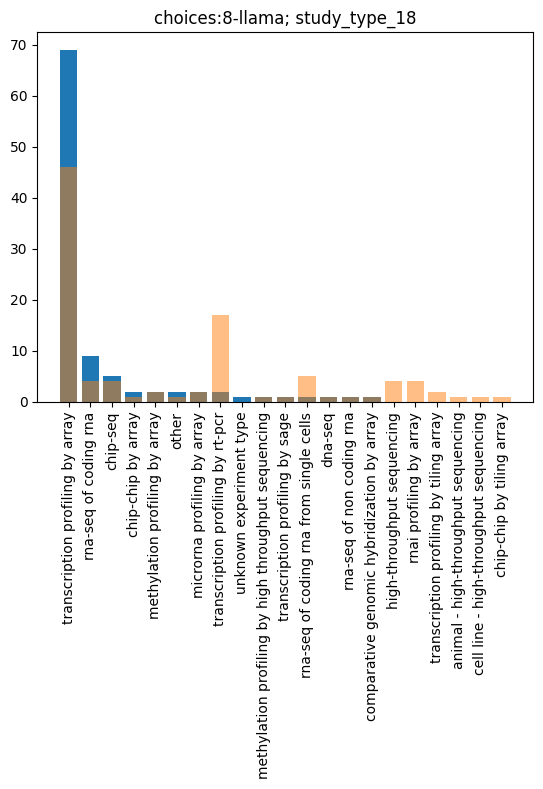

choice_list-llama


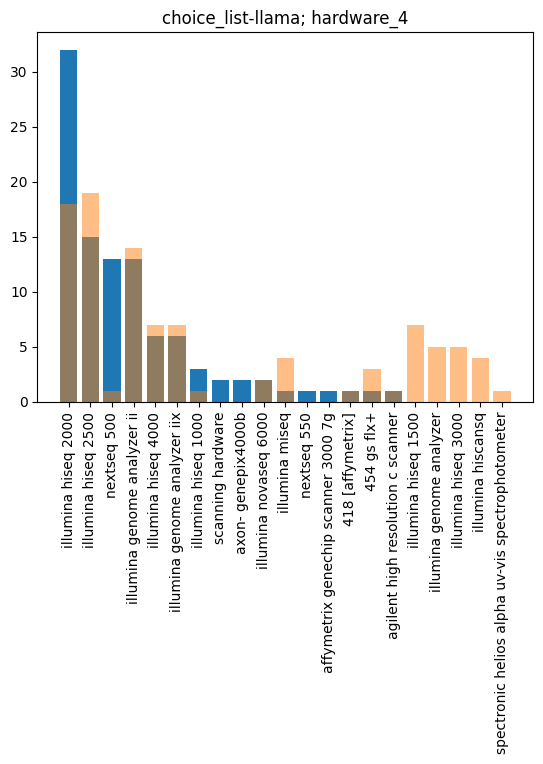

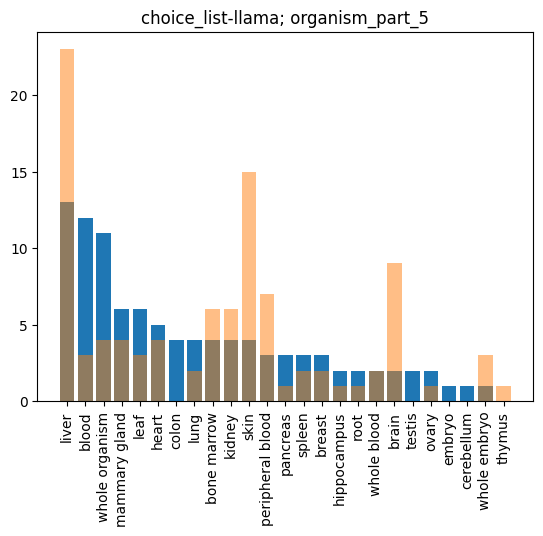

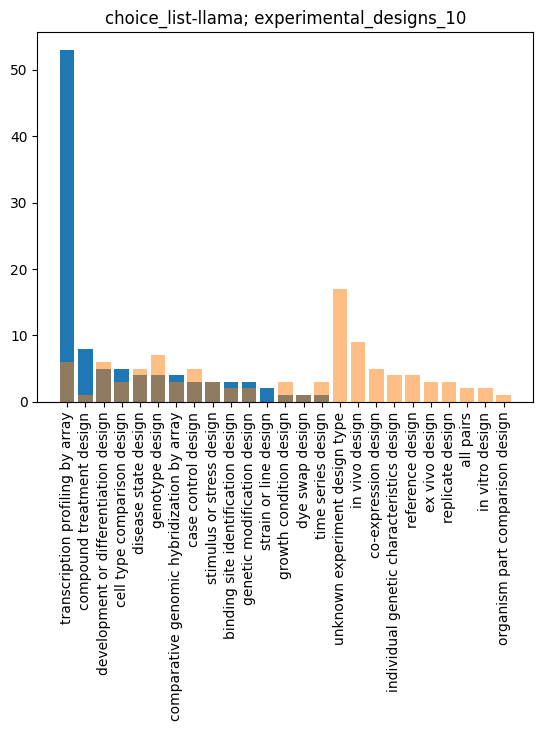

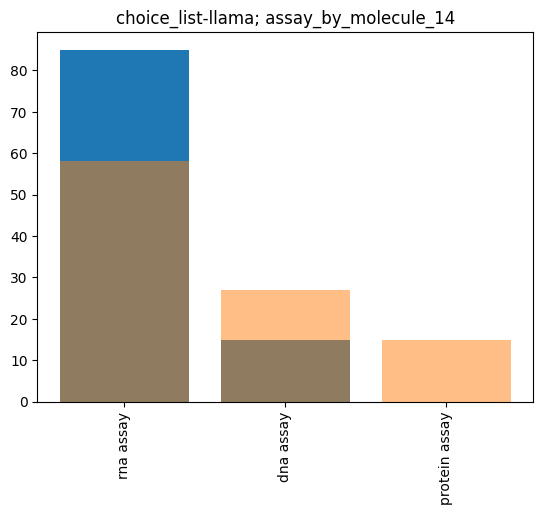

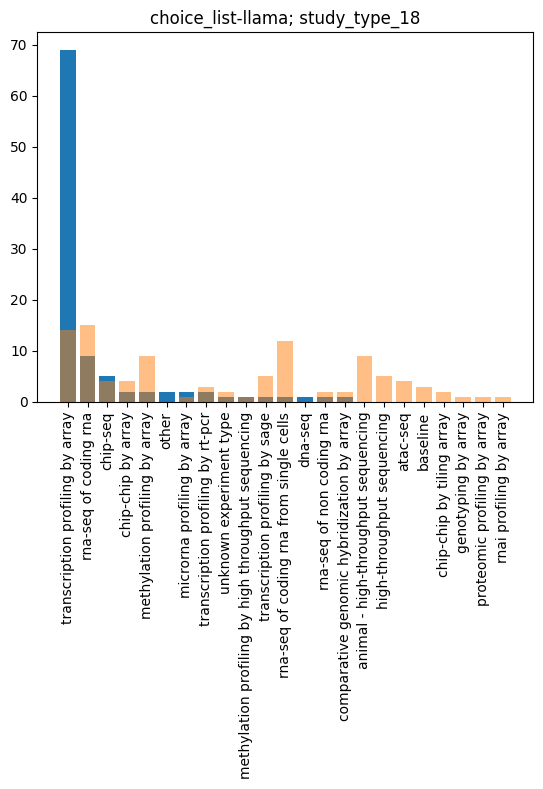

choice_list:3-llama


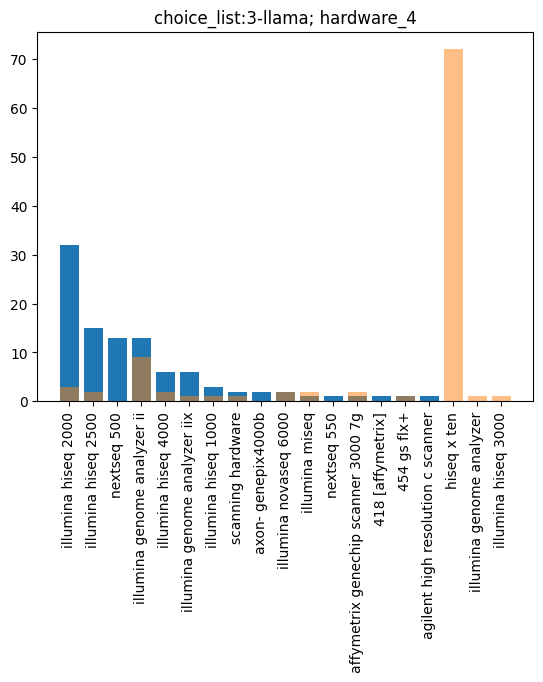

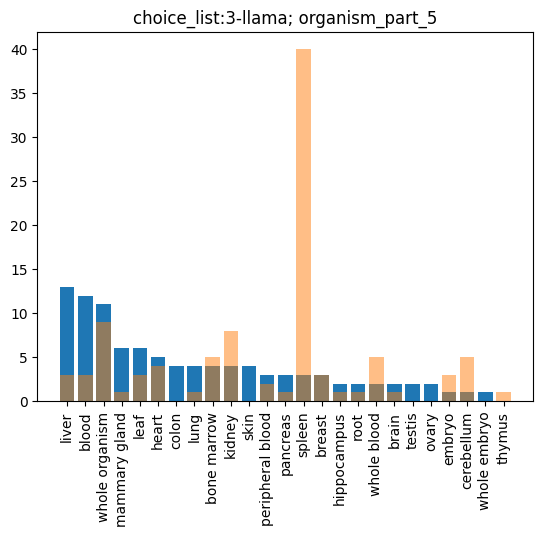

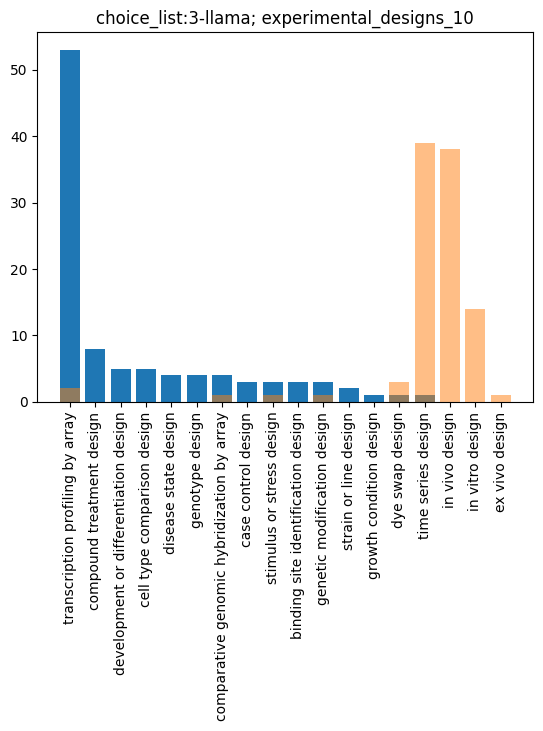

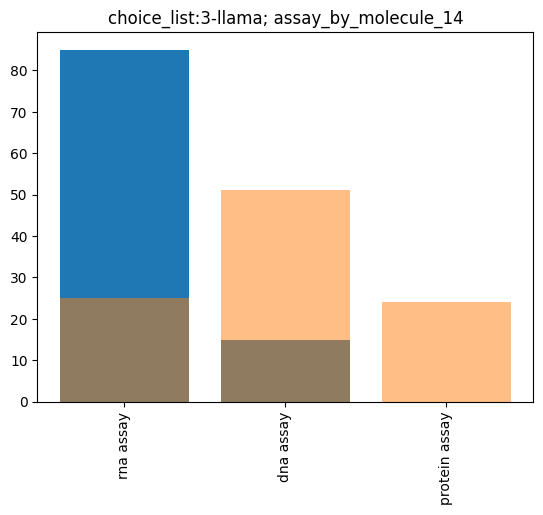

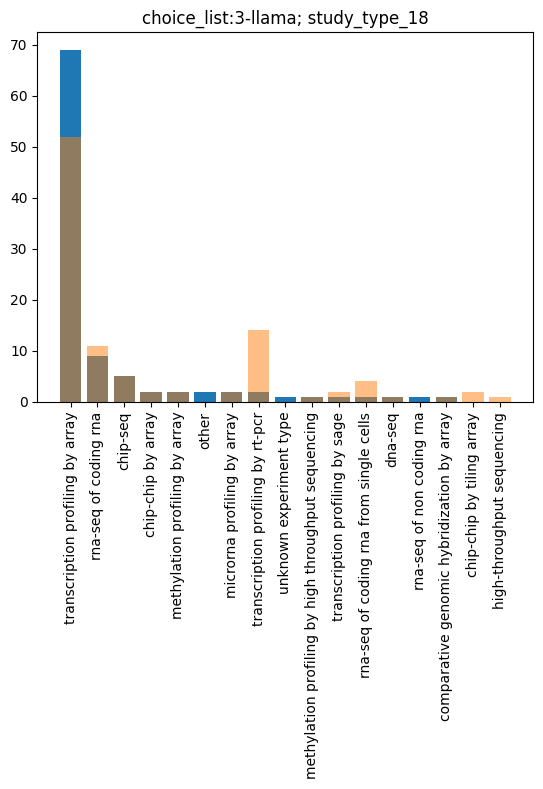

choice_list:5-llama


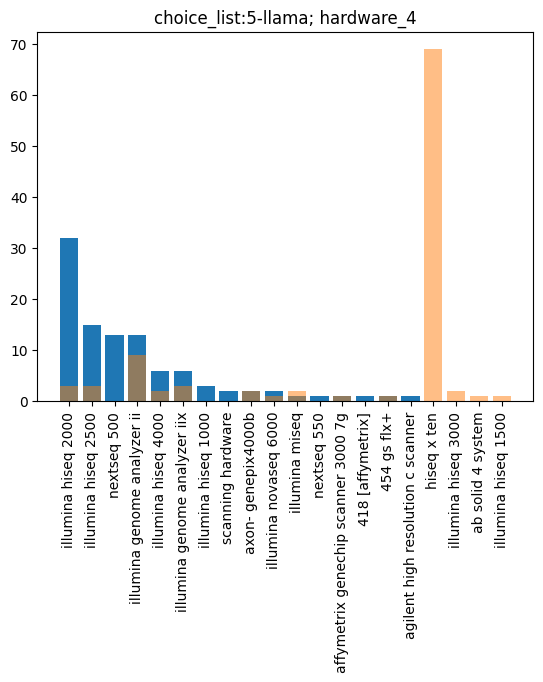

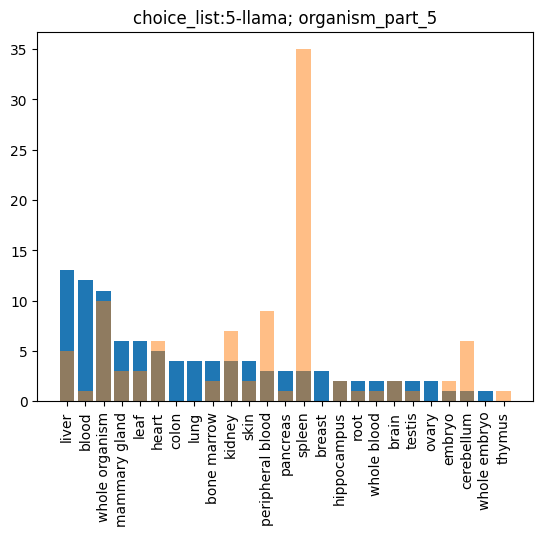

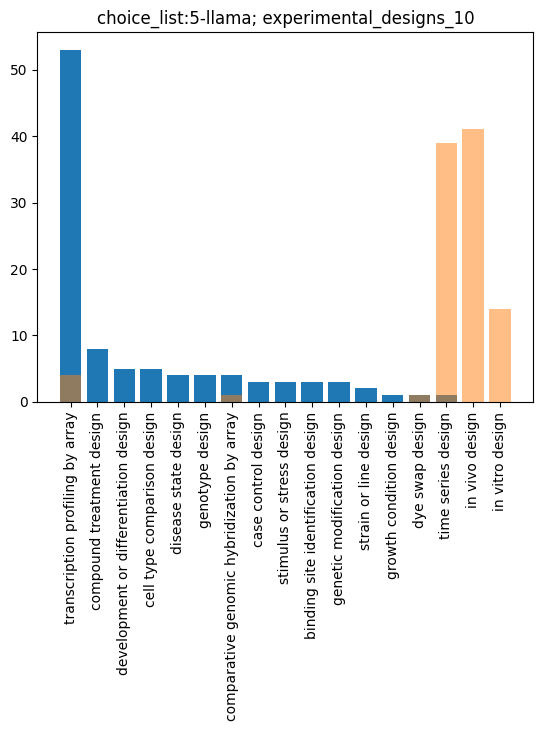

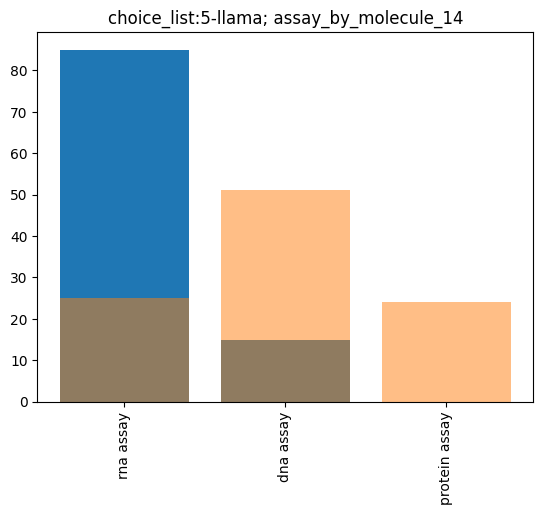

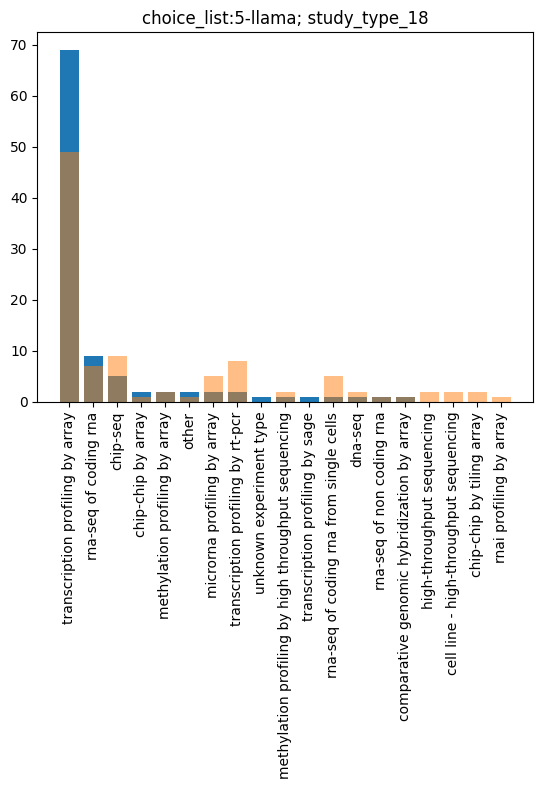

choice_list:8-llama


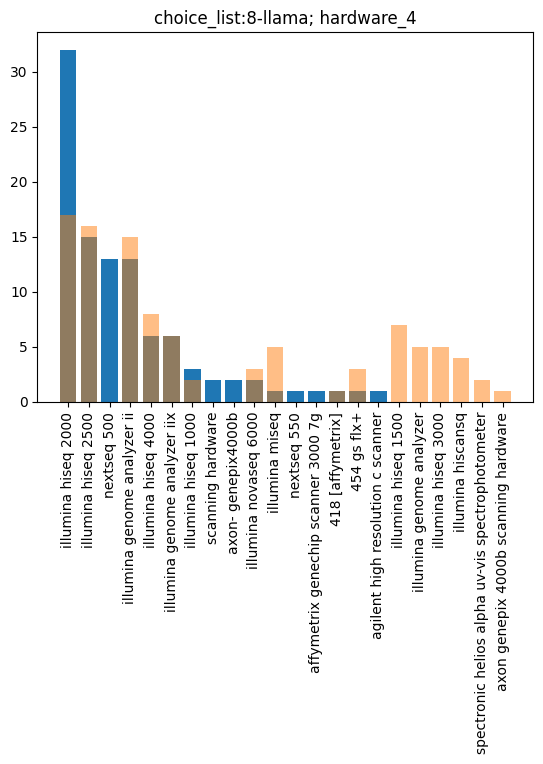

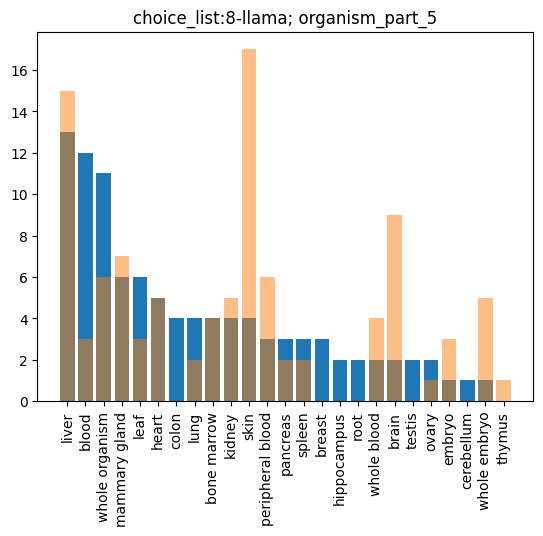

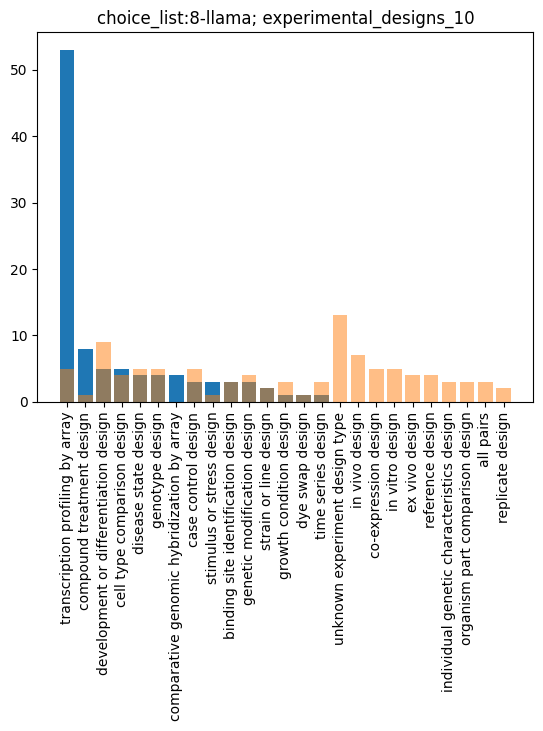

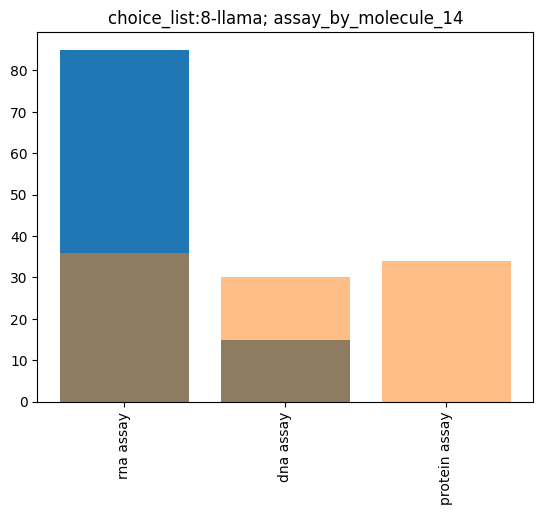

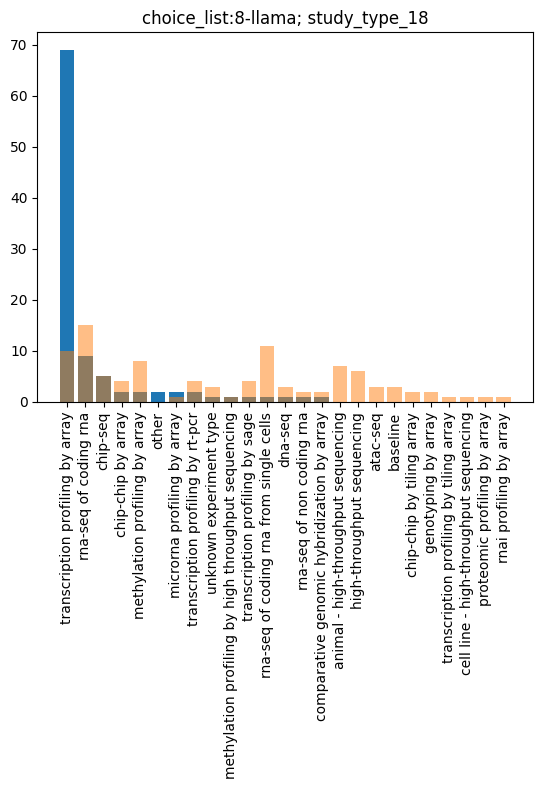

description-llama


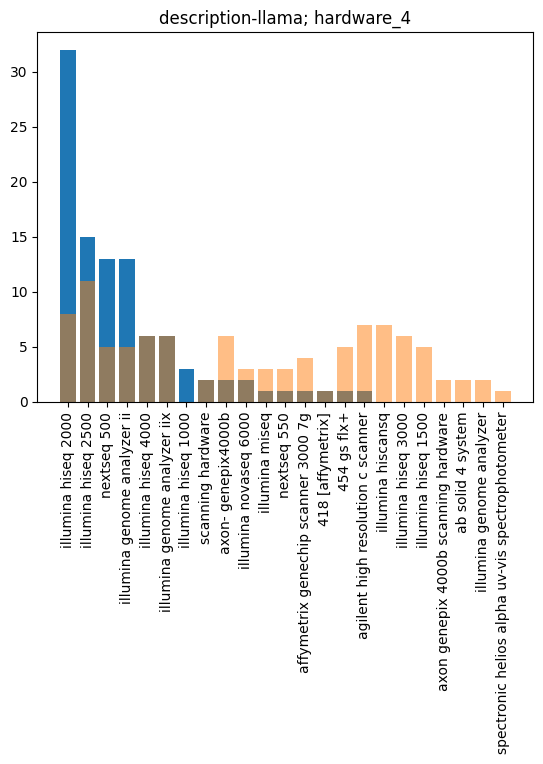

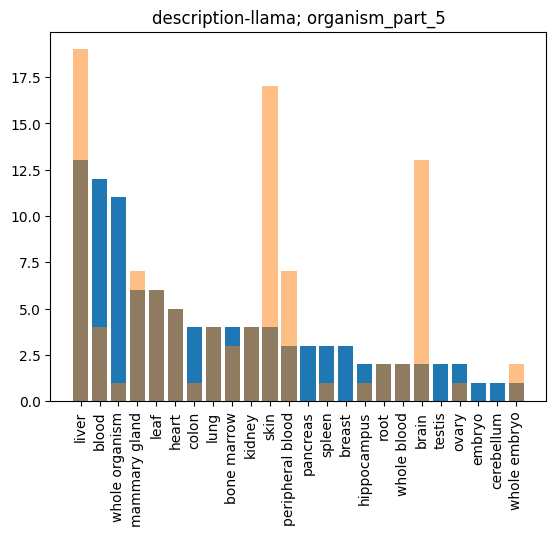

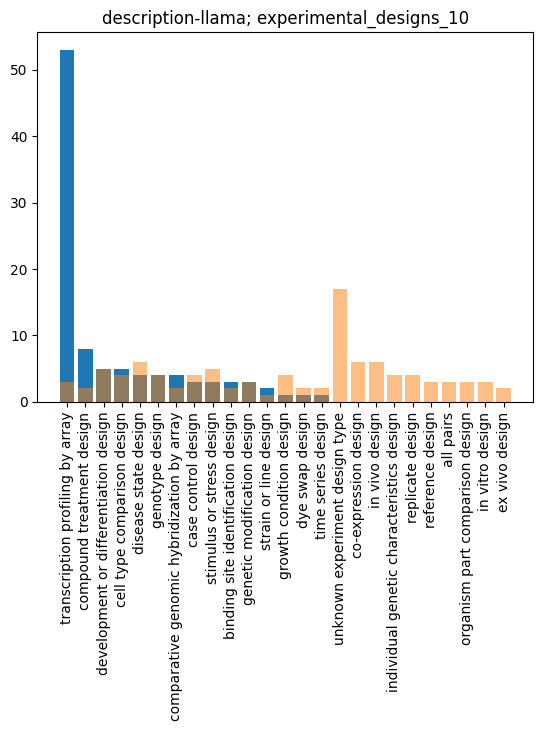

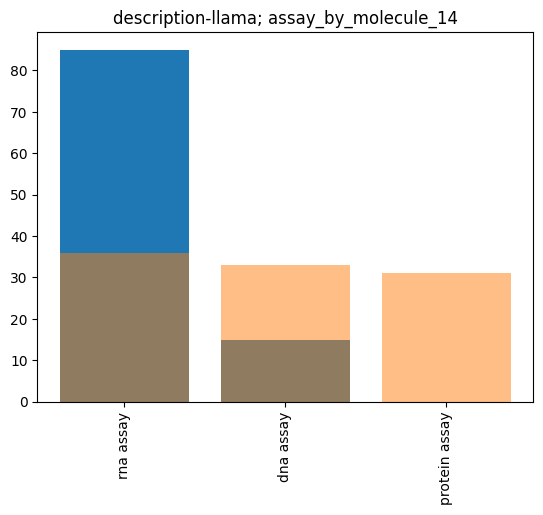

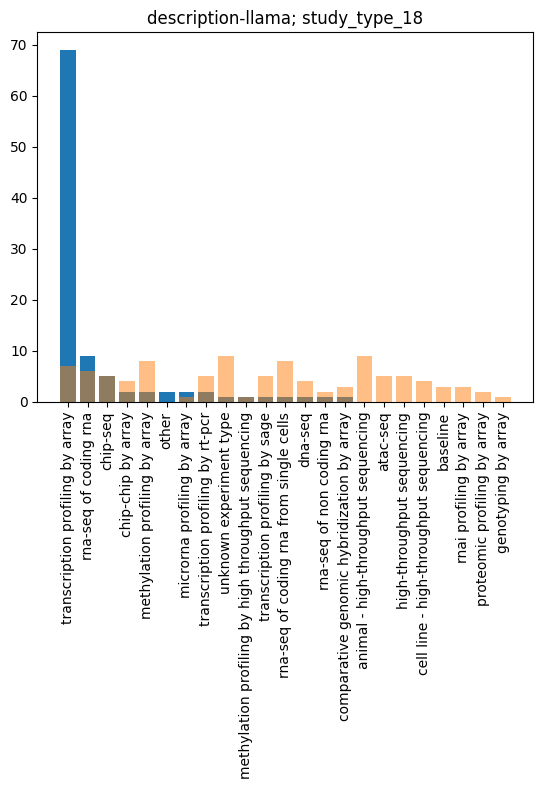

choices-mistral


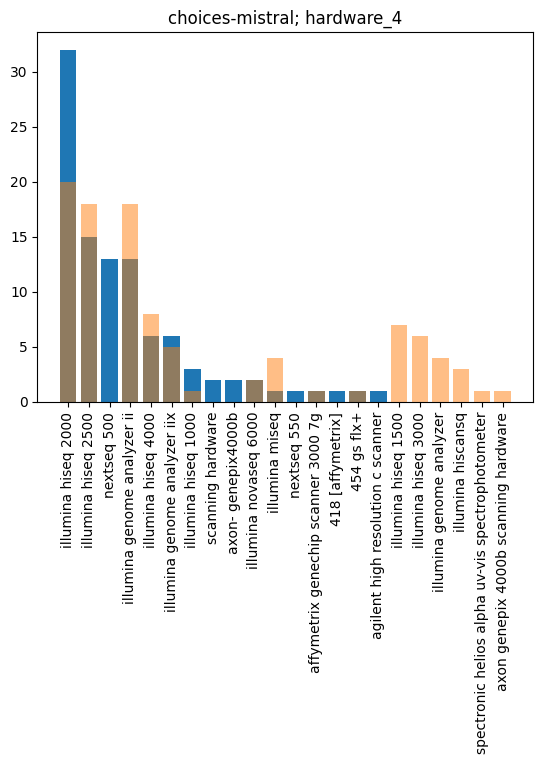

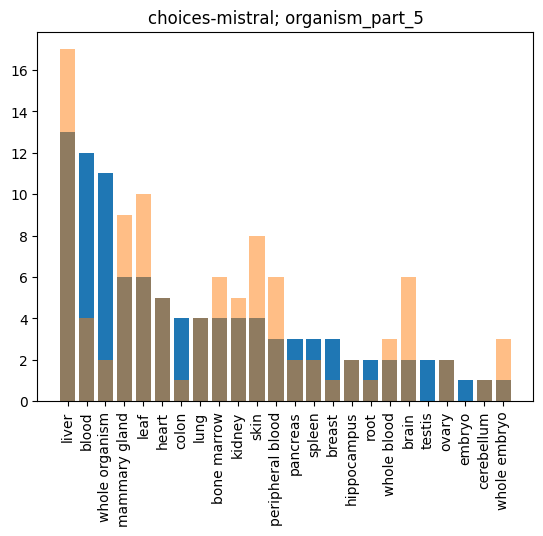

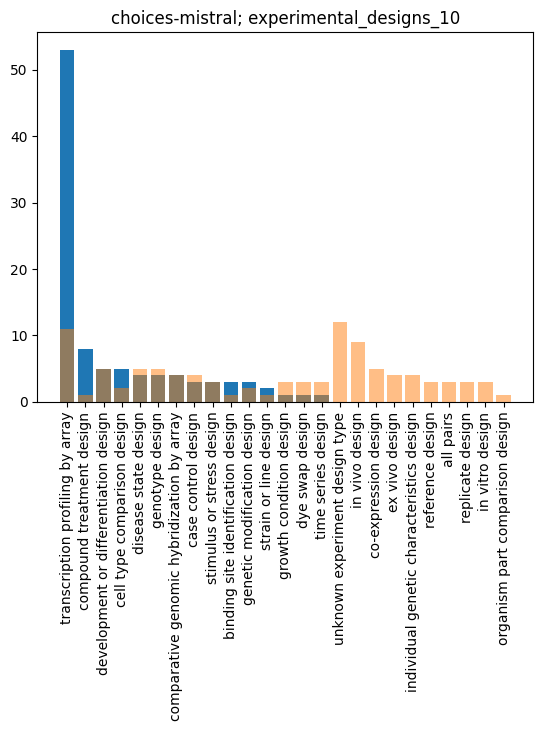

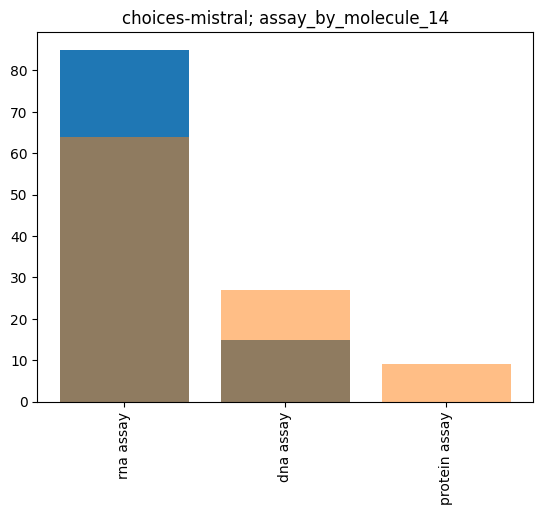

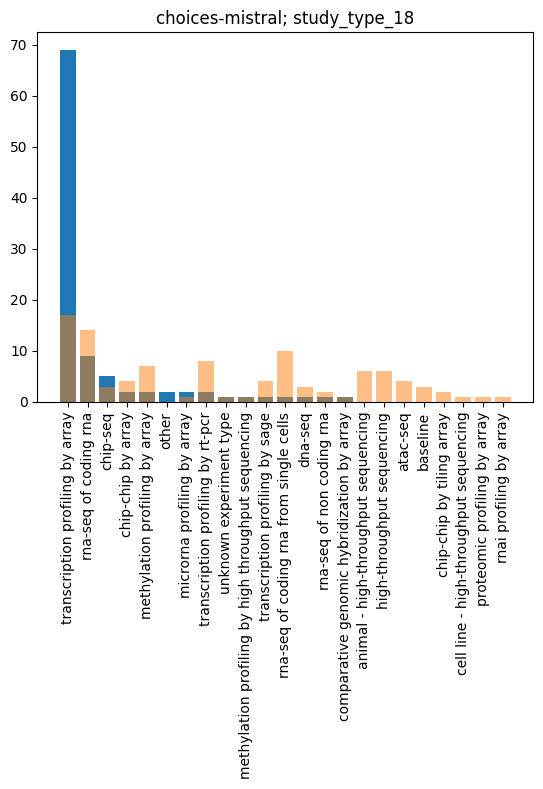

choices:3-mistral


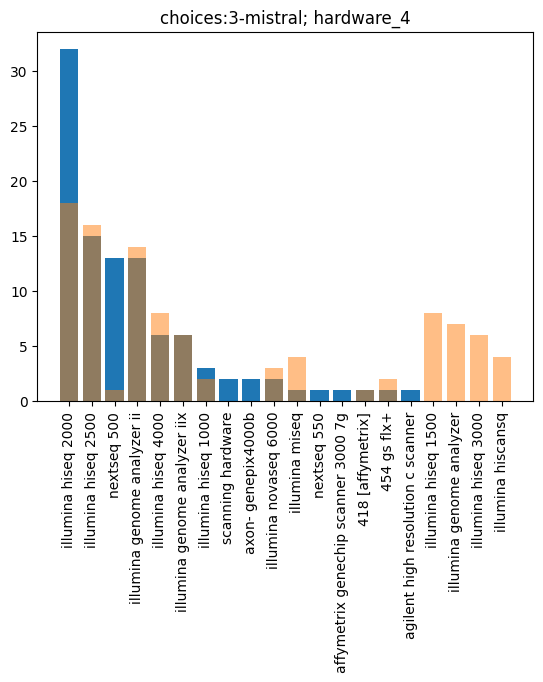

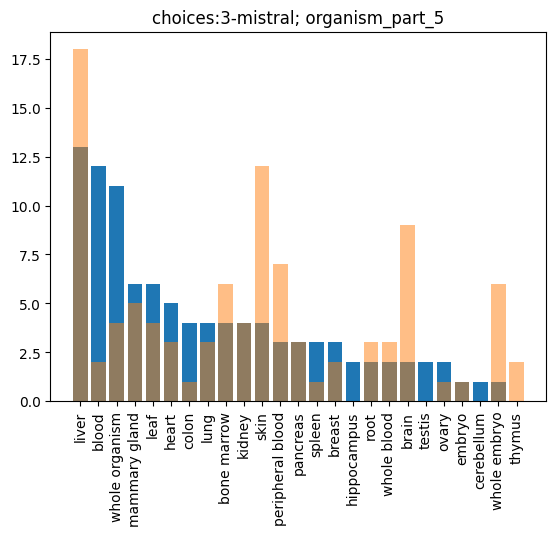

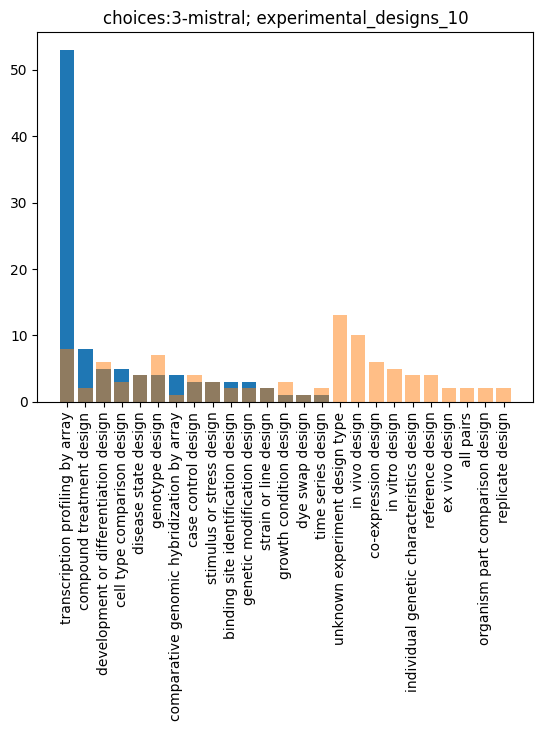

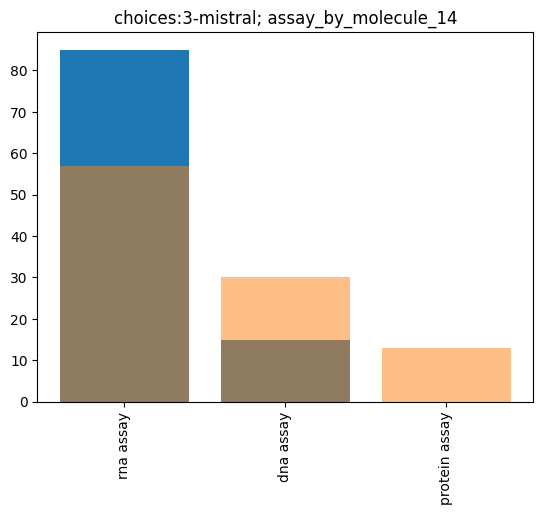

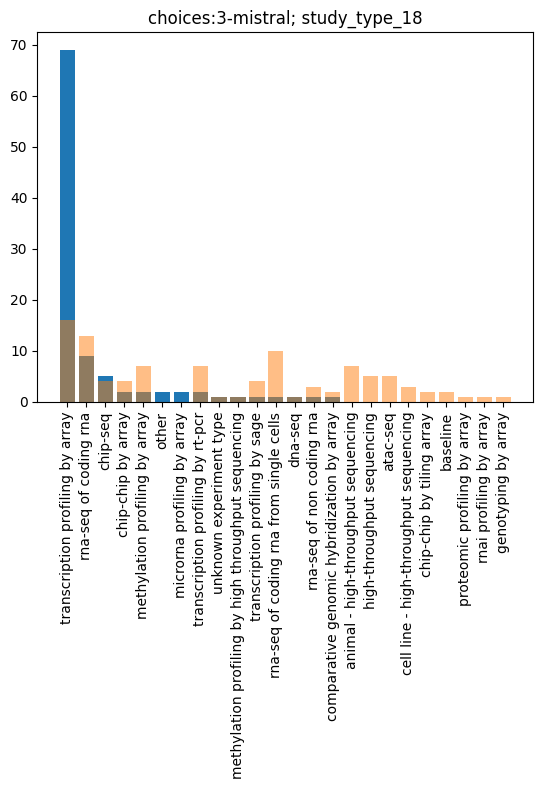

choices:5-mistral


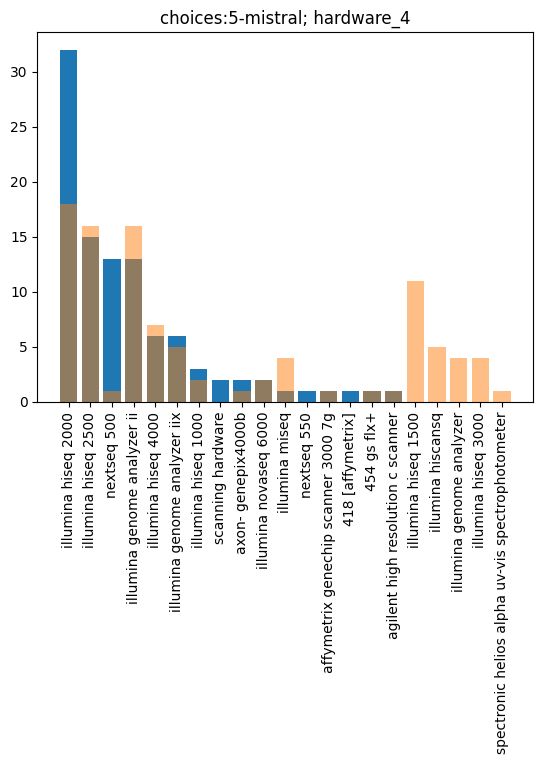

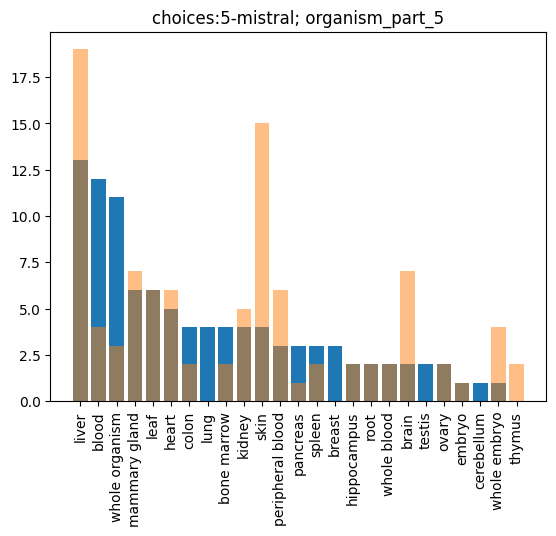

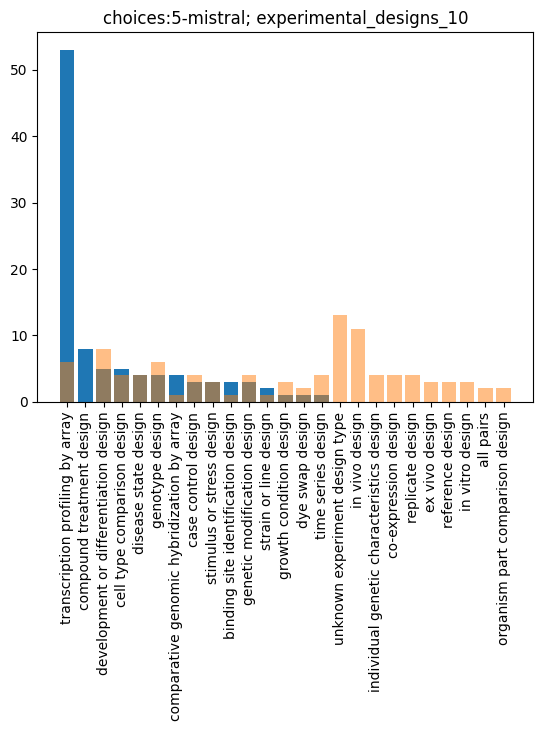

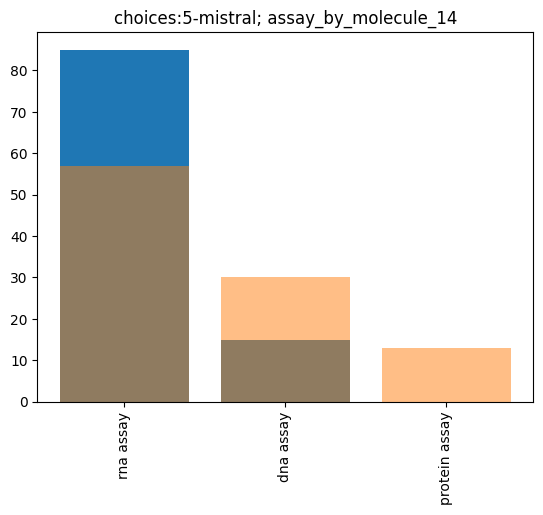

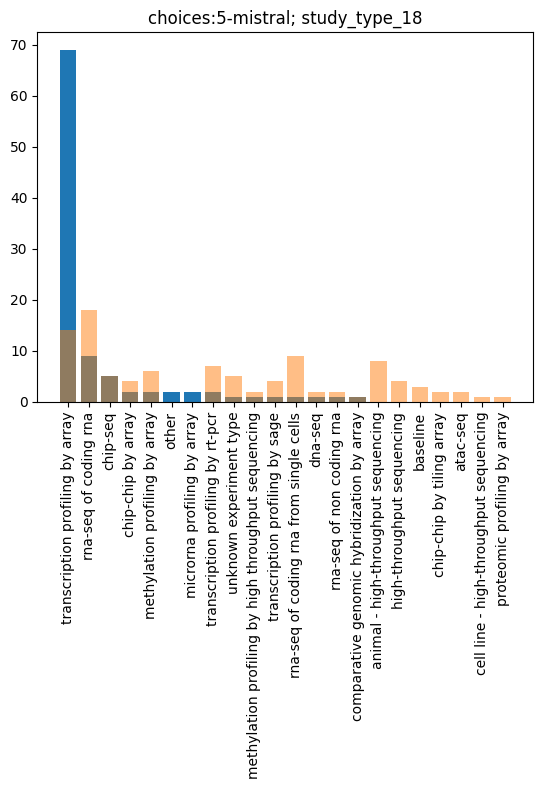

choices:8-mistral


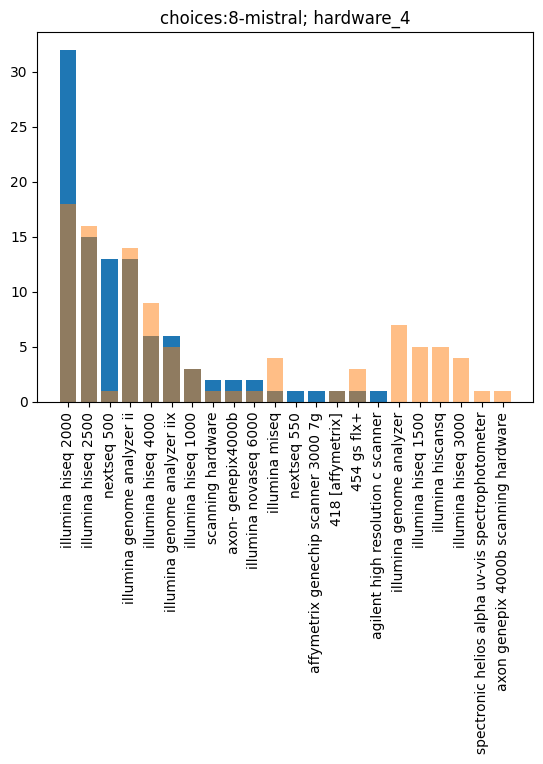

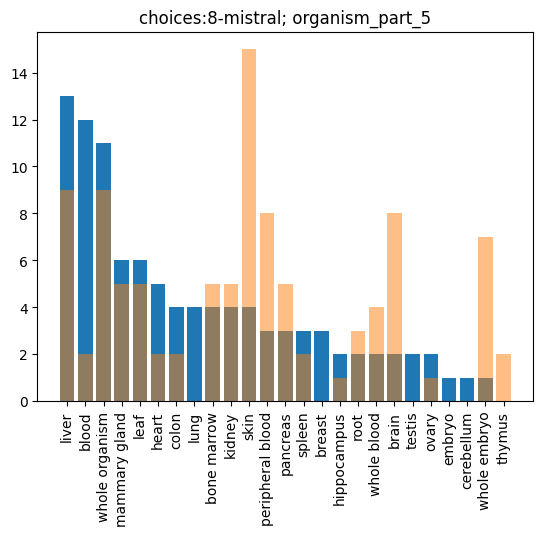

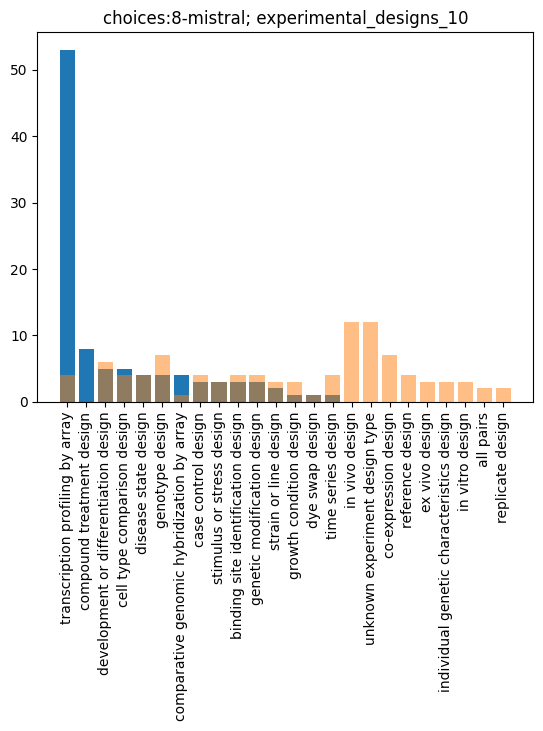

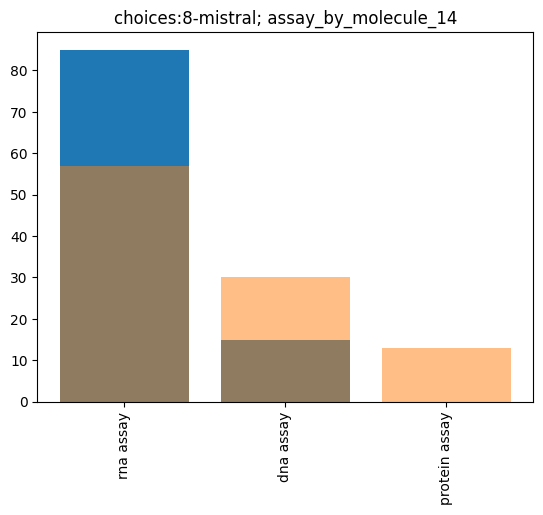

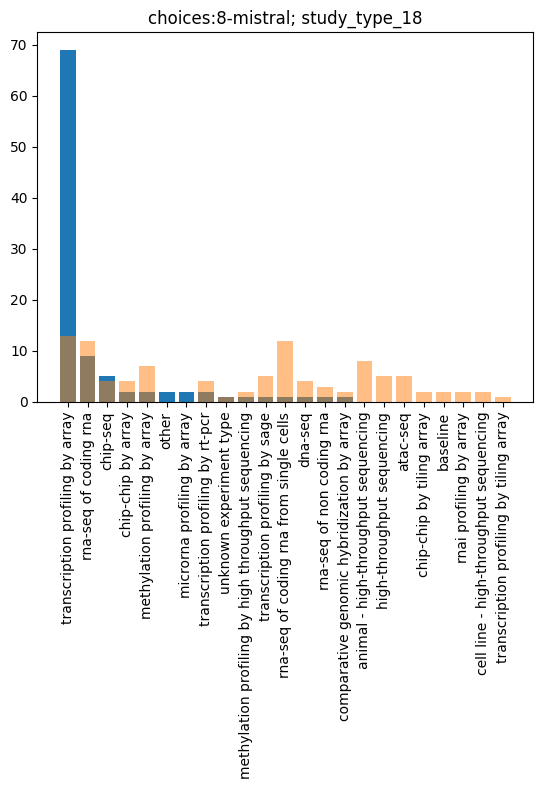

choice_list-mistral


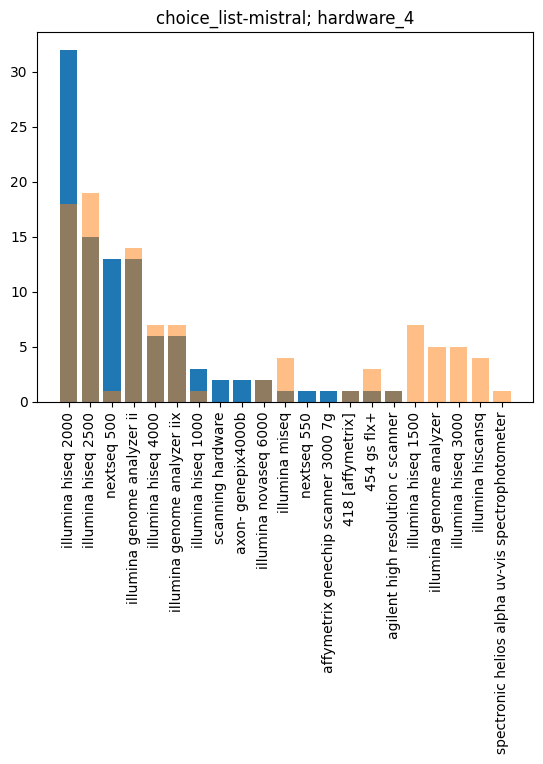

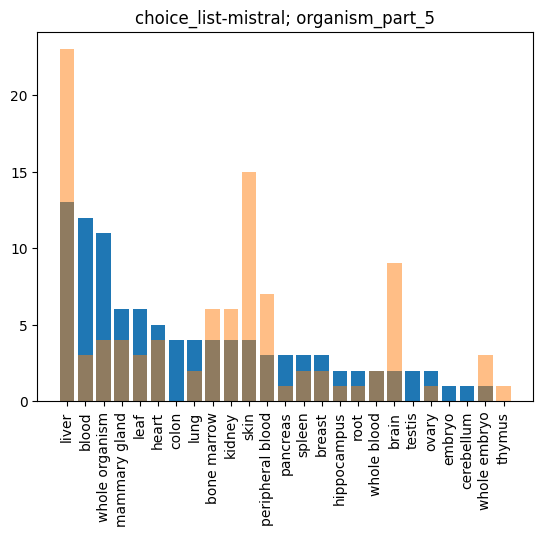

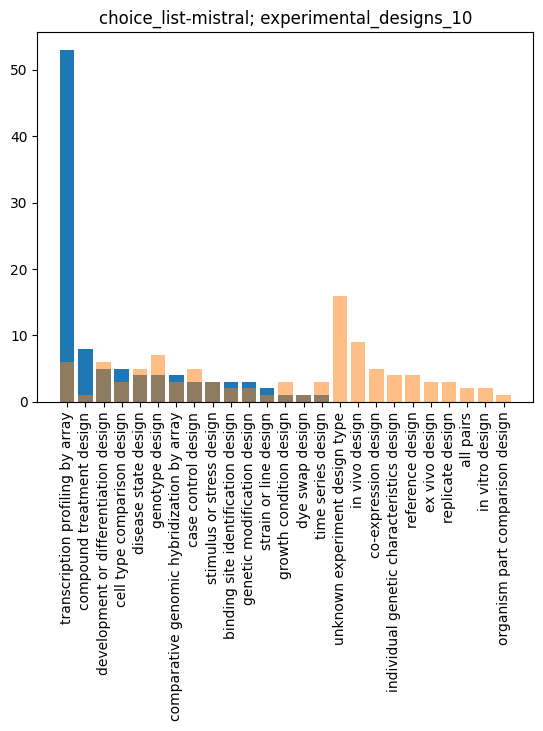

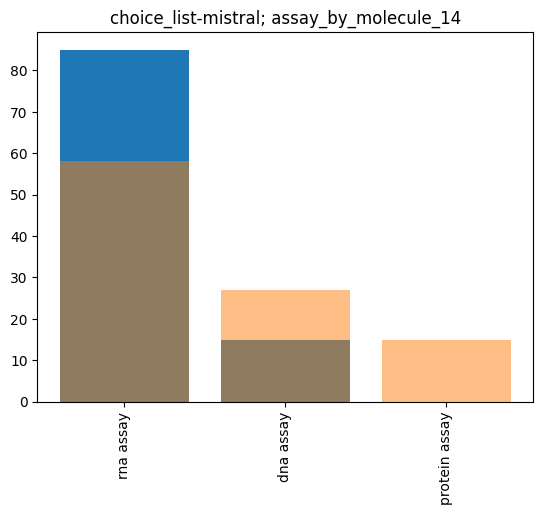

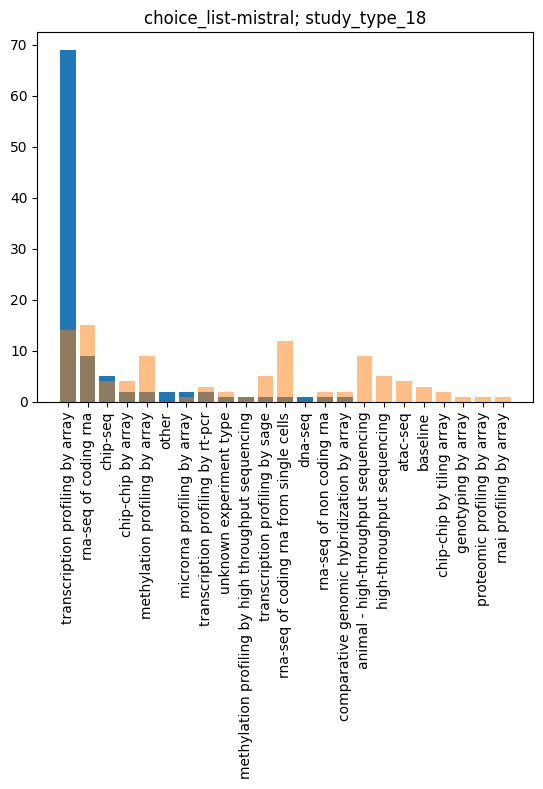

choice_list:3-mistral


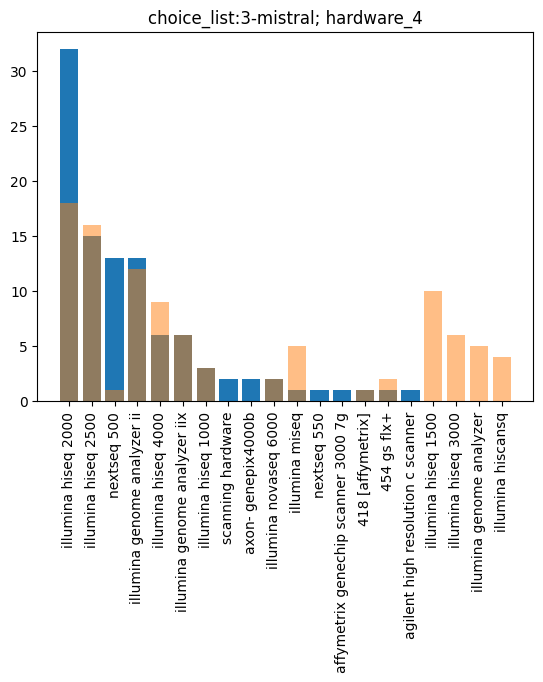

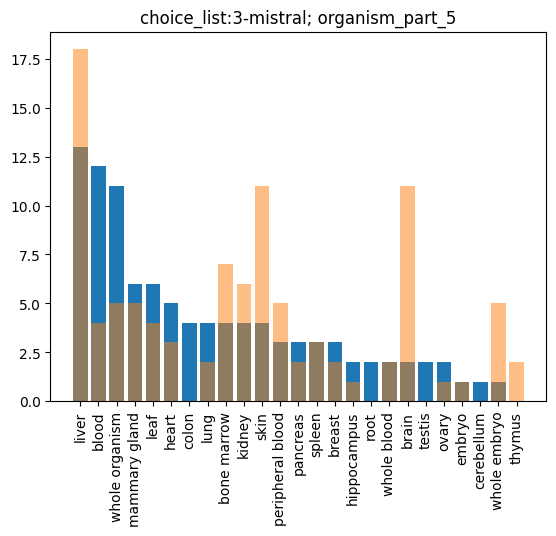

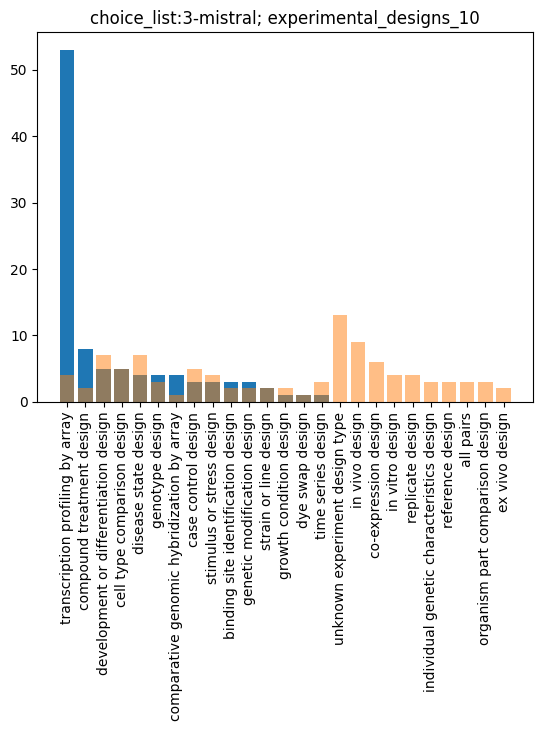

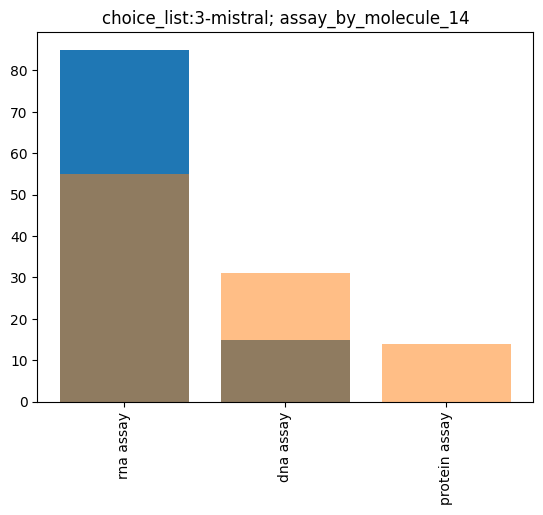

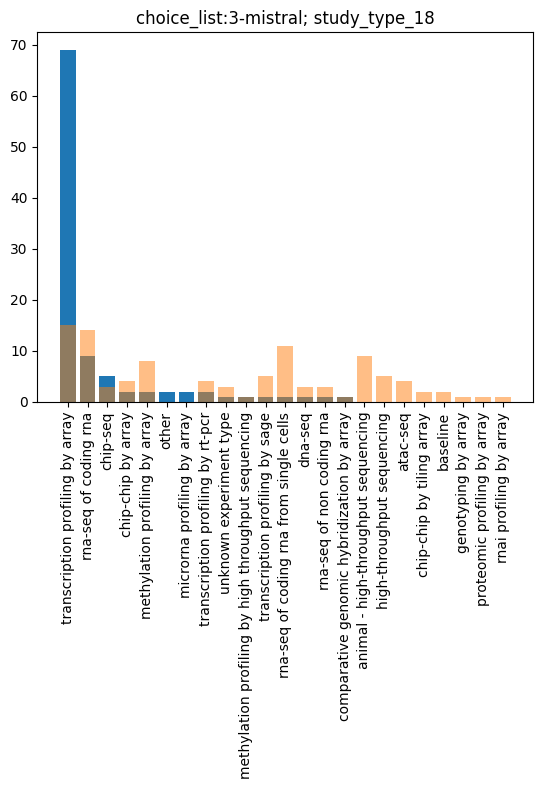

choice_list:5-mistral


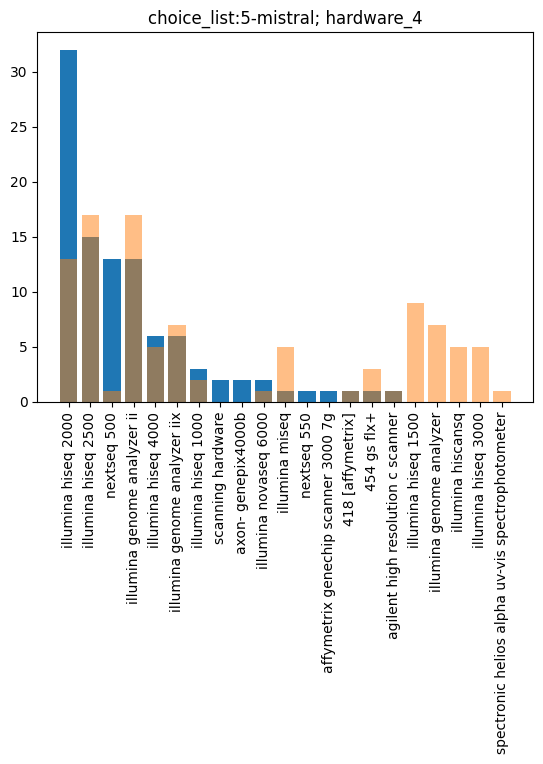

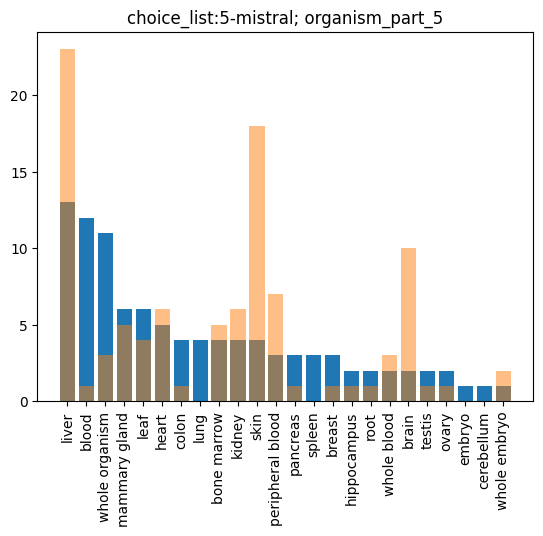

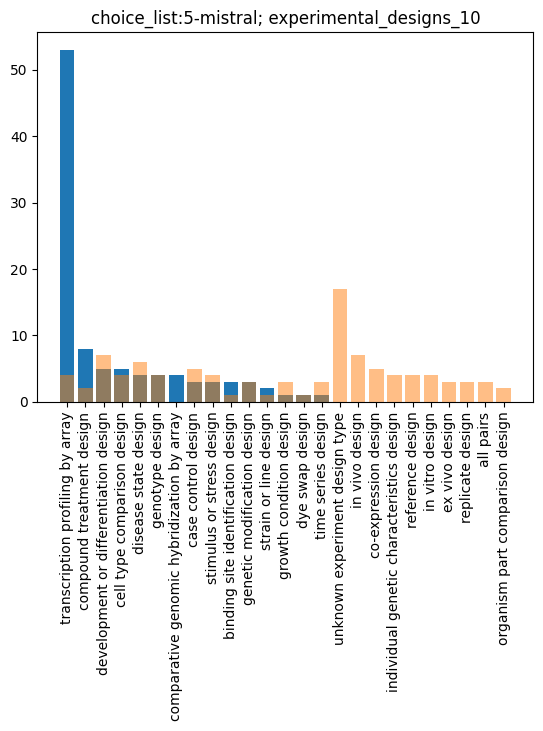

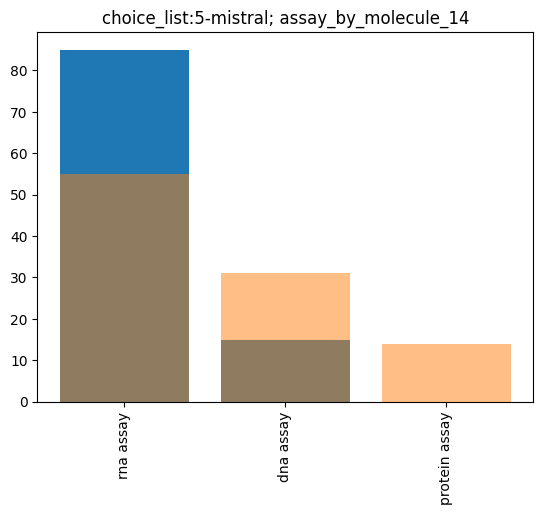

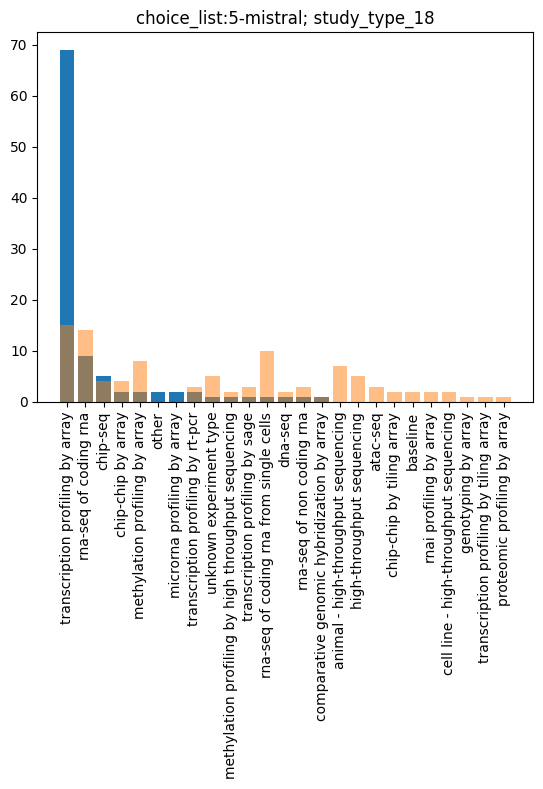

choice_list:8-mistral


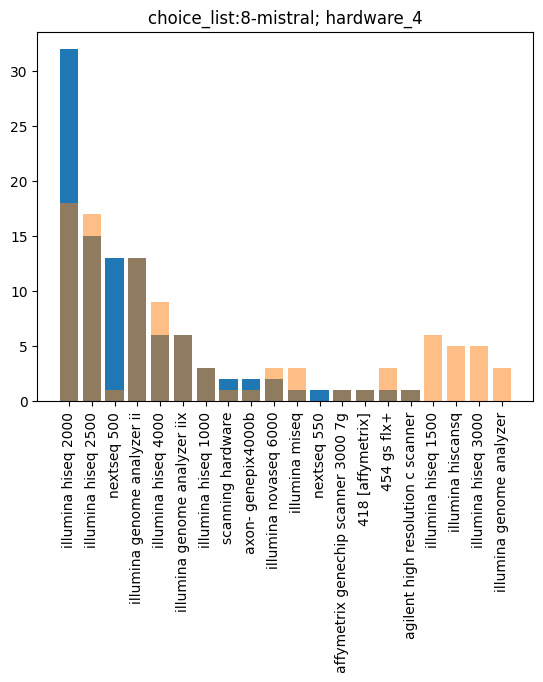

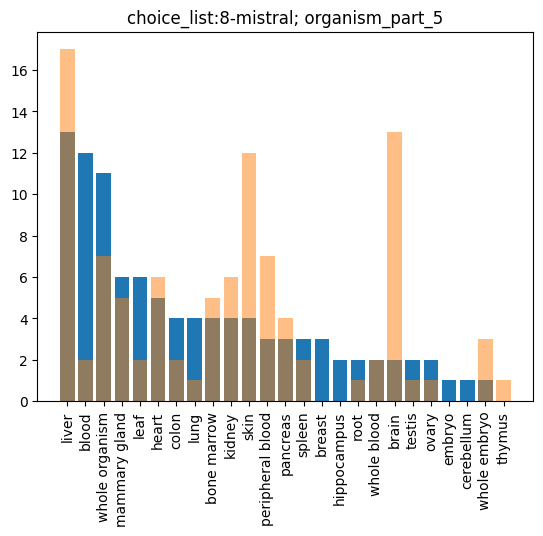

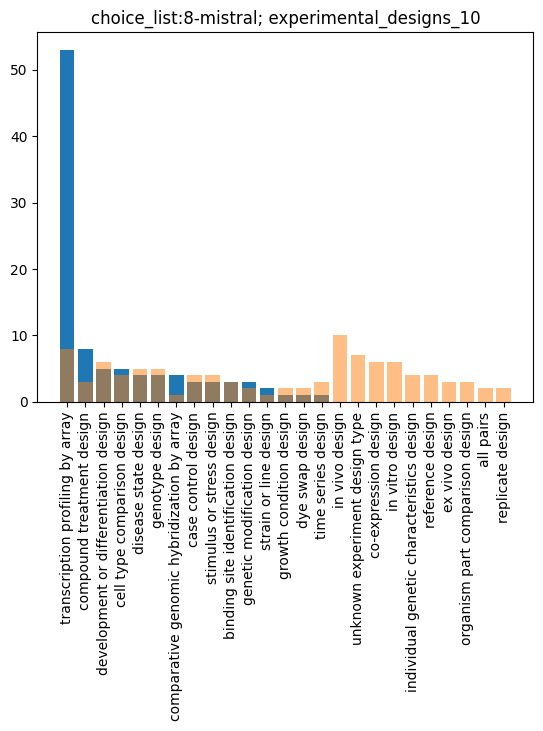

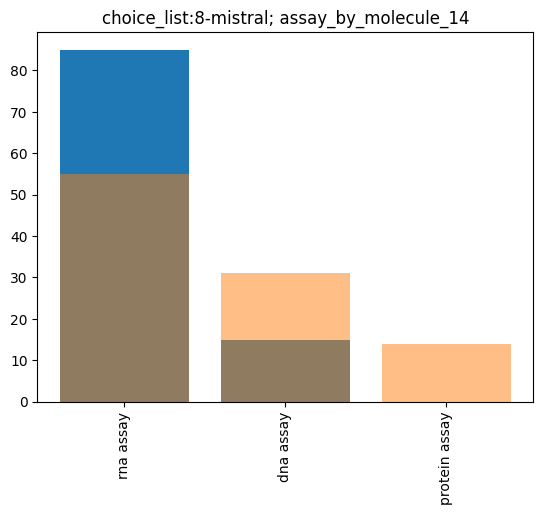

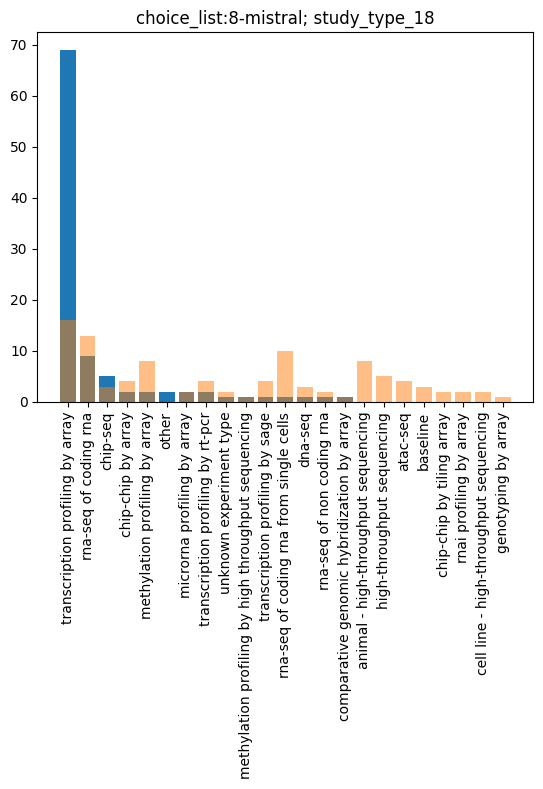

In [27]:
from collections import Counter

for argstring in choice_data:

    print(shortnames_by_argstring[argstring])


    for field in choice_data[argstring]:
    
        labels= []
        preds = []

        #print(field)
        for label, pred in choice_data[argstring][field]:
            labels.append(label)
            preds.append(pred)
        
        commons = Counter(labels).most_common()
        commons = {t[0]:t[1] for t in commons}
        plt.bar(commons.keys(), commons.values())
        plt.xticks(rotation=90)
        plt.title(label=field)

        commons = Counter(preds).most_common()
        commons = {t[0]:t[1] for t in commons}
        plt.bar(commons.keys(), commons.values(), alpha=0.5)
        plt.xticks(rotation=90)
        plt.title(label=shortnames_by_argstring[argstring] + "; "+field)

        plt.show()




# compare study type with ontology retrieval

In [28]:
with open("all_results/study_type_scores.json") as f:
    st_data = json.load(f)

st_score_data = st_data["scores"]
st_index_data = st_data["index_logs"]
st_choice_data = st_data["choice_log"]



In [29]:
for run_name in score_data:
    for fieldname in score_data[run_name]:
        print(fieldname)
    break

hardware_4
organism_part_5
experimental_designs_10
assay_by_molecule_14
study_type_18
total


In [30]:
print(score_data[run_name])

{'hardware_4': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], 'organism_part_5': [1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0

In [31]:
for run_name in st_score_data:
    print(run_name)
    #for fieldname in st_score_data[run_name]:
    #    print(fieldname)
    #break

[('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 300), ('context_shortener', 'retrieval'), ('dataset', 'study_type'), ('dataset_literal_length', 25), ('dataset_shuffle', 'r'), ('embedding_model', 'all-MiniLM-L6-v2'), ('ff_model', 'TheBloke/Mistral-7B-v0.1-GPTQ'), ('field_info_to_compare', 'onto-description'), ('include_choice_every', 1), ('keyphrase_min', 1), ('keyphrase_range_diff', 1), ('listed_output', False), ('log', True), ('maxsum_factor', 1.0), ('mmr_param', 1.0), ('n_keywords', 8), ('openai_ff_max_tokens', 1000), ('outlines_ff_max_tokens', 100), ('reduce_max_tokens', 50), ('reduce_temperature', 0.4), ('remove_fields', 'non-single'), ('retriever_type', 'simple'), ('sampler', 'beam'), ('sampler_beams', 3), ('sampler_temp', 0.4), ('sampler_top_k', 100), ('sampler_top_p', 1), ('similarity_k', 4)]
[('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 500), ('context_shortener',

In [32]:
for run_name in score_data:
    st_score_data[run_name] = {"study_type_18" : score_data[run_name]["study_type_18"]}


In [33]:
len(st_score_data)

32

In [34]:
st_shortnames = ["ontologydesc-mistral", "ontologydesc-gpt", "ontologydesc-llama", *shortnames]

In [35]:
scores = []
for i, key in enumerate(list(st_score_data.keys())):
    scores.append([])
    for field in st_score_data[key]:
        scores[i].append(sum(st_score_data[key][field])/len(st_score_data[key][field]))
scores

df = pd.DataFrame(data=scores, columns= st_score_data[key].keys(), index=st_shortnames).sort_values("study_type_18", ascending=False)
print(df.to_markdown())
print("")

|                       |   study_type_18 |
|:----------------------|----------------:|
| choice_list:8-gpt     |            0.68 |
| choice_list:5-gpt     |            0.65 |
| choice_list:3-gpt     |            0.65 |
| choices:8-gpt         |            0.65 |
| choice_list-gpt       |            0.64 |
| choices:5-gpt         |            0.64 |
| choices:3-gpt         |            0.62 |
| choice_list:3-llama   |            0.62 |
| choices-gpt           |            0.55 |
| ontologydesc-gpt      |            0.55 |
| choice_list:5-llama   |            0.54 |
| choices:8-llama       |            0.53 |
| choices:3-llama       |            0.51 |
| choices:5-llama       |            0.49 |
| description-gpt       |            0.48 |
| fullpaper-gpt         |            0.23 |
| choices-llama         |            0.2  |
| choices-mistral       |            0.2  |
| choices:5-mistral     |            0.18 |
| choices:3-mistral     |            0.16 |
| choice_list:5-mistral |       

In [36]:
# make dataframes
st_dfs = {}
for ref_key in st_score_data:
    values = []
    for key in st_score_data:
        values.append([])
        for field in st_score_data[key]:
            values[-1].append(pval(st_score_data[key][field], st_score_data[ref_key][field], False))
    df = pd.DataFrame(data=values, columns= st_score_data[key].keys(), index=st_shortnames)
    st_dfs[ref_key] = df


# define print function
def st_p(i):
    k = list(st_dfs.keys())[i]
    print(st_shortnames[i])
    print(k)
    return st_dfs[k]

In [37]:
st_p(0)

ontologydesc-mistral
[('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 300), ('context_shortener', 'retrieval'), ('dataset', 'study_type'), ('dataset_literal_length', 25), ('dataset_shuffle', 'r'), ('embedding_model', 'all-MiniLM-L6-v2'), ('ff_model', 'TheBloke/Mistral-7B-v0.1-GPTQ'), ('field_info_to_compare', 'onto-description'), ('include_choice_every', 1), ('keyphrase_min', 1), ('keyphrase_range_diff', 1), ('listed_output', False), ('log', True), ('maxsum_factor', 1.0), ('mmr_param', 1.0), ('n_keywords', 8), ('openai_ff_max_tokens', 1000), ('outlines_ff_max_tokens', 100), ('reduce_max_tokens', 50), ('reduce_temperature', 0.4), ('remove_fields', 'non-single'), ('retriever_type', 'simple'), ('sampler', 'beam'), ('sampler_beams', 3), ('sampler_temp', 0.4), ('sampler_top_k', 100), ('sampler_top_p', 1), ('similarity_k', 4)]


study_type_18
ontologydesc-mistral             NaN
ontologydesc-gpt                 NaN
ontologydesc-llama               NaN
description-mistral         0.030884
best_choice                 0.548506
description-gpt                  NaN
choices-gpt                      NaN
choices:3-gpt                    NaN
choices:5-gpt                    NaN
choices:8-gpt                    NaN
choice_list-gpt                  NaN
choice_list:3-gpt                NaN
choice_list:5-gpt                NaN
choice_list:8-gpt                NaN
fullpaper-gpt                    NaN
choices-llama                    NaN
choices:3-llama                  NaN
choices:5-llama                  NaN
choices:8-llama                  NaN
choice_list-llama           0.629059
choice_list:3-llama              NaN
choice_list:5-llama              NaN
choice_list:8-llama         0.266846
description-llama           0.030884
choices-mistral                  NaN
choices:3-mistral                NaN
choices:5-mistral                NaN
choices:8-mistral           0.607239
choice_list-mistral         0.629059
choice_list:3-mistral       1.000000
choice_list:5-mistral            NaN
choice_list:8-mistral       1.000000

In [38]:
st_p(1)

ontologydesc-gpt
[('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 500), ('context_shortener', 'retrieval'), ('dataset', 'study_type'), ('dataset_literal_length', 25), ('dataset_shuffle', 'r'), ('embedding_model', 'all-MiniLM-L6-v2'), ('ff_model', '4om'), ('field_info_to_compare', 'onto-description'), ('include_choice_every', 1), ('keyphrase_min', 1), ('keyphrase_range_diff', 1), ('listed_output', False), ('log', True), ('maxsum_factor', 1.0), ('mmr_param', 1.0), ('n_keywords', 8), ('openai_ff_max_tokens', 1000), ('outlines_ff_max_tokens', 100), ('reduce_max_tokens', 50), ('reduce_temperature', 0.4), ('remove_fields', 'non-single'), ('retriever_type', 'simple'), ('sampler', 'beam'), ('sampler_beams', 3), ('sampler_temp', 0.4), ('sampler_top_k', 100), ('sampler_top_p', 1), ('similarity_k', 10)]


study_type_18
ontologydesc-mistral    3.686519e-09
ontologydesc-gpt                 NaN
ontologydesc-llama      3.686519e-09
description-mistral     4.098215e-12
best_choice             8.105017e-10
description-gpt         2.623317e-01
choices-gpt                      NaN
choices:3-gpt                    NaN
choices:5-gpt                    NaN
choices:8-gpt                    NaN
choice_list-gpt                  NaN
choice_list:3-gpt                NaN
choice_list:5-gpt                NaN
choice_list:8-gpt                NaN
fullpaper-gpt           3.859616e-06
choices-llama           1.813621e-07
choices:3-llama         4.927167e-01
choices:5-llama         3.427817e-01
choices:8-llama         7.518296e-01
choice_list-llama       8.105017e-10
choice_list:3-llama              NaN
choice_list:5-llama     8.694171e-01
choice_list:8-llama     5.240970e-11
description-llama       4.098215e-12
choices-mistral         1.813621e-07
choices:3-mistral       2.723615e-09
choices:5-mistral       3.475241e-08
choices:8-mistral       3.559942e-10
choice_list-mistral     8.105017e-10
choice_list:3-mistral   2.225020e-09
choice_list:5-mistral   7.764037e-09
choice_list:8-mistral   4.708980e-09

In [39]:
st_p(2)

ontologydesc-llama
[('answer_in_quotes', True), ('chunk_info_to_compare', 'direct'), ('chunk_overlap', 100), ('chunk_size', 300), ('context_shortener', 'retrieval'), ('dataset', 'study_type'), ('dataset_literal_length', 25), ('dataset_shuffle', 'r'), ('embedding_model', 'all-MiniLM-L6-v2'), ('ff_model', 'hugging-quants/Meta-Llama-3.1-8B-Instruct-GPTQ-INT4'), ('field_info_to_compare', 'onto-description'), ('include_choice_every', 1), ('keyphrase_min', 1), ('keyphrase_range_diff', 1), ('listed_output', False), ('log', True), ('maxsum_factor', 1.0), ('mmr_param', 1.0), ('n_keywords', 8), ('openai_ff_max_tokens', 1000), ('outlines_ff_max_tokens', 100), ('reduce_max_tokens', 50), ('reduce_temperature', 0.4), ('remove_fields', 'non-single'), ('retriever_type', 'simple'), ('sampler', 'beam'), ('sampler_beams', 3), ('sampler_temp', 0.4), ('sampler_top_k', 100), ('sampler_top_p', 1), ('similarity_k', 4)]


study_type_18
ontologydesc-mistral             NaN
ontologydesc-gpt                 NaN
ontologydesc-llama               NaN
description-mistral         0.030884
best_choice                 0.548506
description-gpt                  NaN
choices-gpt                      NaN
choices:3-gpt                    NaN
choices:5-gpt                    NaN
choices:8-gpt                    NaN
choice_list-gpt                  NaN
choice_list:3-gpt                NaN
choice_list:5-gpt                NaN
choice_list:8-gpt                NaN
fullpaper-gpt                    NaN
choices-llama                    NaN
choices:3-llama                  NaN
choices:5-llama                  NaN
choices:8-llama                  NaN
choice_list-llama           0.629059
choice_list:3-llama              NaN
choice_list:5-llama              NaN
choice_list:8-llama         0.266846
description-llama           0.030884
choices-mistral                  NaN
choices:3-mistral                NaN
choices:5-mistral                NaN
choices:8-mistral           0.607239
choice_list-mistral         0.629059
choice_list:3-mistral       1.000000
choice_list:5-mistral            NaN
choice_list:8-mistral       1.000000